<a href="https://colab.research.google.com/github/TFM-BigData-COVID19/BUILDING_DATABASE/blob/main/TFM_Analisis_Movilidad.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

LIBRERIAS PROYECTO

In [201]:
# instalamos librería pca
!pip install -q pca
!pip install --upgrade plotly --q

# Tratamiento de datos
# ==============================================================================
import pandas as pd
from pandas.plotting import table
import numpy as np
import statsmodels.api as sm
import pca
import sklearn
import six
import ftplib
import os
import math

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
from matplotlib import style
from matplotlib.dates import date2num, num2date
import seaborn as sns
from matplotlib import dates as mdates
from matplotlib import ticker
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch
from matplotlib import animation
plt.style.use("ggplot")# for pretty graphs
from IPython.display import clear_output
import plotly.express as px

# Preprocesado y modelado
# ==============================================================================
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import scale
from sklearn.cluster import k_means
from sklearn.metrics import pairwise_distances_argmin_min
from sklearn.cluster import KMeans
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering

# Configuración warnings
# ==============================================================================
import warnings
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# **Instalación PySpark**

In [202]:
from bs4 import BeautifulSoup
import requests
import os

In [203]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

In [204]:
#Obtener las versiones de spark la pagina web
url = 'https://downloads.apache.org/spark/' 
r = requests.get(url)
html_doc = r.text
soup = BeautifulSoup(html_doc)

# leer la pagina web y obtener las versiones de spark disponibles
link_files = []
for link in soup.find_all('a'):
  link_files.append(link.get('href'))
spark_link = [x for x in link_files if 'spark' in x]  
print(spark_link)

ver_spark = spark_link[1][:-1] # obtener la version y eliminar el caracter '/' del final
print(ver_spark)

 # libreria de manejo del sistema operativo
#instalar automaticamente la version deseadda de spark
link = "https://www-us.apache.org/dist/spark/"
os.system(f"wget -q {link}{ver_spark}/{ver_spark}-bin-hadoop2.7.tgz")
os.system(f"tar xf {ver_spark}-bin-hadoop2.7.tgz")

# instalar pyspark
#!pip install -q pyspark

['spark-2.4.8/', 'spark-3.0.2/', 'spark-3.1.1/', 'spark-3.1.2/']
spark-3.0.2


0

In [205]:
!pip install -q findspark

In [206]:
# Definir variables de entorno
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = f"/content/{ver_spark}-bin-hadoop2.7"

In [207]:
import findspark
findspark.init()
findspark.find()

'/content/spark-3.0.2-bin-hadoop2.7'

# CARGA DE INFORMACIÓN PARA TFM

## **Spark** para lectura de datos Movilidad y catálogo para CCAA y código INE para Comunidades Autónomas

In [208]:
# Carga ficheros de Github:
#---------------------------------------------------------------------------------------------------------------------------------
#  1. Dataset Movilidad de Google Maps de España, fuente:  "https://www.gstatic.com/covid19/mobility/Global_Mobility_Report.csv" |
#  2. Dataset para trabajo de grupo, Escovid19data: Capturando colaborativamente datos de COVID-19 por provincias en España      |
#  3. Catalogo de equivalencias Regiones Autónomas entre fichero Google Maps y dataset Escovid19data, obtenido manualmente       |
#---------------------------------------------------------------------------------------------------------------------------------

from pyspark import SparkFiles
from pyspark.sql import SparkSession

spark = SparkSession.builder.master("local").appName("TFM_Mobility").getOrCreate()

path_mob = 'https://www.gstatic.com/covid19/mobility/Global_Mobility_Report.csv'
spark.sparkContext.addFile(path_mob)
dfm = spark.read.csv("file://"+SparkFiles.get("Global_Mobility_Report.csv"), header=True, inferSchema=True, sep=",")

#path_mob = "https://raw.githubusercontent.com/jorgebalderas/TestColab/main/catalogo_ccaa2.csv"
#spark.sparkContext.addFile(path_mob)
#dfm = spark.read.csv("file://"+SparkFiles.get("2020_ES_Region_Mobility_Report.csv"), header=True, inferSchema= True, sep=",")

path_cat = "https://raw.githubusercontent.com/jorgebalderas/TestColab/main/catalogo_ccaa2.csv"
spark.sparkContext.addFile(path_cat)
dfc = spark.read.csv("file://"+SparkFiles.get("catalogo_ccaa2.csv"), header=True, inferSchema= True, sep=";")

In [209]:
#gmob_link = 'https://www.gstatic.com/covid19/mobility/Global_Mobility_Report.csv'
#spark.sparkContext.addFile(gmob_link)
#gmob=spark.read.csv("file://"+SparkFiles.get("Global_Mobility_Report.csv"), header=True, inferSchema=True, sep=",")

In [210]:
# Se obtiene dataframe para trabajar mobilidad seleccionando variables relevantes

#gmob.createOrReplaceTempView("tbl_catalogo_ccaa")
#df_cont = spark.sql(" \
#                    SELECT  * \
#                    FROM    tbl_catalogo_ccaa \
#                    WHERE   country_region = 'Spain' and sub_region_1 = 'Andalusia' \
#                   ")
#df_cont.show(5)

## Lectura Datos dataset Covid de Ruben F. Casal (RData) con **Pyreadr**

In [211]:
#Instalar Librería para leer el objeto R
!pip install pyreadr --q

In [212]:
#+--------------------------------------------------------+
#|  CODIGO PARA INSTALAR VARIOS PAQUETES DE R A TRABAJAR  |
#+--------------------------------------------------------+

## Choosing a CRAN Mirror
#import rpy2.robjects.packages as rpackages
#utils = rpackages.importr('utils')
#utils.chooseCRANmirror(ind=1)

## Installing required packages
#from rpy2.robjects.vectors import StrVector
#packages = ('bnlearn','base')  #Agregar los paquetes que se requieran
#utils.install_packages(StrVector(packages))

In [213]:
## EXTENSION PARA TRABAJAR CODIGO R EN PYTHON

#import rpy2.ipython
#%load_ext rpy2.ipython   

#Para codificar en R en una nueva celda se coloca en la primera línea -->  %%R

In [214]:
import pyreadr # librería para leer archivos generados con R
from urllib.request import urlopen # Necesario para leer el archivo RData con información Covid

#Leemos el archivo RData de datos Covid-19 desde el Github de Ruben F. Casal
url="https://github.com/rubenfcasal/COVID-19/blob/master/acumula2.RData?raw=true"
archivo = urlopen(url)
contenido = archivo.read()
fhandle = open( 'acumula2.RData', 'wb')
fhandle.write(contenido)
fhandle.close()
resultado = pyreadr.read_r("acumula2.RData")

# Convertimos el archivo R a Dataframe Pandas
print(resultado.keys()) # Validamos los objetos que obtenemos de los datos R que serán la base del DataFrame
df1 = resultado["acumula2"] # Extracción de la información del objeto R hacia Pandas DataFrame
type(df1) # Validamos el dipo de objeto generado para confirmar que tenemos nuestro PD DataFrame


odict_keys(['acumula2'])


pandas.core.frame.DataFrame

In [215]:
#Leemos el archivo RData de datos Covid-19 desde el Github de Ruben F. Casal
url="https://github.com/rubenfcasal/COVID-19/blob/master/casos_ccaa.RData?raw=true"
archivo = urlopen(url)
contenido = archivo.read()
fhandle = open( 'casos_ccaa.RData', 'wb')
fhandle.write(contenido)
fhandle.close()
resultado = pyreadr.read_r("casos_ccaa.RData")

# Convertimos el archivo R a Dataframe Pandas
print(resultado.keys()) # Validamos los objetos que obtenemos de los datos R que serán la base del DataFrame
df2 = resultado["casos_ccaa"] # Extracción de la información del objeto R hacia Pandas DataFrame
type(df2) # Validamos el dipo de objeto generado para confirmar que tenemos nuestro PD DataFrame

odict_keys(['casos_ccaa'])


pandas.core.frame.DataFrame

In [216]:
df1.head(5)

,fecha,iso,ccaa,confirmados,hospitalizados,uci,fallecidos
0,2020-01-01,ES,España,0,8,0,0
1,2020-01-01,AN,Andalucía,0,3,0,0
2,2020-01-01,AR,Aragón,0,0,0,0
3,2020-01-01,AS,Asturias,0,0,0,0
4,2020-01-01,CN,Canarias,0,0,0,0


In [217]:
df2.head(5)

,fecha,iso,ccaa,sexo,edad,confirmados,hospitalizados,uci,fallecidos
0,2020-01-01,ES,España,Total,Total,0,8,0,0
1,2020-01-01,ES,España,Total,0-9,0,0,0,0
2,2020-01-01,ES,España,Total,10-19,0,0,0,0
3,2020-01-01,ES,España,Total,20-29,0,0,0,0
4,2020-01-01,ES,España,Total,30-39,0,1,0,0


### Convertimos dataframe Pandas a Spark para trabajar con resto de información

In [218]:
#Definición estructura de dataframe Covid y cambio de valores Nulos por Ceros

df1['fecha'] = pd.to_datetime(df1['fecha'], format='%Y-%m-%d')
df1['iso'] = df1['iso'].astype(str)
df1['ccaa'] = df1['ccaa'].astype(str)
df1['confirmados'] = pd.to_numeric(df1['confirmados'].fillna(0))
df1['hospitalizados'] = pd.to_numeric(df1['hospitalizados'].fillna(0))
df1['uci'] = pd.to_numeric(df1['uci'].fillna(0))
df1['fallecidos'] = pd.to_numeric(df1['fallecidos'].fillna(0))

print(df1.info())
df1.head(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10520 entries, 0 to 10519
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   fecha           10520 non-null  datetime64[ns]
 1   iso             10520 non-null  object        
 2   ccaa            10520 non-null  object        
 3   confirmados     10520 non-null  int32         
 4   hospitalizados  10520 non-null  int32         
 5   uci             10520 non-null  int32         
 6   fallecidos      10520 non-null  int32         
dtypes: datetime64[ns](1), int32(4), object(2)
memory usage: 411.1+ KB
None


,fecha,iso,ccaa,confirmados,hospitalizados,uci,fallecidos
0,2020-01-01,ES,España,0,8,0,0
1,2020-01-01,AN,Andalucía,0,3,0,0


In [219]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 462880 entries, 0 to 462879
Data columns (total 9 columns):
 #   Column          Non-Null Count   Dtype   
---  ------          --------------   -----   
 0   fecha           462880 non-null  object  
 1   iso             439736 non-null  category
 2   ccaa            462880 non-null  category
 3   sexo            462880 non-null  category
 4   edad            462880 non-null  category
 5   confirmados     462880 non-null  int32   
 6   hospitalizados  462880 non-null  int32   
 7   uci             462880 non-null  int32   
 8   fallecidos      462880 non-null  int32   
dtypes: category(4), int32(4), object(1)
memory usage: 12.4+ MB


In [220]:
#	fecha	iso	ccaa	sexo	edad	confirmados	hospitalizados	uci	fallecidos
#462850	2021-06-09	NaN	No Consta	Hombres	20-29	0	0	0	0
#Definición estructura de dataframe Covid y cambio de valores Nulos por Ceros

df2['fecha'] = pd.to_datetime(df2['fecha'], format='%Y-%m-%d')
df2['iso'] = df2['iso'].astype(str)
df2['ccaa'] = df2['ccaa'].astype(str)
df2['sexo'] = df2['sexo'].astype(str)
df2['edad'] = df2['edad'].astype(str)
df2['confirmados'] = pd.to_numeric(df2['confirmados'].fillna(0))
df2['hospitalizados'] = pd.to_numeric(df2['hospitalizados'].fillna(0))
df2['uci'] = pd.to_numeric(df2['uci'].fillna(0))
df2['fallecidos'] = pd.to_numeric(df2['fallecidos'].fillna(0))

print(df2.info())
df2.head(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 462880 entries, 0 to 462879
Data columns (total 9 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   fecha           462880 non-null  datetime64[ns]
 1   iso             462880 non-null  object        
 2   ccaa            462880 non-null  object        
 3   sexo            462880 non-null  object        
 4   edad            462880 non-null  object        
 5   confirmados     462880 non-null  int32         
 6   hospitalizados  462880 non-null  int32         
 7   uci             462880 non-null  int32         
 8   fallecidos      462880 non-null  int32         
dtypes: datetime64[ns](1), int32(4), object(4)
memory usage: 24.7+ MB
None


,fecha,iso,ccaa,sexo,edad,confirmados,hospitalizados,uci,fallecidos
0,2020-01-01,ES,España,Total,Total,0,8,0,0
1,2020-01-01,ES,España,Total,0-9,0,0,0,0


In [221]:
# Conversión Dataframe de Pandas a Spark
dfcov = spark.createDataFrame(df1)

In [222]:
dfcov_diario = spark.createDataFrame(df2)

In [223]:
dfcov_diario.show(1)

+-------------------+---+------+-----+-----+-----------+--------------+---+----------+
|              fecha|iso|  ccaa| sexo| edad|confirmados|hospitalizados|uci|fallecidos|
+-------------------+---+------+-----+-----+-----------+--------------+---+----------+
|2020-01-01 00:00:00| ES|España|Total|Total|          0|             8|  0|         0|
+-------------------+---+------+-----+-----+-----------+--------------+---+----------+
only showing top 1 row



## Consulta head() para validar información de datasets

In [224]:
dfm.select("*").show(1)
dfcov.select("*").show(1)
dfc.select("*").show(1)
dfcov_diario.select("*").show(1)

+-------------------+--------------------+------------+------------+----------+---------------+----------------+--------------------+----------+--------------------------------------------------+-------------------------------------------------+----------------------------------+---------------------------------------------+---------------------------------------+----------------------------------------+
|country_region_code|      country_region|sub_region_1|sub_region_2|metro_area|iso_3166_2_code|census_fips_code|            place_id|      date|retail_and_recreation_percent_change_from_baseline|grocery_and_pharmacy_percent_change_from_baseline|parks_percent_change_from_baseline|transit_stations_percent_change_from_baseline|workplaces_percent_change_from_baseline|residential_percent_change_from_baseline|
+-------------------+--------------------+------------+------------+----------+---------------+----------------+--------------------+----------+----------------------------------------

# Uso de **Spark SQL** para realizar merge entre datasets Covid y Movilidad

In [225]:
# Se obtiene dataframe para trabajar mobilidad seleccionando variables relevantes

dfcov.createOrReplaceTempView("tbl_catalogo_ccaa")
df_cont = spark.sql(" \
                    SELECT  date_format(fecha, 'yyyy-MM-dd') AS date \
                            ,iso \
                            ,ccaa \
                            ,confirmados \
                            ,hospitalizados \
                            ,uci \
                            ,fallecidos \
                    FROM    tbl_catalogo_ccaa \
                   ")
df_cont.show(5)

+----------+---+---------+-----------+--------------+---+----------+
|      date|iso|     ccaa|confirmados|hospitalizados|uci|fallecidos|
+----------+---+---------+-----------+--------------+---+----------+
|2020-01-01| ES|   España|          0|             8|  0|         0|
|2020-01-01| AN|Andalucía|          0|             3|  0|         0|
|2020-01-01| AR|   Aragón|          0|             0|  0|         0|
|2020-01-01| AS| Asturias|          0|             0|  0|         0|
|2020-01-01| CN| Canarias|          0|             0|  0|         0|
+----------+---+---------+-----------+--------------+---+----------+
only showing top 5 rows



In [226]:
# Creación de nueva variable "date_new" en el dataset de Movilidad con formato "yyyy-MM-dd" para realizar el merge con los datos de Covid
from pyspark.sql import functions as f

dfm = dfm.withColumn('date_new', f.from_unixtime(f.unix_timestamp('date', 'dd/MM/yyyy')))

In [227]:
# Se obtiene dataframe para trabajar mobilidad seleccionando variables relevantes
# Cambiar date por date_new
dfm.createOrReplaceTempView("tbl_mobility")
dfc.createOrReplaceTempView("tbl_catalogo_ccaa")
df_mob_raw1 = spark.sql(" \
                        SELECT  date_format(a.date, 'yyyy-MM-dd') AS date\
                                ,Round(AVG(a.retail_and_recreation_percent_change_from_baseline), 0) AS retail_and_recreation \
                                ,Round(AVG(a.grocery_and_pharmacy_percent_change_from_baseline), 0) AS grocery_and_pharmacy \
                                ,Round(AVG(a.parks_percent_change_from_baseline), 0) AS parks \
                                ,Round(AVG(a.transit_stations_percent_change_from_baseline), 0) AS transit_stations \
                                ,Round(AVG(a.workplaces_percent_change_from_baseline), 0) AS workplaces \
                                ,Round(AVG(a.residential_percent_change_from_baseline), 0) AS residential \
                                ,a.sub_region_1 \
                                ,b.ccaa_acumula2 \
                        FROM    tbl_mobility AS a \
                                LEFT JOIN tbl_catalogo_ccaa AS b ON b.sub_region_1_mob=a.sub_region_1 \
                        WHERE   a.country_region = 'Spain' \
                        GROUP BY a.date, a.sub_region_1, b.ccaa_acumula2 \
                        ")
df_mob_raw1.show(5)

+----------+---------------------+--------------------+-----+----------------+----------+-----------+------------+-------------+
|      date|retail_and_recreation|grocery_and_pharmacy|parks|transit_stations|workplaces|residential|sub_region_1|ccaa_acumula2|
+----------+---------------------+--------------------+-----+----------------+----------+-----------+------------+-------------+
|2020-11-28|                -42.0|                -3.0|-36.0|           -33.0|     -15.0|       12.0|   Andalusia|    Andalucía|
|2021-02-05|                -54.0|               -10.0|-40.0|           -38.0|     -24.0|       12.0|   Andalusia|    Andalucía|
|2020-10-20|                -27.0|                -3.0| -3.0|           -34.0|     -14.0|        7.0|      Aragon|       Aragón|
|2020-03-29|                -94.0|               -78.0|-88.0|           -80.0|     -63.0|       23.0|    Asturias|     Asturias|
|2020-11-22|                -68.0|                null|  3.0|           -30.0|     -37.0|       1

In [228]:
df_mob_raw1.createOrReplaceTempView("mob1")

df_mob_raw2 = spark.sql(" \
                    SELECT  date \
                            ,retail_and_recreation AS retail_and_recreation \
                            ,grocery_and_pharmacy AS grocery_and_pharmacy \
                            ,parks AS parks \
                            ,transit_stations AS transit_stations \
                            ,workplaces AS workplaces \
                            ,residential AS residential \
                            ,'Ceuta y Melilla' AS sub_region_1 \
                            ,'Ceuta y Melilla' AS ccaa_acumula2 \
                    FROM    mob1 \
                    WHERE   sub_region_1 IN ('Ceuta','Melilla') \
                    ")

df_mob_raw2.show(5)

+----------+---------------------+--------------------+-----+----------------+----------+-----------+---------------+---------------+
|      date|retail_and_recreation|grocery_and_pharmacy|parks|transit_stations|workplaces|residential|   sub_region_1|  ccaa_acumula2|
+----------+---------------------+--------------------+-----+----------------+----------+-----------+---------------+---------------+
|2020-10-21|                -28.0|               -13.0|-19.0|            null|     -17.0|        7.0|Ceuta y Melilla|Ceuta y Melilla|
|2020-05-24|                -62.0|               -50.0|-38.0|           -82.0|     -12.0|       null|Ceuta y Melilla|Ceuta y Melilla|
|2020-09-23|                -20.0|               -12.0| -2.0|           -21.0|     -25.0|        6.0|Ceuta y Melilla|Ceuta y Melilla|
|2021-01-31|                -45.0|                null|-63.0|           -50.0|     -26.0|       null|Ceuta y Melilla|Ceuta y Melilla|
|2021-05-23|                -24.0|                null|-36.0| 

In [229]:
df_mob_raw2.createOrReplaceTempView("mob1")

df_mob_raw2 = spark.sql(" \
                    SELECT  date \
                            ,AVG(retail_and_recreation) AS retail_and_recreation \
                            ,AVG(grocery_and_pharmacy) AS grocery_and_pharmacy \
                            ,AVG(parks) AS parks \
                            ,AVG(transit_stations) AS transit_stations \
                            ,AVG(workplaces) AS workplaces \
                            ,AVG(residential) AS residential \
                            ,sub_region_1 \
                            ,ccaa_acumula2 \
                    FROM    mob1 \
                    GROUP BY date, sub_region_1, ccaa_acumula2 \
                    ")

In [230]:
df_mob_raw1.createOrReplaceTempView("mob1")
df_mob_raw2.createOrReplaceTempView("mob2")

df_mob_raw = spark.sql(" \
                      SELECT  * \
                      FROM    mob1 \
                      WHERE   sub_region_1 NOT IN ('Ceuta', 'Melilla') \
                      UNION \
                      SELECT  * \
                      FROM    mob2 \
                      ")

df_mob_raw.show(5)

+----------+---------------------+--------------------+-----+----------------+----------+-----------+----------------+------------------+
|      date|retail_and_recreation|grocery_and_pharmacy|parks|transit_stations|workplaces|residential|    sub_region_1|     ccaa_acumula2|
+----------+---------------------+--------------------+-----+----------------+----------+-----------+----------------+------------------+
|2021-04-17|                -40.0|                 7.0|  0.0|           -29.0|     -14.0|        9.0|  Basque Country|        País Vasco|
|2020-08-11|                 16.0|                22.0|140.0|             1.0|     -34.0|        3.0|Castile and León|Castilla La Mancha|
|2020-05-27|                -32.0|               -13.0| 50.0|           -44.0|     -34.0|       12.0|Balearic Islands|          Baleares|
|2021-05-11|                -15.0|                 9.0|  5.0|            -6.0|      -9.0|        3.0|       Andalusia|         Andalucía|
|2021-04-01|                -36.0|

In [231]:
df_mob_raw.createOrReplaceTempView('mob')
spark.sql("SELECT DISTINCT sub_region_1 FROM mob").show()

+-------------------+
|       sub_region_1|
+-------------------+
|           Asturias|
|          Cantabria|
|  Castile-La Mancha|
|    Ceuta y Melilla|
|        Extremadura|
|            Galicia|
|     Basque Country|
|     Canary Islands|
|             Aragon|
|          Andalusia|
|   Balearic Islands|
|   Region of Murcia|
|           La Rioja|
|          Catalonia|
|            Navarre|
|Community of Madrid|
|   Castile and León|
|Valencian Community|
+-------------------+



In [232]:
# Se da formato a fecha de dataser Covid para hacer un merge adecuado con los datos de movilidad
#
#  no utilizar
#

#dfcov.createOrReplaceTempView("tbl_covid")
#df_covid_raw = spark.sql(" \
#                  SELECT  date_format(fecha, 'yyyy-MM-dd') AS date \
#                          ,iso \
#                          ,ccaa \
#                          ,confirmados \
#                          ,hospitalizados \
#                          ,uci \
#                          ,fallecidos \
#                  FROM    tbl_covid \
#                  --WHERE   ccaa IS NOT NULL \
#                  ")
#df_covid_raw.show(5)

In [233]:
# Se obtiene dataframe para trabajar mobilidad seleccionando variables relevantes

dfcov_diario.createOrReplaceTempView("covid_diario")
df_covid_raw = spark.sql(" \
                    SELECT  DISTINCT date_format(fecha, 'yyyy-MM-dd') AS date \
                            ,iso \
                            ,ccaa \
                            ,sum(confirmados) AS confirmados \
                            ,sum(hospitalizados) AS hospitalizados \
                            ,sum(uci) AS uci \
                            ,sum(fallecidos) AS fallecidos \
                    FROM    covid_diario \
                    GROUP BY date_format(fecha, 'yyyy-MM-dd'), iso, ccaa \
                   ")
df_covid_raw.show(5)

+----------+---+------------------+-----------+--------------+---+----------+
|      date|iso|              ccaa|confirmados|hospitalizados|uci|fallecidos|
+----------+---+------------------+-----------+--------------+---+----------+
|2020-01-25| CN|          Canarias|          0|             0|  0|         0|
|2020-01-27| CL|   Castilla y León|          0|             0|  0|         0|
|2020-02-03| CM|Castilla-La Mancha|          0|             0|  0|         0|
|2020-02-08| AR|            Aragón|          0|             0|  0|         0|
|2020-02-18|nan|         No Consta|          0|             4|  0|         0|
+----------+---+------------------+-----------+--------------+---+----------+
only showing top 5 rows



In [234]:
df_covid_raw.createOrReplaceTempView("tbl")
spark.sql("select * from tbl where date = '2020-05-17'").show(100)

+----------+---+--------------------+-----------+--------------+---+----------+
|      date|iso|                ccaa|confirmados|hospitalizados|uci|fallecidos|
+----------+---+--------------------+-----------+--------------+---+----------+
|2020-05-17| NC|             Navarra|        112|             4|  0|         0|
|2020-05-17|nan|           No Consta|          0|             0|  0|         4|
|2020-05-17| CT|            Cataluña|        264|            28|  0|        56|
|2020-05-17| GA|             Galicia|          8|             8|  0|         4|
|2020-05-17| EA|     Ceuta y Melilla|          4|             0|  0|         0|
|2020-05-17| CL|     Castilla y León|         56|            24|  0|        32|
|2020-05-17| CM|  Castilla-La Mancha|         60|            20|  0|        16|
|2020-05-17| AS|            Asturias|         16|             8|  0|        12|
|2020-05-17| AN|           Andalucía|         24|            12|  0|         8|
|2020-05-17| RI|            La Rioja|   

In [235]:
# Creación de dataframe con datos de movilidad y covid por Comunidad Autónoma, se depuran los siguientes campos:
#     * ccaa = "No Consta"
#     * ccaa = "España" --> al ser acumulado de las CCAA, no aporta al análisis

df_covid_raw.createOrReplaceTempView("tbl_covid_raw")
df_mob_raw.createOrReplaceTempView("tbl_mobility_raw")

df_cov_mobi_raw = spark.sql(" \
                            SELECT  a.date \
                                    ,a.iso \
                                    ,a.ccaa \
                                    ,b.retail_and_recreation \
                                    ,b.grocery_and_pharmacy \
                                    ,b.parks \
                                    ,b.transit_stations \
                                    ,b.workplaces \
                                    ,b.residential \
                                    ,a.confirmados \
                                    ,a.hospitalizados \
                                    ,a.uci \
                                    ,a.fallecidos \
                              FROM  tbl_covid_raw AS a \
                                    LEFT JOIN tbl_mobility_raw AS b ON (b.date=a.date AND b.ccaa_acumula2=a.ccaa) \
                              WHERE ccaa NOT IN ('No Consta', 'España') \
                              ORDER BY a.date ASC, a.ccaa ASC \
                            ")

df_cov_mobi_raw.show(5)

+----------+---+---------+---------------------+--------------------+-----+----------------+----------+-----------+-----------+--------------+---+----------+
|      date|iso|     ccaa|retail_and_recreation|grocery_and_pharmacy|parks|transit_stations|workplaces|residential|confirmados|hospitalizados|uci|fallecidos|
+----------+---+---------+---------------------+--------------------+-----+----------------+----------+-----------+-----------+--------------+---+----------+
|2020-01-01| AN|Andalucía|                 null|                null| null|            null|      null|       null|          0|            12|  0|         0|
|2020-01-01| AR|   Aragón|                 null|                null| null|            null|      null|       null|          0|             0|  0|         0|
|2020-01-01| AS| Asturias|                 null|                null| null|            null|      null|       null|          0|             0|  0|         0|
|2020-01-01| CN| Canarias|                 null|    

In [236]:
df_cov_mobi_raw.createOrReplaceTempView("tbl_cov_mobi_raw")
spark.sql("SELECT DISTINCT ccaa FROM tbl_cov_mobi_raw").show(20)

+--------------------+
|                ccaa|
+--------------------+
|Comunidad Valenciana|
|              Madrid|
|            Asturias|
|              Aragón|
|           Cantabria|
|     Ceuta y Melilla|
|         Extremadura|
|             Galicia|
|              Murcia|
|            Canarias|
|           Andalucía|
|      Islas Baleares|
|            Cataluña|
|  Castilla-La Mancha|
|             Navarra|
|     Castilla y León|
|            La Rioja|
|          País Vasco|
+--------------------+



In [237]:
df_cov_mobi_raw.createOrReplaceTempView("tbl_final")

consulta = spark.sql(" \
                            SELECT  * \
                            FROM    tbl_final \
                            WHERE   date = '2021-05-17' \
                            ")

consulta.show(100)

+----------+---+--------------------+---------------------+--------------------+-----+----------------+----------+-----------+-----------+--------------+---+----------+
|      date|iso|                ccaa|retail_and_recreation|grocery_and_pharmacy|parks|transit_stations|workplaces|residential|confirmados|hospitalizados|uci|fallecidos|
+----------+---+--------------------+---------------------+--------------------+-----+----------------+----------+-----------+-----------+--------------+---+----------+
|2021-05-17| AN|           Andalucía|                -14.0|                 7.0|  5.0|            -2.0|     -10.0|        3.0|       3928|           352| 44|        28|
|2021-05-17| AR|              Aragón|                -14.0|                17.0| 45.0|           -14.0|      -4.0|        1.0|        504|           104|  8|         0|
|2021-05-17| AS|            Asturias|                -15.0|                 8.0| 69.0|             3.0|     -14.0|        1.0|        188|            28|  

In [238]:
df_cov_mobi_raw.createOrReplaceTempView("tbl_cov_mobi_raw")
#spark.sql("SELECT * FROM tbl_cov_mobi_raw WHERE retail_and_recreation IS NULL").show(20)
spark.sql("SELECT * FROM tbl_cov_mobi_raw WHERE date = '2020-01-07'").show(20)

+----------+---+--------------------+---------------------+--------------------+-----+----------------+----------+-----------+-----------+--------------+---+----------+
|      date|iso|                ccaa|retail_and_recreation|grocery_and_pharmacy|parks|transit_stations|workplaces|residential|confirmados|hospitalizados|uci|fallecidos|
+----------+---+--------------------+---------------------+--------------------+-----+----------------+----------+-----------+-----------+--------------+---+----------+
|2020-01-07| AN|           Andalucía|                 null|                null| null|            null|      null|       null|          0|             4|  0|         0|
|2020-01-07| AR|              Aragón|                 null|                null| null|            null|      null|       null|          0|             0|  0|         0|
|2020-01-07| AS|            Asturias|                 null|                null| null|            null|      null|       null|          0|             0|  

# Análisis de Datos con Pandas e imputación de Nulos

In [239]:
df_cm = df_cov_mobi_raw.toPandas()

## Tratamiento de Valores Nulos

In [240]:
#Porcentaje de valores nulos por columna

df_cm.isnull().sum() / len(df_cm)

date                    0.00
iso                     0.00
ccaa                    0.00
retail_and_recreation   0.24
grocery_and_pharmacy    0.25
parks                   0.24
transit_stations        0.26
workplaces              0.24
residential             0.25
confirmados             0.00
hospitalizados          0.00
uci                     0.00
fallecidos              0.00
dtype: float64

In [241]:
df_cm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9468 entries, 0 to 9467
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   date                   9468 non-null   object 
 1   iso                    9468 non-null   object 
 2   ccaa                   9468 non-null   object 
 3   retail_and_recreation  7190 non-null   float64
 4   grocery_and_pharmacy   7065 non-null   float64
 5   parks                  7150 non-null   float64
 6   transit_stations       7051 non-null   float64
 7   workplaces             7191 non-null   float64
 8   residential            7073 non-null   float64
 9   confirmados            9468 non-null   int64  
 10  hospitalizados         9468 non-null   int64  
 11  uci                    9468 non-null   int64  
 12  fallecidos             9468 non-null   int64  
dtypes: float64(6), int64(4), object(3)
memory usage: 961.7+ KB


In [242]:
df_cm.describe().T

,count,mean,std,min,25%,50%,75%,max
retail_and_recreation,"7,190.00",-34.36,25.72,-97.00,-45.00,-29.00,-18.00,56.00
grocery_and_pharmacy,"7,065.00",-7.10,23.12,-94.00,-14.00,-2.00,6.00,121.00
parks,"7,150.00",1.75,51.46,-93.00,-26.00,-2.00,23.00,543.00
transit_stations,"7,051.00",-30.32,23.66,-93.00,-41.00,-27.00,-15.00,52.00
workplaces,"7,191.00",-25.17,20.39,-92.00,-34.00,-21.00,-12.00,23.00
residential,"7,073.00",8.57,8.28,-7.00,3.00,7.00,11.00,46.00
confirmados,"9,468.00","1,559.86","3,359.67",0.00,56.00,404.00,"1,432.00","38,336.00"
hospitalizados,"9,468.00",152.66,374.58,0.00,8.00,40.00,136.00,"7,720.00"
uci,"9,468.00",14.43,31.36,0.00,0.00,4.00,16.00,540.00
fallecidos,"9,468.00",33.77,80.40,0.00,0.00,8.00,32.00,"1,336.00"


In [243]:
# Método para eliminar duplicados
df_cm.duplicated(subset=None, keep='first')

0       False
1       False
2       False
3       False
4       False
        ...  
9463    False
9464    False
9465    False
9466    False
9467    False
Length: 9468, dtype: bool

In [244]:
df_cm.iloc[:,3:8].head(5)

,retail_and_recreation,grocery_and_pharmacy,parks,transit_stations,workplaces
0,nan,nan,nan,nan,nan
1,nan,nan,nan,nan,nan
2,nan,nan,nan,nan,nan
3,nan,nan,nan,nan,nan
4,nan,nan,nan,nan,nan


In [245]:
#df_cm1 = df_cm.copy()

In [246]:
# IMPUTACION DE VALORES NULOS UTILIZANDO LA TECNICA DE K-Nearest Neighbors, utilizando 3 valores vecinos

from sklearn.impute import KNNImputer #1. k-Nearest Neighbors (kNN) Imputation
#from missingpy import MissForest #2. Random Forest Imputation (MissForest)

imputa = KNNImputer(n_neighbors=3)
#imputa = MissForest()
df_cm.iloc[:,3:] = imputa.fit_transform(df_cm.iloc[:,3:])

In [247]:
df_cm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9468 entries, 0 to 9467
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   date                   9468 non-null   object 
 1   iso                    9468 non-null   object 
 2   ccaa                   9468 non-null   object 
 3   retail_and_recreation  9468 non-null   float64
 4   grocery_and_pharmacy   9468 non-null   float64
 5   parks                  9468 non-null   float64
 6   transit_stations       9468 non-null   float64
 7   workplaces             9468 non-null   float64
 8   residential            9468 non-null   float64
 9   confirmados            9468 non-null   float64
 10  hospitalizados         9468 non-null   float64
 11  uci                    9468 non-null   float64
 12  fallecidos             9468 non-null   float64
dtypes: float64(10), object(3)
memory usage: 961.7+ KB


In [248]:
#Porcentaje de valores nulos por columna después de tratamiento

df_cm.isnull().sum() / len(df_cm)

date                    0.00
iso                     0.00
ccaa                    0.00
retail_and_recreation   0.00
grocery_and_pharmacy    0.00
parks                   0.00
transit_stations        0.00
workplaces              0.00
residential             0.00
confirmados             0.00
hospitalizados          0.00
uci                     0.00
fallecidos              0.00
dtype: float64

In [249]:
df_cm.head(5)

,date,iso,ccaa,retail_and_recreation,grocery_and_pharmacy,parks,transit_stations,workplaces,residential,confirmados,hospitalizados,uci,fallecidos
0,2020-01-01,AN,Andalucía,0.00,-2.67,10.67,4.67,-1.67,0.33,0.00,12.00,0.00,0.00
1,2020-01-01,AR,Aragón,0.67,0.33,26.33,4.00,-1.00,-1.00,0.00,0.00,0.00,0.00
2,2020-01-01,AS,Asturias,0.67,0.33,26.33,4.00,-1.00,-1.00,0.00,0.00,0.00,0.00
3,2020-01-01,CN,Canarias,0.67,0.33,26.33,4.00,-1.00,-1.00,0.00,0.00,0.00,0.00
4,2020-01-01,CB,Cantabria,0.67,0.33,26.33,4.00,-1.00,-1.00,0.00,0.00,0.00,0.00


In [250]:
df_cm.describe().T

,count,mean,std,min,25%,50%,75%,max
retail_and_recreation,"9,468.00",-31.38,26.20,-97.00,-42.00,-27.00,-14.00,56.00
grocery_and_pharmacy,"9,468.00",-6.37,21.59,-94.00,-12.00,0.00,5.00,121.00
parks,"9,468.00",3.96,48.56,-93.00,-22.00,3.00,26.33,543.00
transit_stations,"9,468.00",-27.22,24.34,-93.00,-39.00,-25.00,-11.58,52.00
workplaces,"9,468.00",-23.18,20.18,-92.00,-32.00,-19.00,-10.00,23.00
residential,"9,468.00",7.77,8.22,-7.00,2.00,6.00,10.33,46.00
confirmados,"9,468.00","1,559.86","3,359.67",0.00,56.00,404.00,"1,432.00","38,336.00"
hospitalizados,"9,468.00",152.66,374.58,0.00,8.00,40.00,136.00,"7,720.00"
uci,"9,468.00",14.43,31.36,0.00,0.00,4.00,16.00,540.00
fallecidos,"9,468.00",33.77,80.40,0.00,0.00,8.00,32.00,"1,336.00"


## Análisis de variables



array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fe33ff6c150>,
      dtype=object)

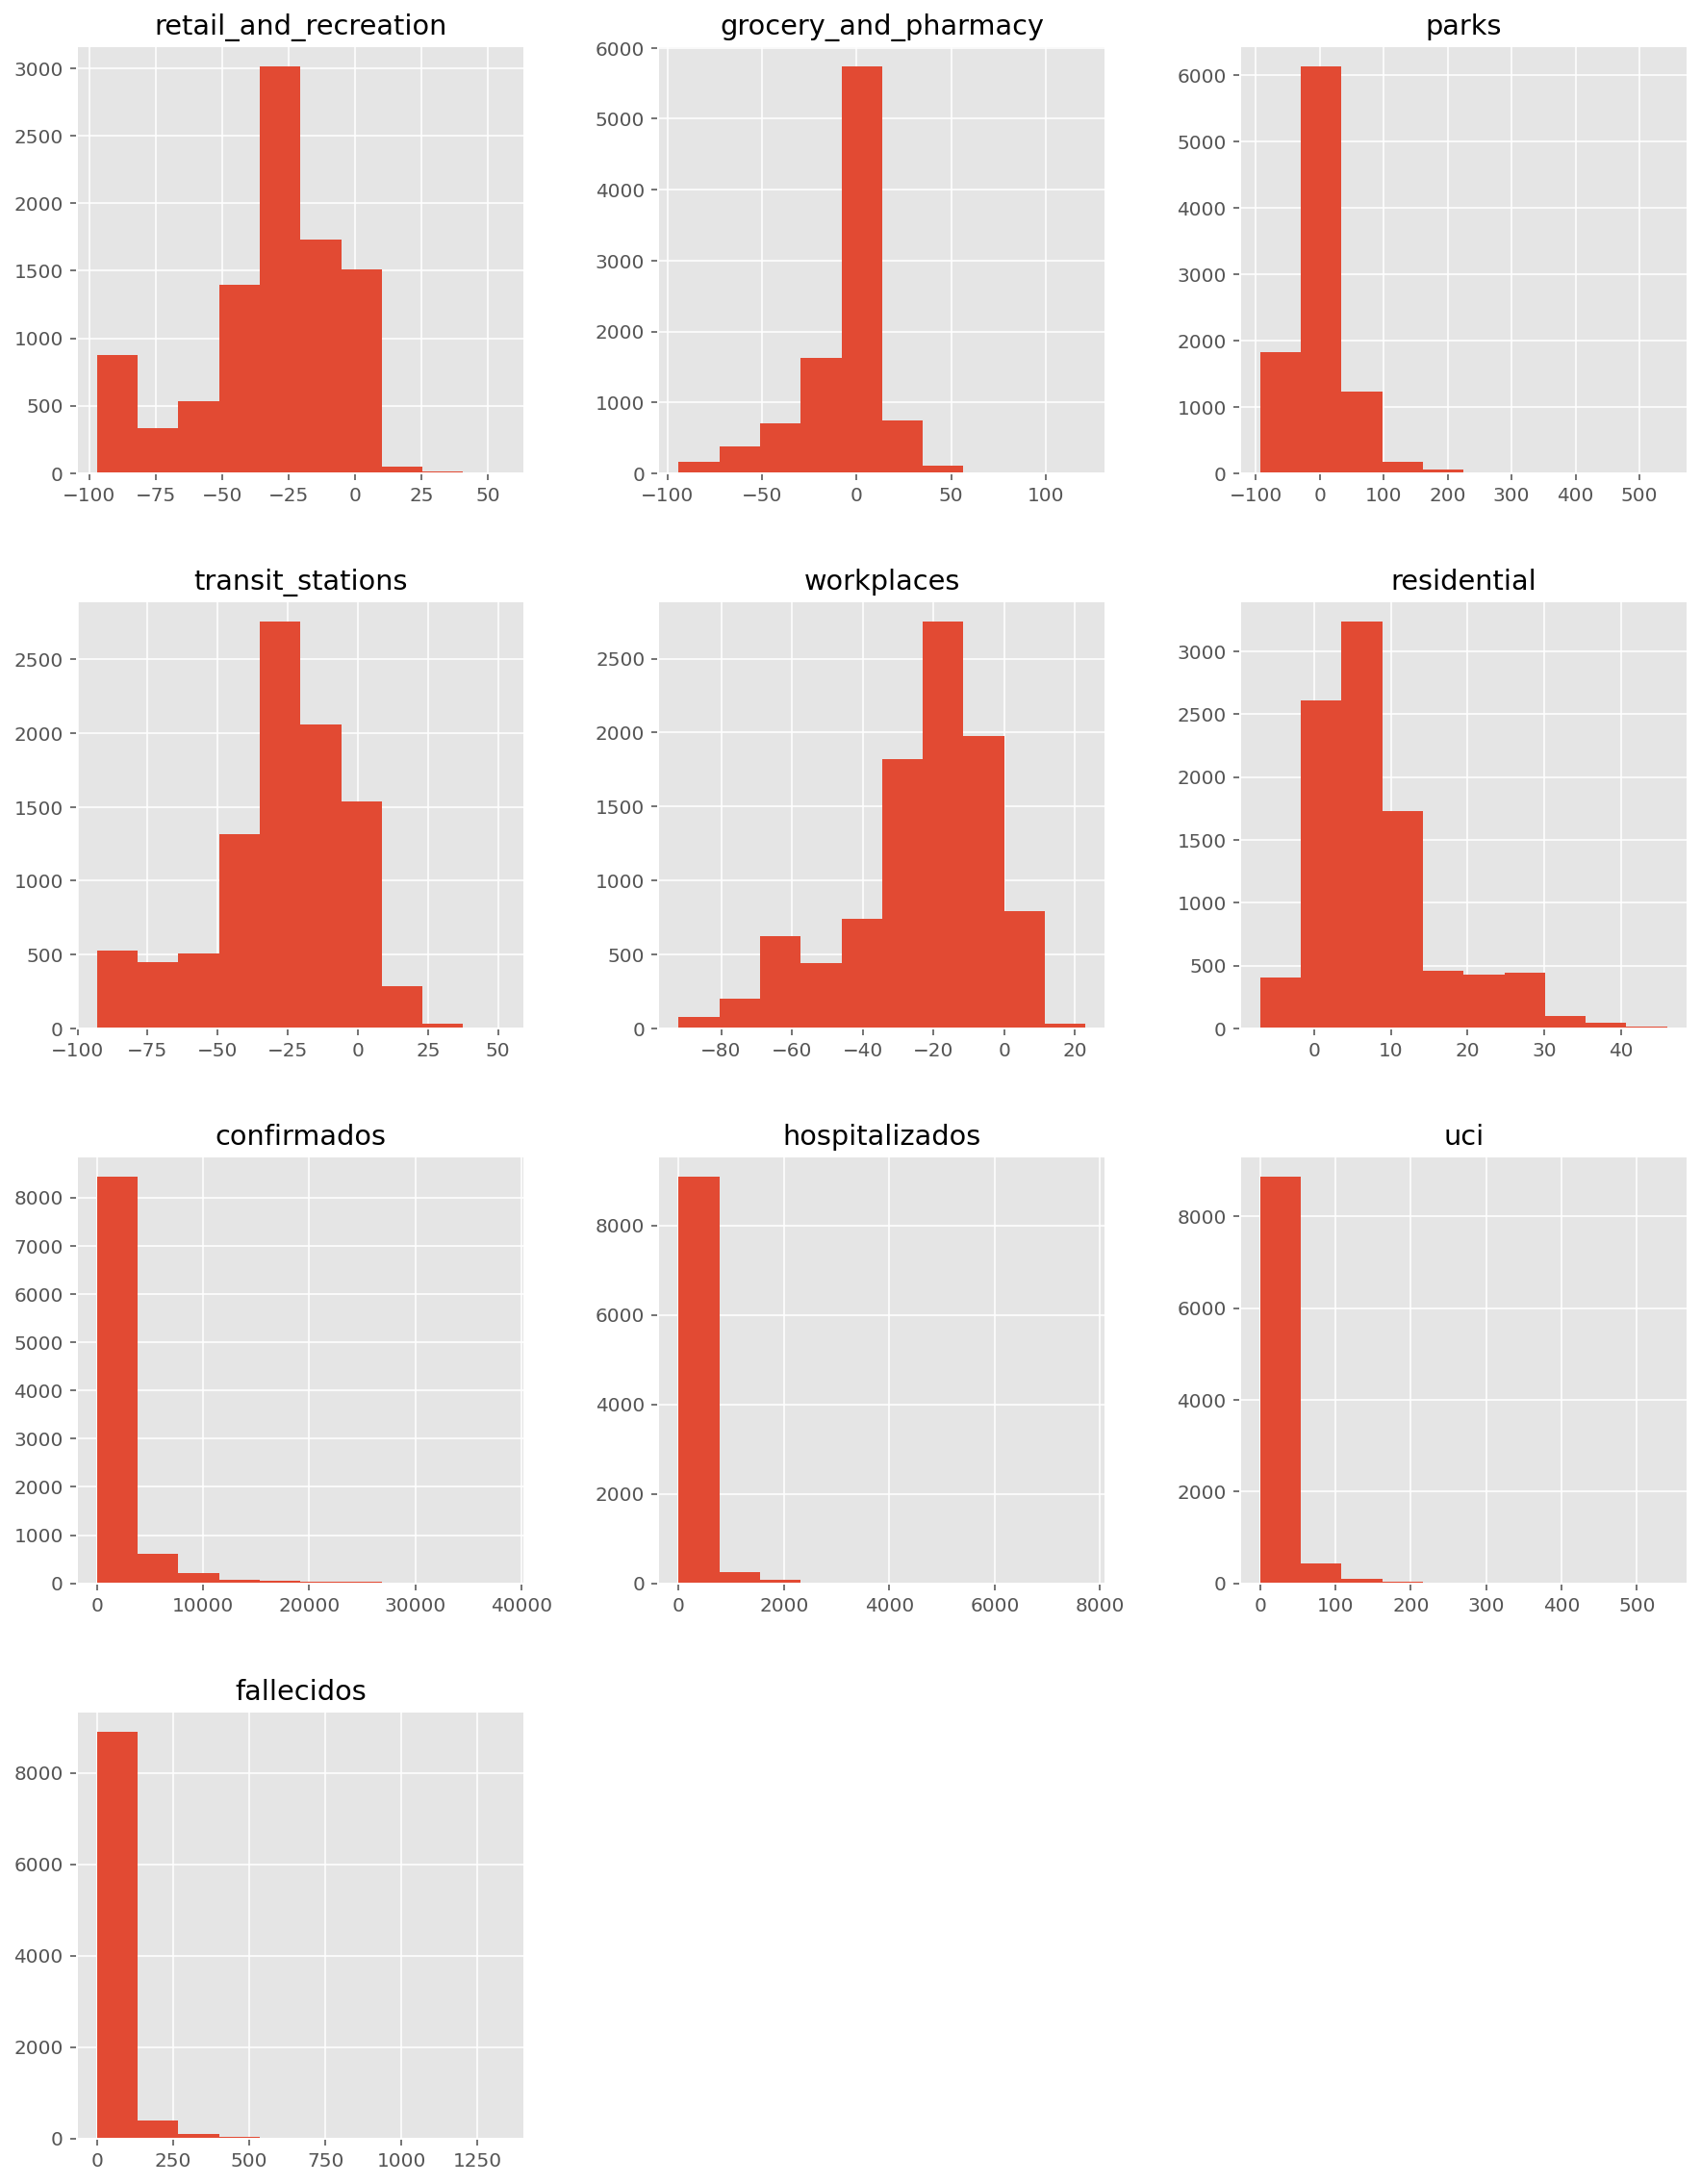

In [251]:
fig = plt.figure(figsize = (15,20))
ax = fig.gca()
df_cm.hist(ax = ax)

### Datos Movilidad

In [252]:
px.histogram(df_cm, x="retail_and_recreation").show()
px.histogram(df_cm, x="grocery_and_pharmacy").show()
px.histogram(df_cm, x="parks").show()
px.histogram(df_cm, x="transit_stations").show()
px.histogram(df_cm, x="workplaces").show()
px.histogram(df_cm, x="residential").show()

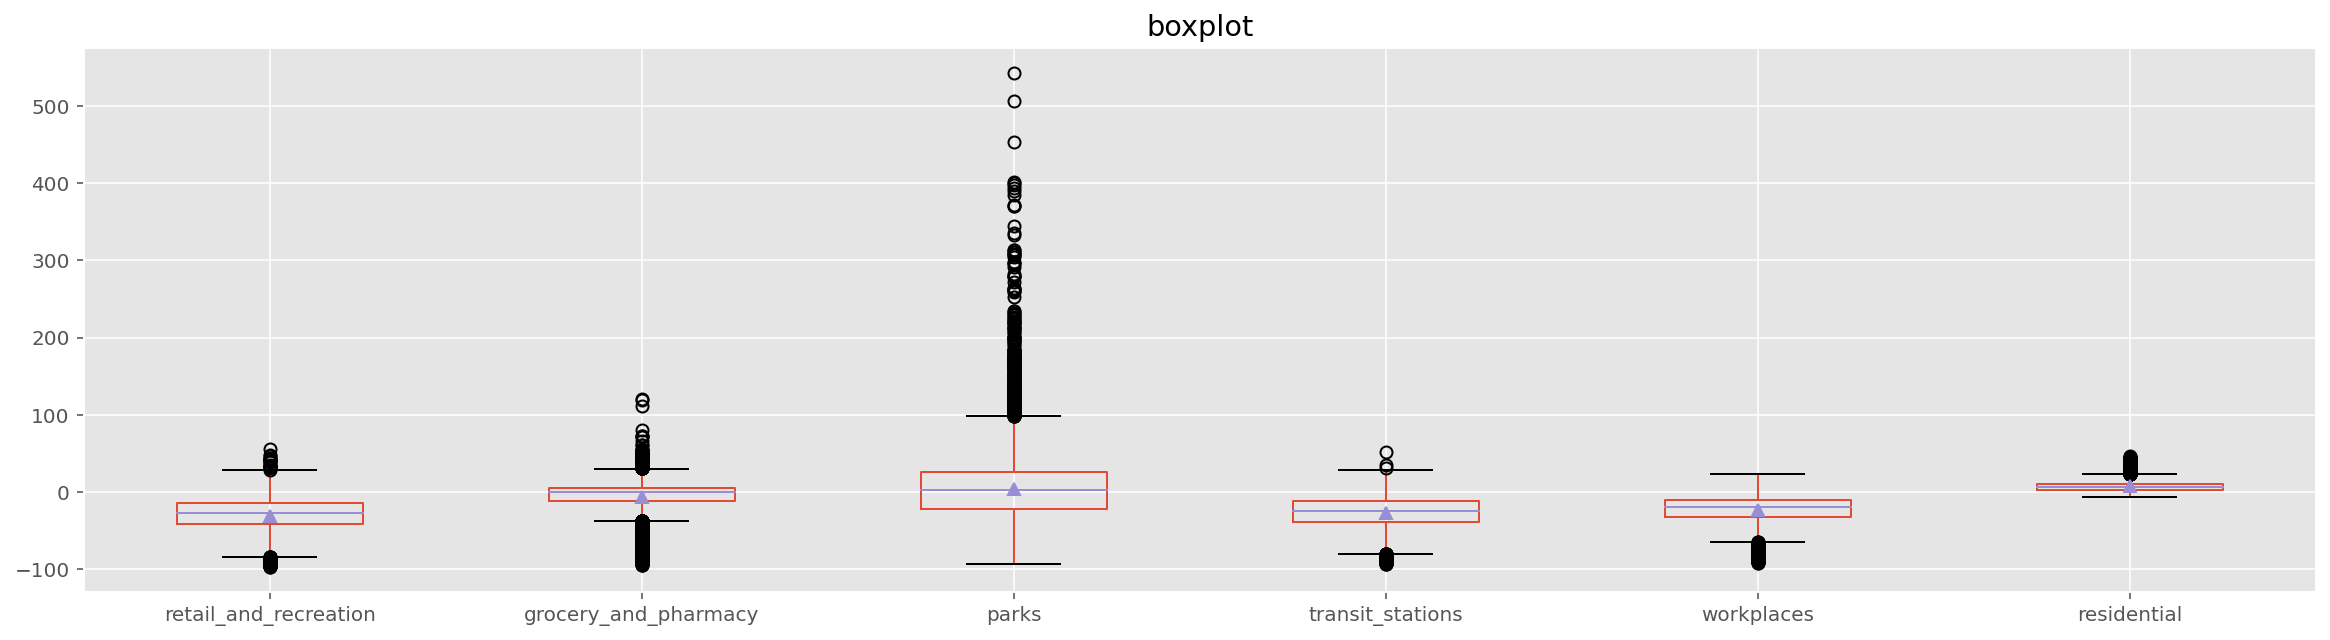

In [253]:
# Boxplot datos Movilidad
ax = df_cm[['retail_and_recreation', 'grocery_and_pharmacy',
       'parks', 'transit_stations', 'workplaces', 'residential']].plot(kind='box', title='boxplot', showmeans=True, figsize=(20, 5))
plt.show()

* Se observa que las variables *grocery_and_pharmacy, parks y transit_stations* de los datos de movilidad presentan valores atípicos. Destaca la variable Parks con una cantidad elevada de Outliers, se procede a validar el porcentaje de valres fuera de rango.
* Para obtener mayor información, visitar la [página de consulta](https://support.google.com/covid19-mobility/answer/9825414?hl=es&ref_topic=9822927) que google pone a disposición.

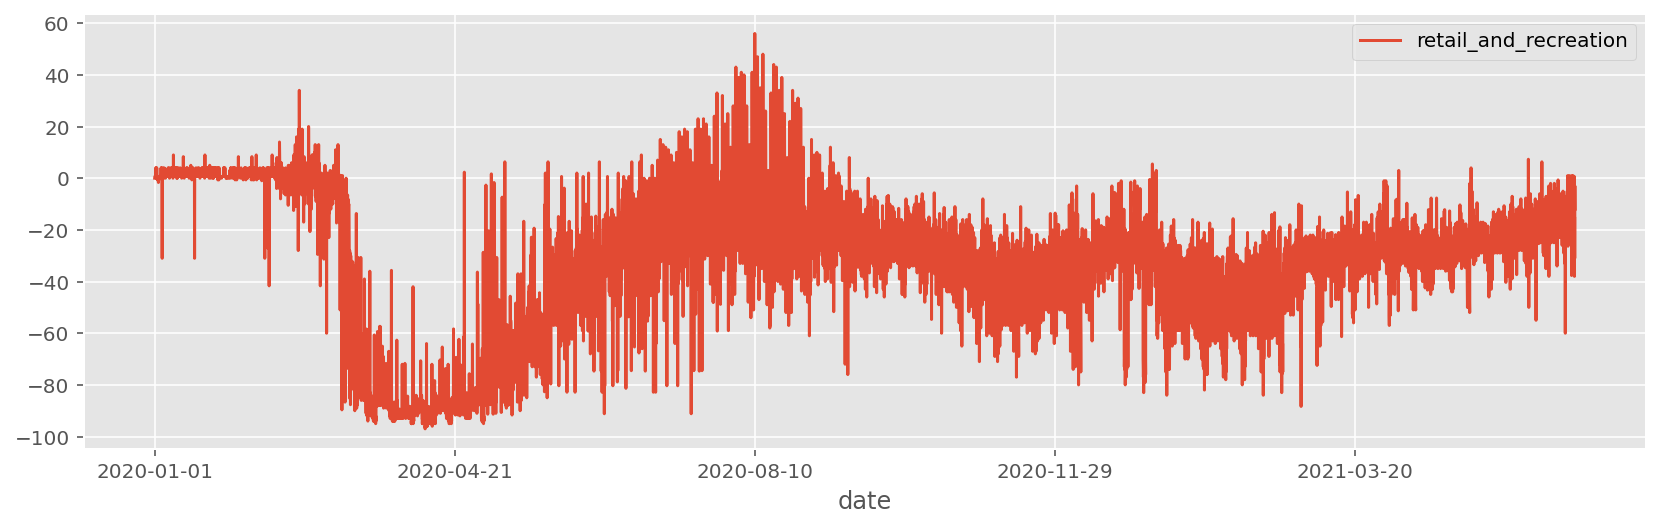

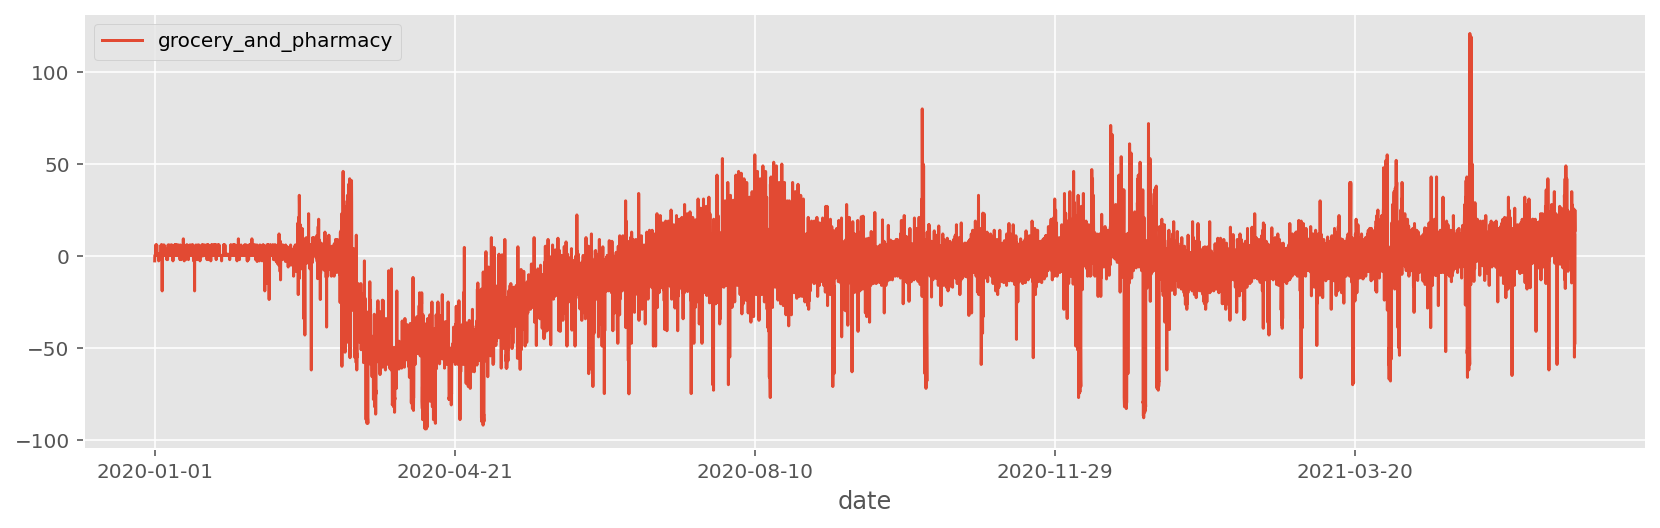

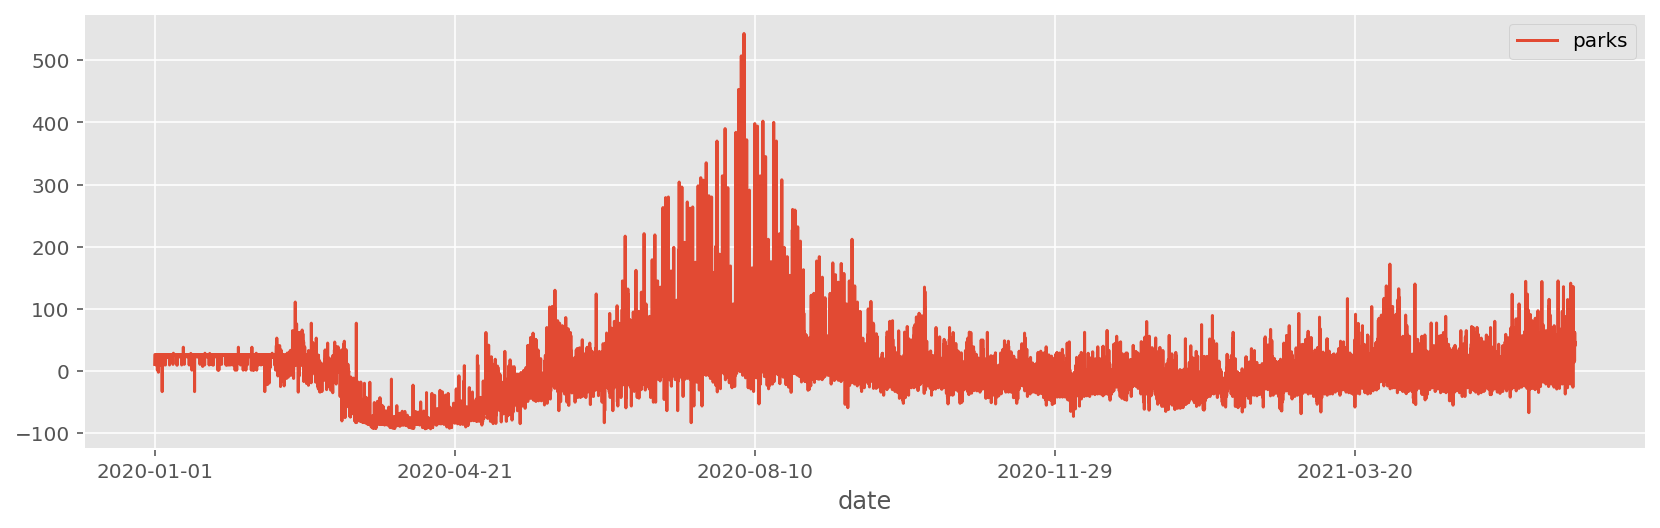

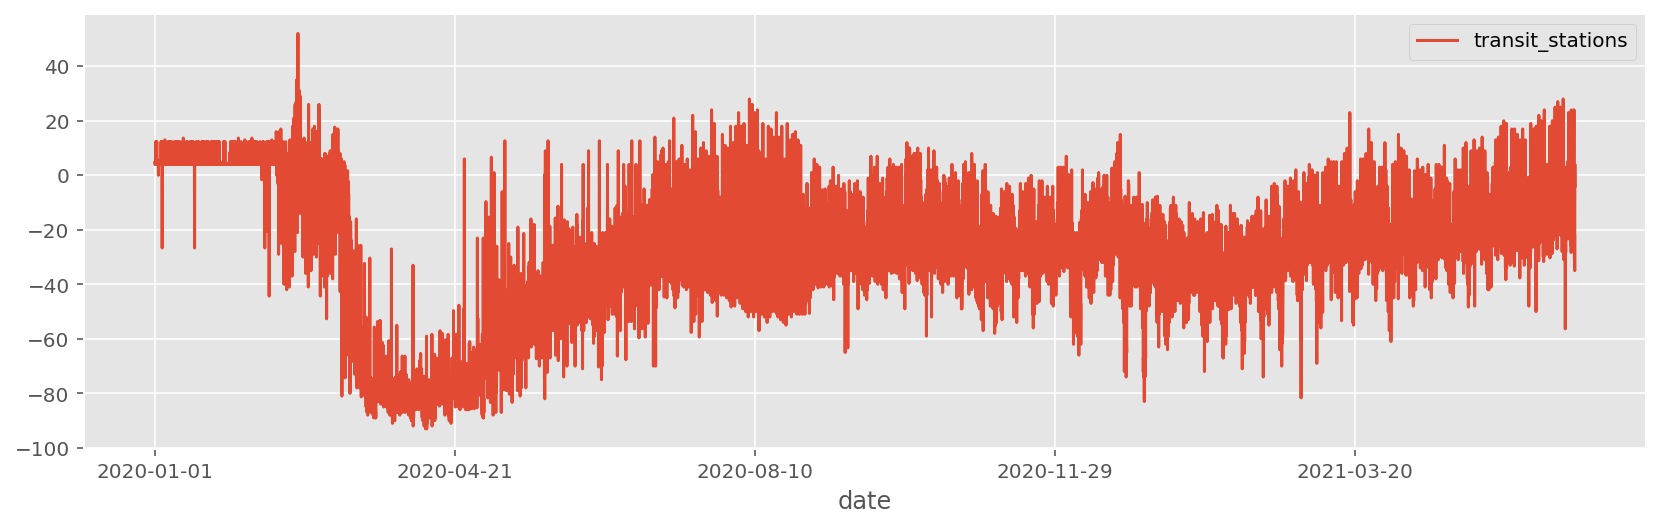

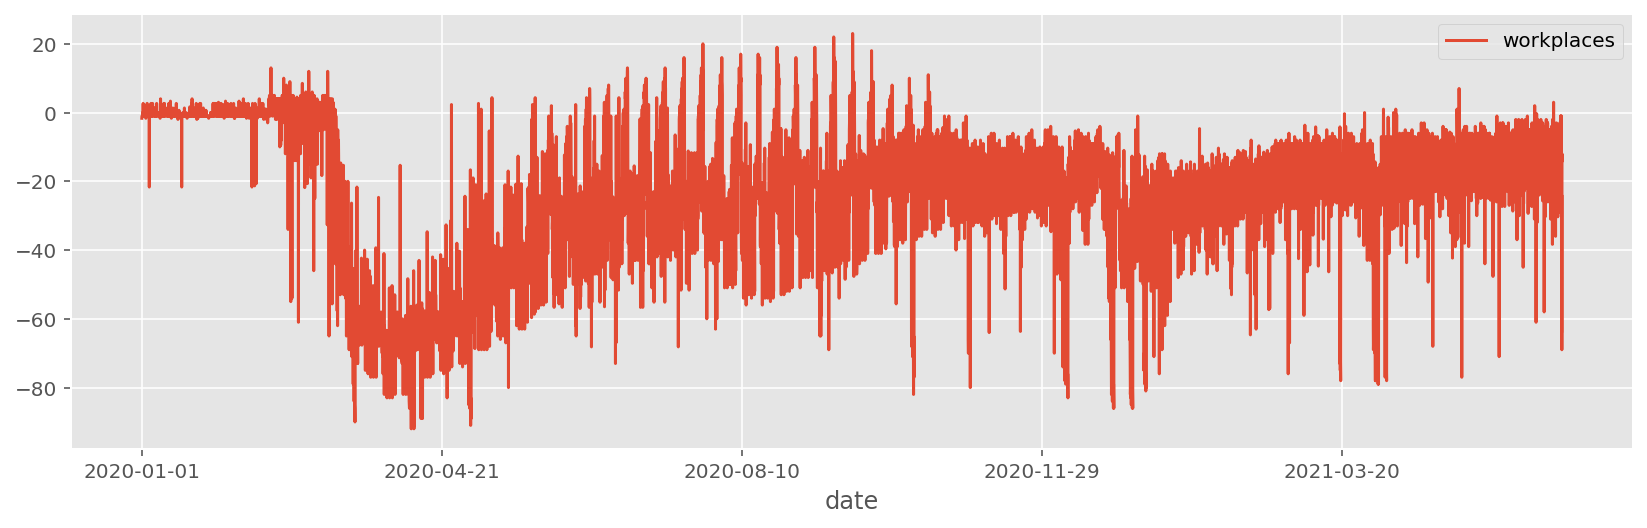

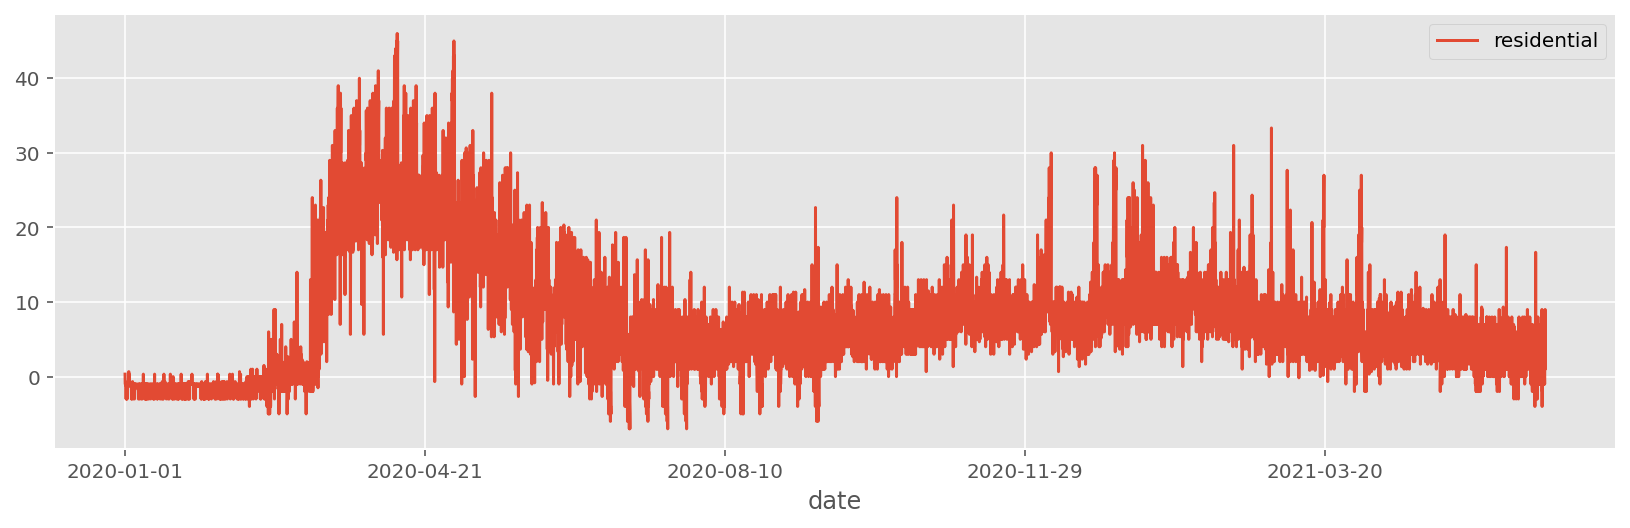

In [254]:
df_cm.plot(x="date", y="retail_and_recreation", figsize=(14,4))
df_cm.plot(x="date", y="grocery_and_pharmacy", figsize=(14,4))
df_cm.plot(x="date", y="parks", figsize=(14,4))
df_cm.plot(x="date", y="transit_stations", figsize=(14,4))
df_cm.plot(x="date", y="workplaces", figsize=(14,4))
df_cm.plot(x="date", y="residential", figsize=(14,4))

### Datos Covid

In [255]:
px.histogram(df_cm, x="confirmados").show()
px.histogram(df_cm, x="hospitalizados").show()
px.histogram(df_cm, x="uci").show()
px.histogram(df_cm, x="fallecidos").show()

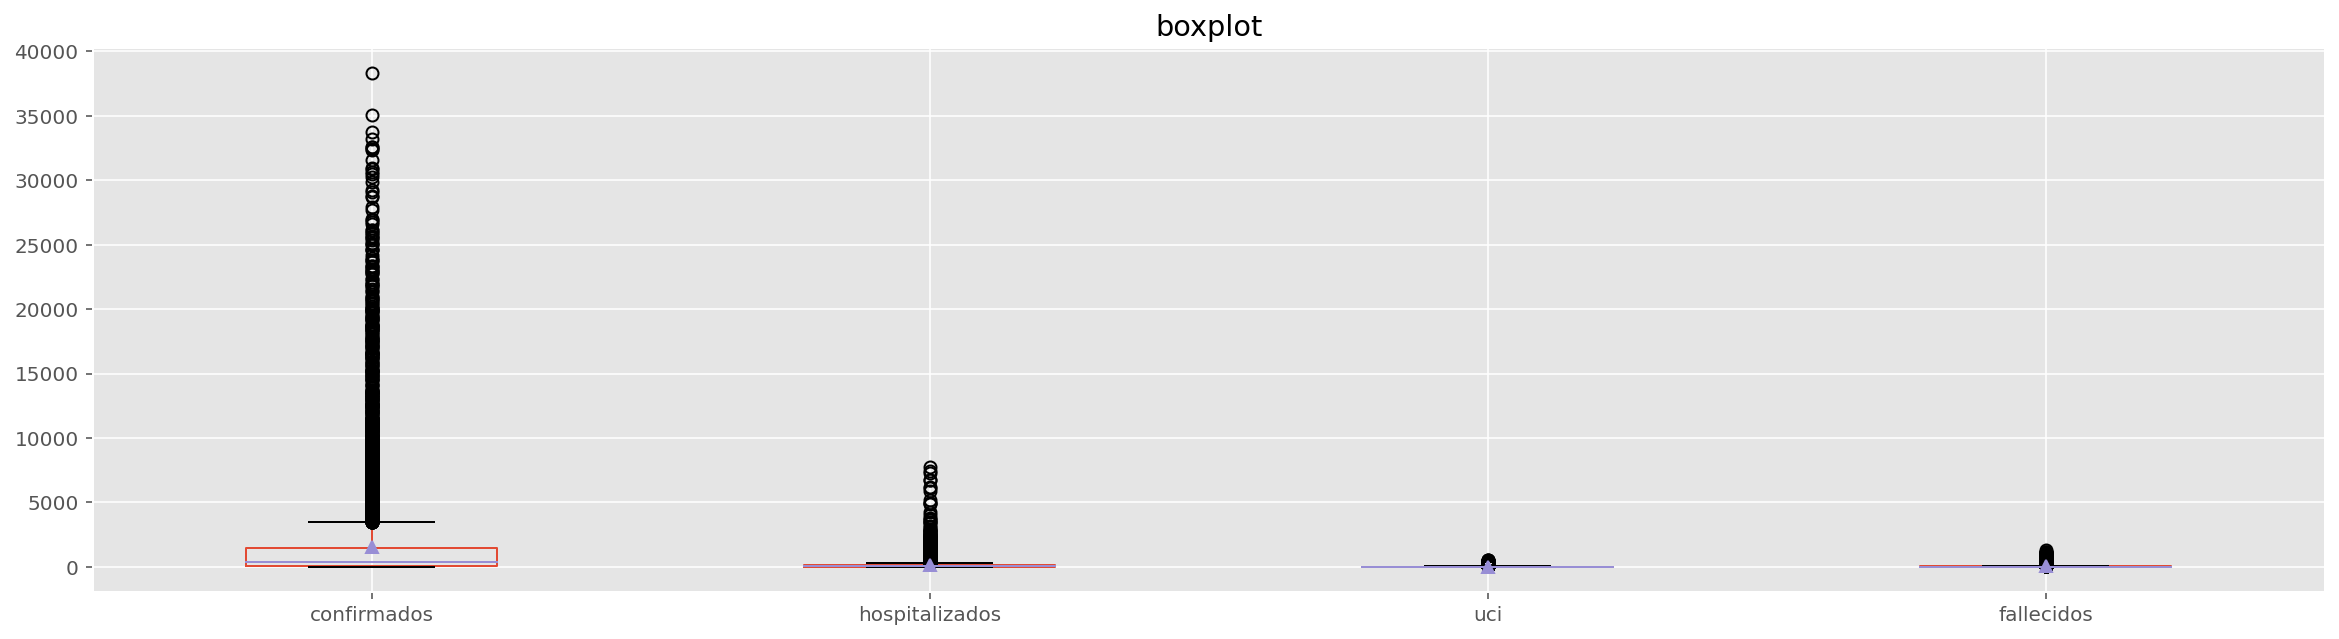

In [256]:
# Boxplot datos Covid
ax = df_cm[['confirmados', 'hospitalizados', 'uci', 'fallecidos']].plot(kind='box', title='boxplot', showmeans=True, figsize=(20, 5))
plt.show()

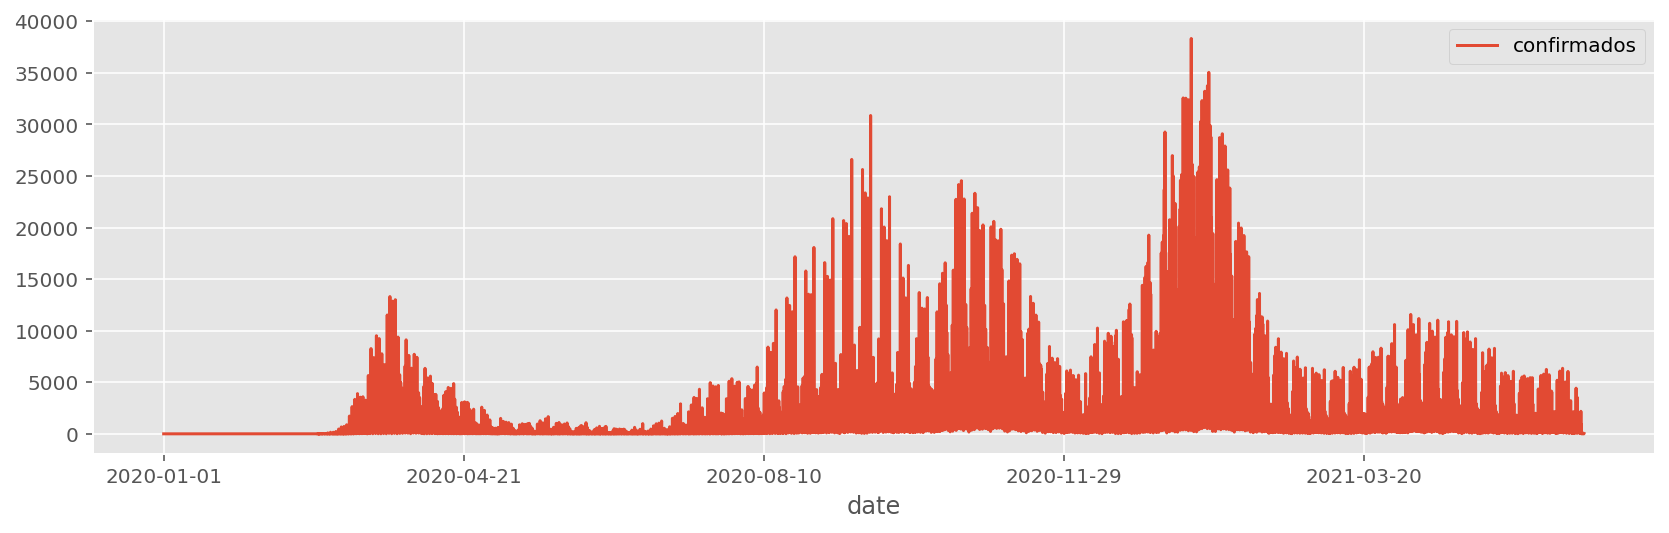

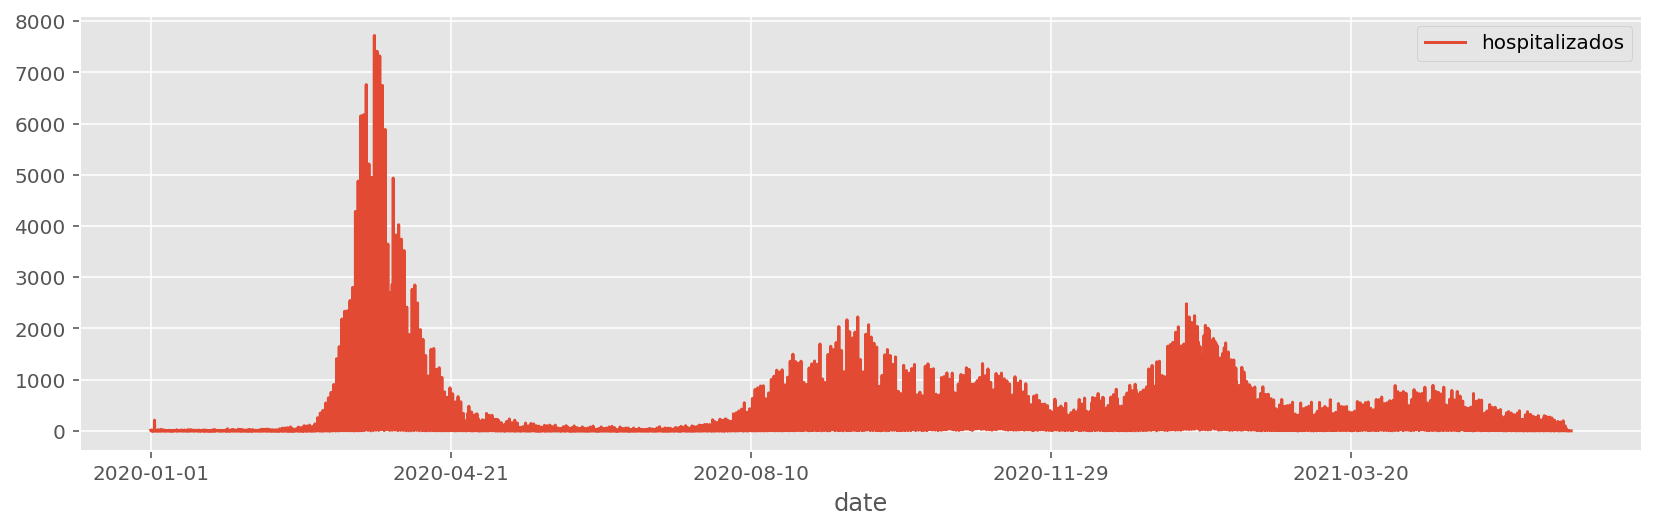

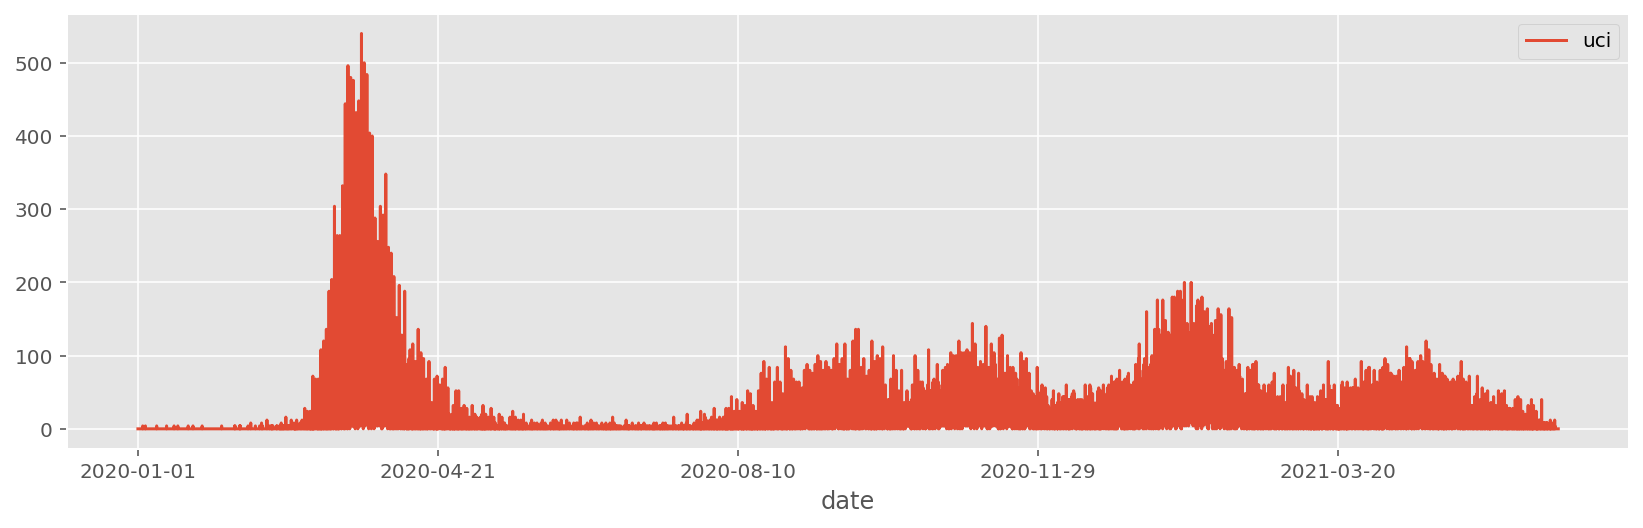

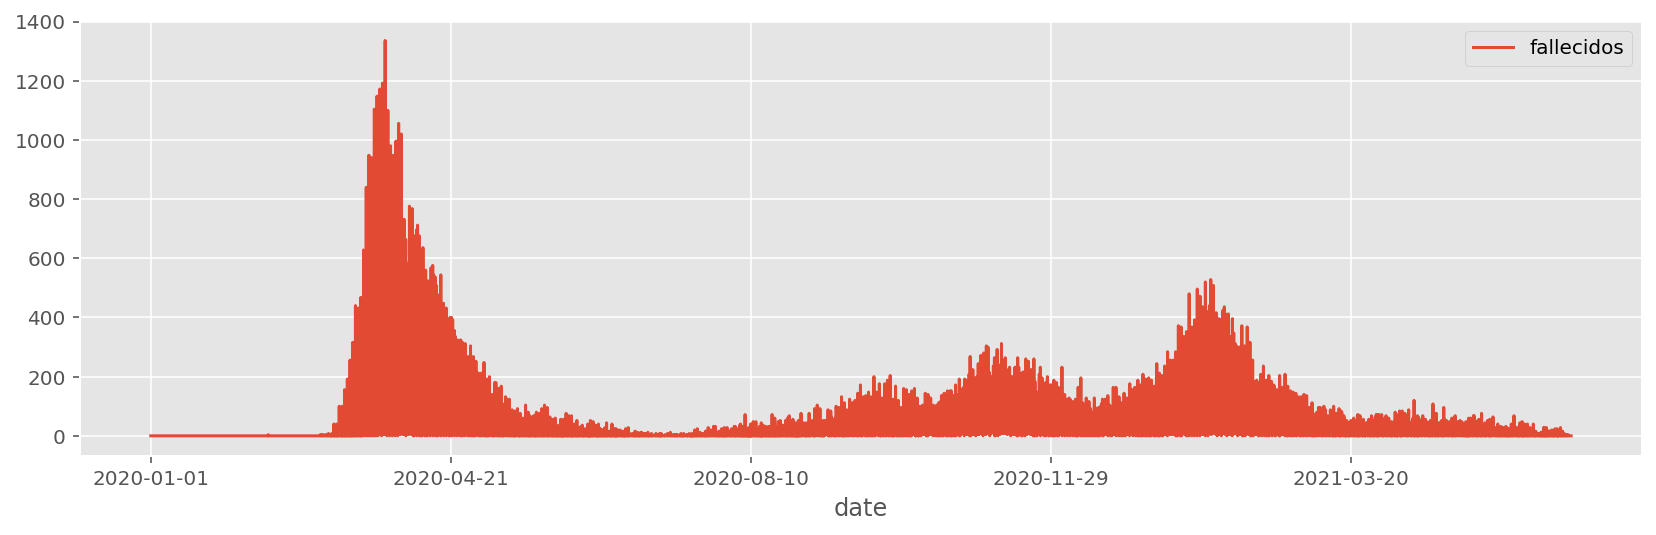

In [257]:
df_cm.plot(x="date", y="confirmados", figsize=(14,4))
df_cm.plot(x="date", y="hospitalizados", figsize=(14,4))
df_cm.plot(x="date", y="uci", figsize=(14,4))
df_cm.plot(x="date", y="fallecidos", figsize=(14,4))

Text(0, 0.5, 'Conteo')

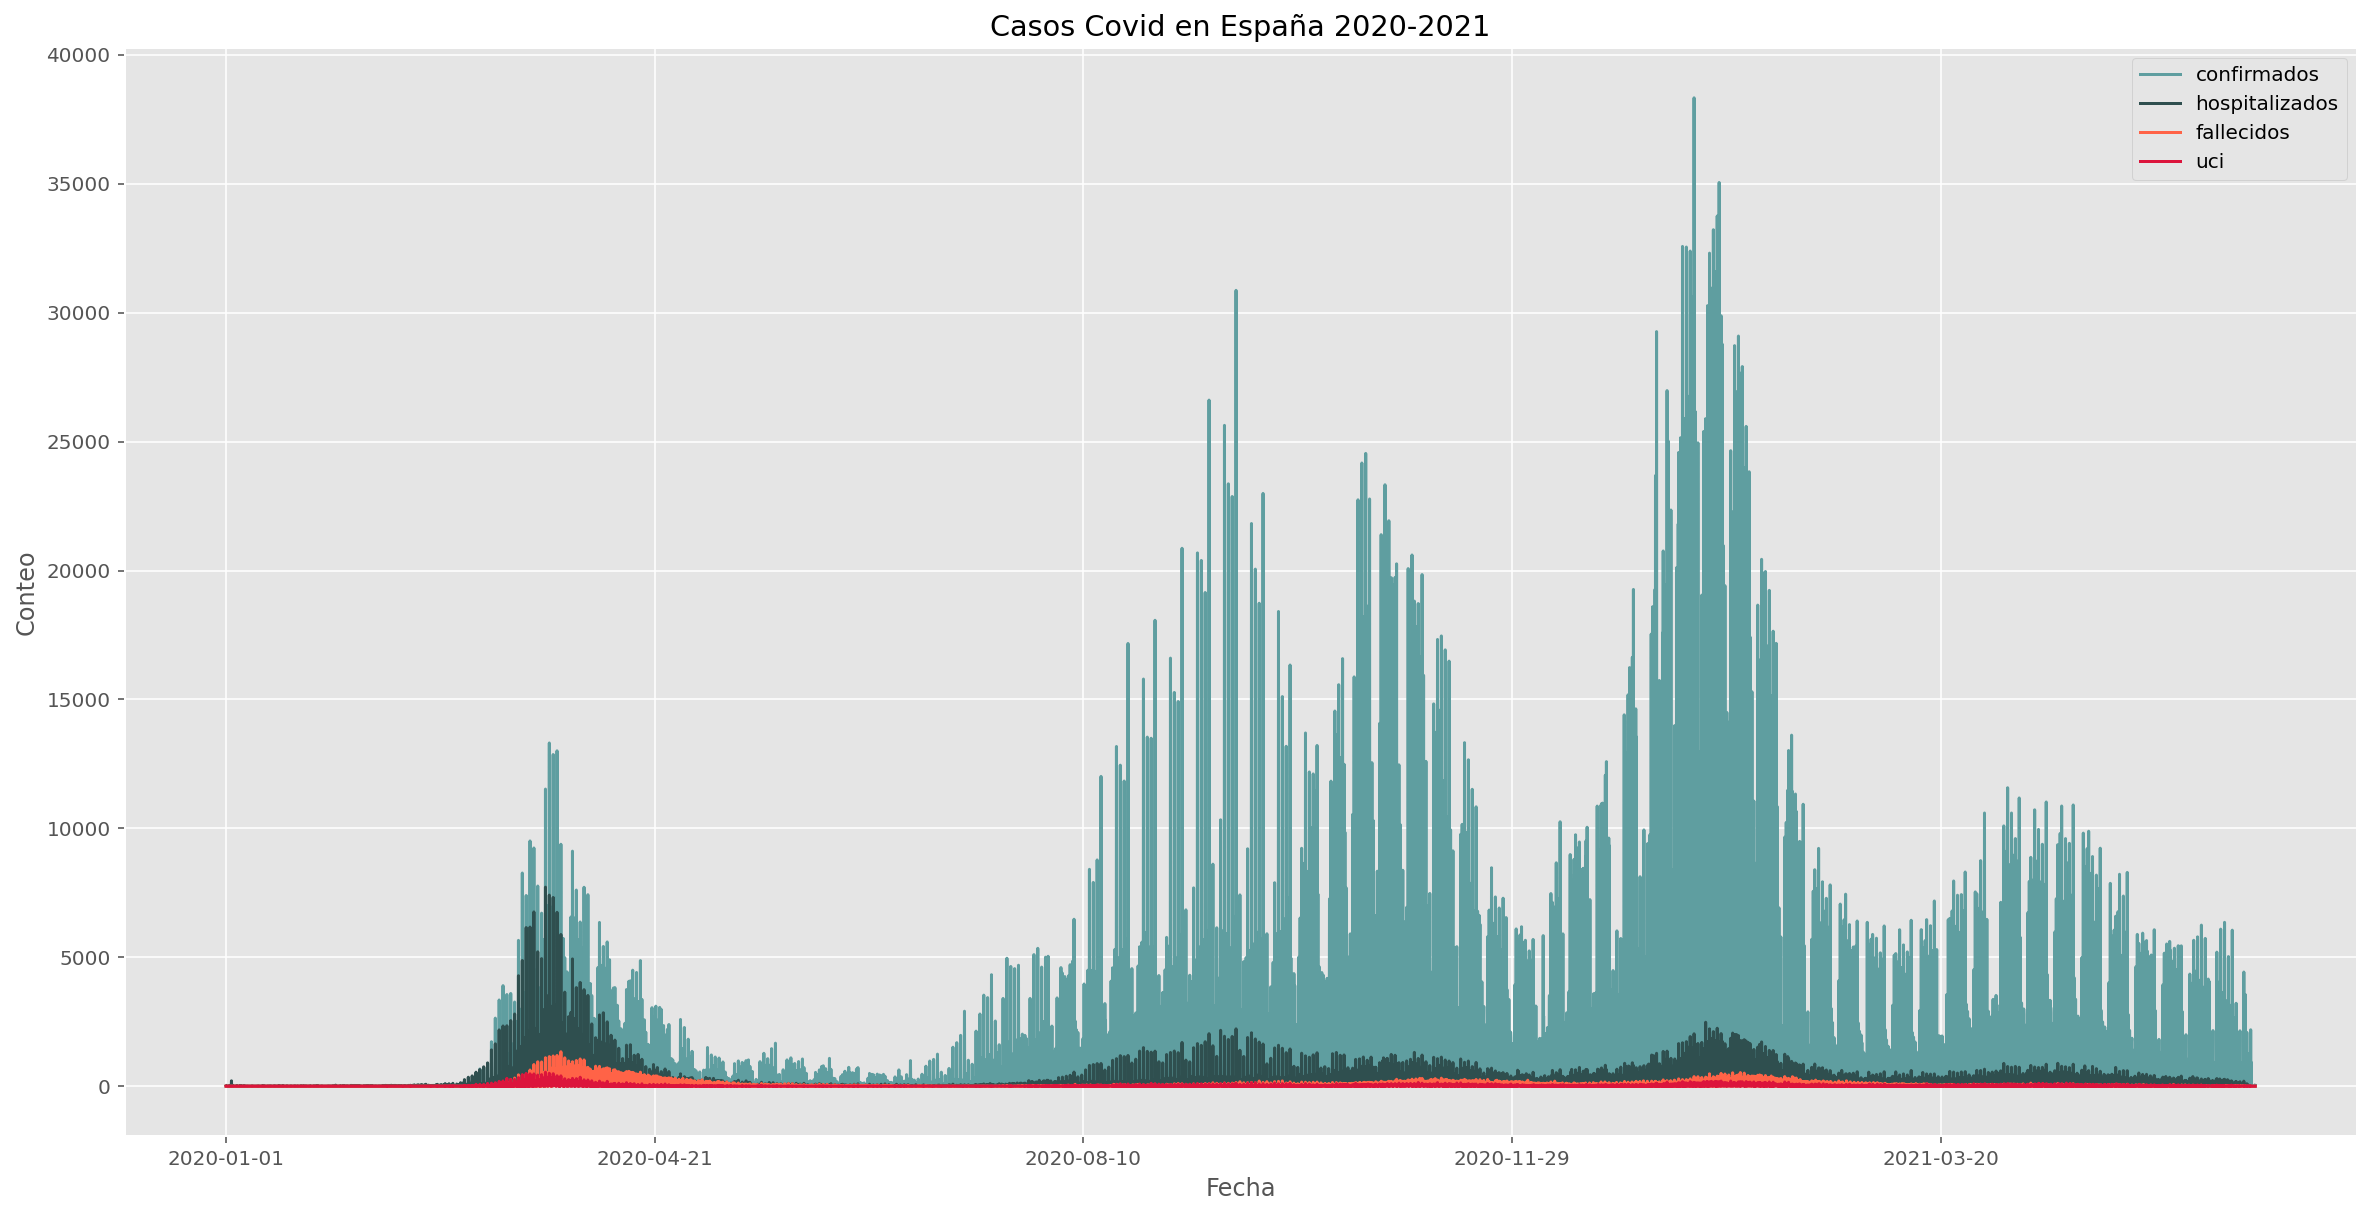

In [258]:
style.use('ggplot')
ax = plt.gca()
df_cm.plot.line(x='date', y='confirmados', color='cadetblue', ax=ax, figsize=(20, 10))
df_cm.plot.line(x='date', y='hospitalizados', color='darkslategray', ax=ax)
df_cm.plot.line(x='date', y='fallecidos', color='tomato', ax=ax)
df_cm.plot.line(x='date', y='uci', color='crimson', ax=ax)
plt.title('Casos Covid en España 2020-2021')
plt.xlabel('Fecha')
plt.ylabel('Conteo')

In [259]:
#px.bar(df_cm, x="date", y="confirmados", title='Confirmados').show()

# Análisis PCA

In [260]:
df_cm3 = df_cm.copy()
#df_cm3 = df_cm3.drop(['parks'], 1)
df_cm3.describe()

,retail_and_recreation,grocery_and_pharmacy,parks,transit_stations,workplaces,residential,confirmados,hospitalizados,uci,fallecidos
count,"9,468.00","9,468.00","9,468.00","9,468.00","9,468.00","9,468.00","9,468.00","9,468.00","9,468.00","9,468.00"
mean,-31.38,-6.37,3.96,-27.22,-23.18,7.77,"1,559.86",152.66,14.43,33.77
std,26.20,21.59,48.56,24.34,20.18,8.22,"3,359.67",374.58,31.36,80.40
min,-97.00,-94.00,-93.00,-93.00,-92.00,-7.00,0.00,0.00,0.00,0.00
25%,-42.00,-12.00,-22.00,-39.00,-32.00,2.00,56.00,8.00,0.00,0.00
50%,-27.00,0.00,3.00,-25.00,-19.00,6.00,404.00,40.00,4.00,8.00
75%,-14.00,5.00,26.33,-11.58,-10.00,10.33,"1,432.00",136.00,16.00,32.00
max,56.00,121.00,543.00,52.00,23.00,46.00,"38,336.00","7,720.00",540.00,"1,336.00"


In [261]:
# Validación de columnas: ¿Podrían ser categóricas de acuerdo a sus valores?
for i in df_cm3.columns:
  if len(df_cm3[i].unique()) < 5:
    print('La Columna {} podría ser. Solo tiene {} valores únicos: {}'.format(i, len(df_cm3[i].unique()), df_cm3[i].unique()))

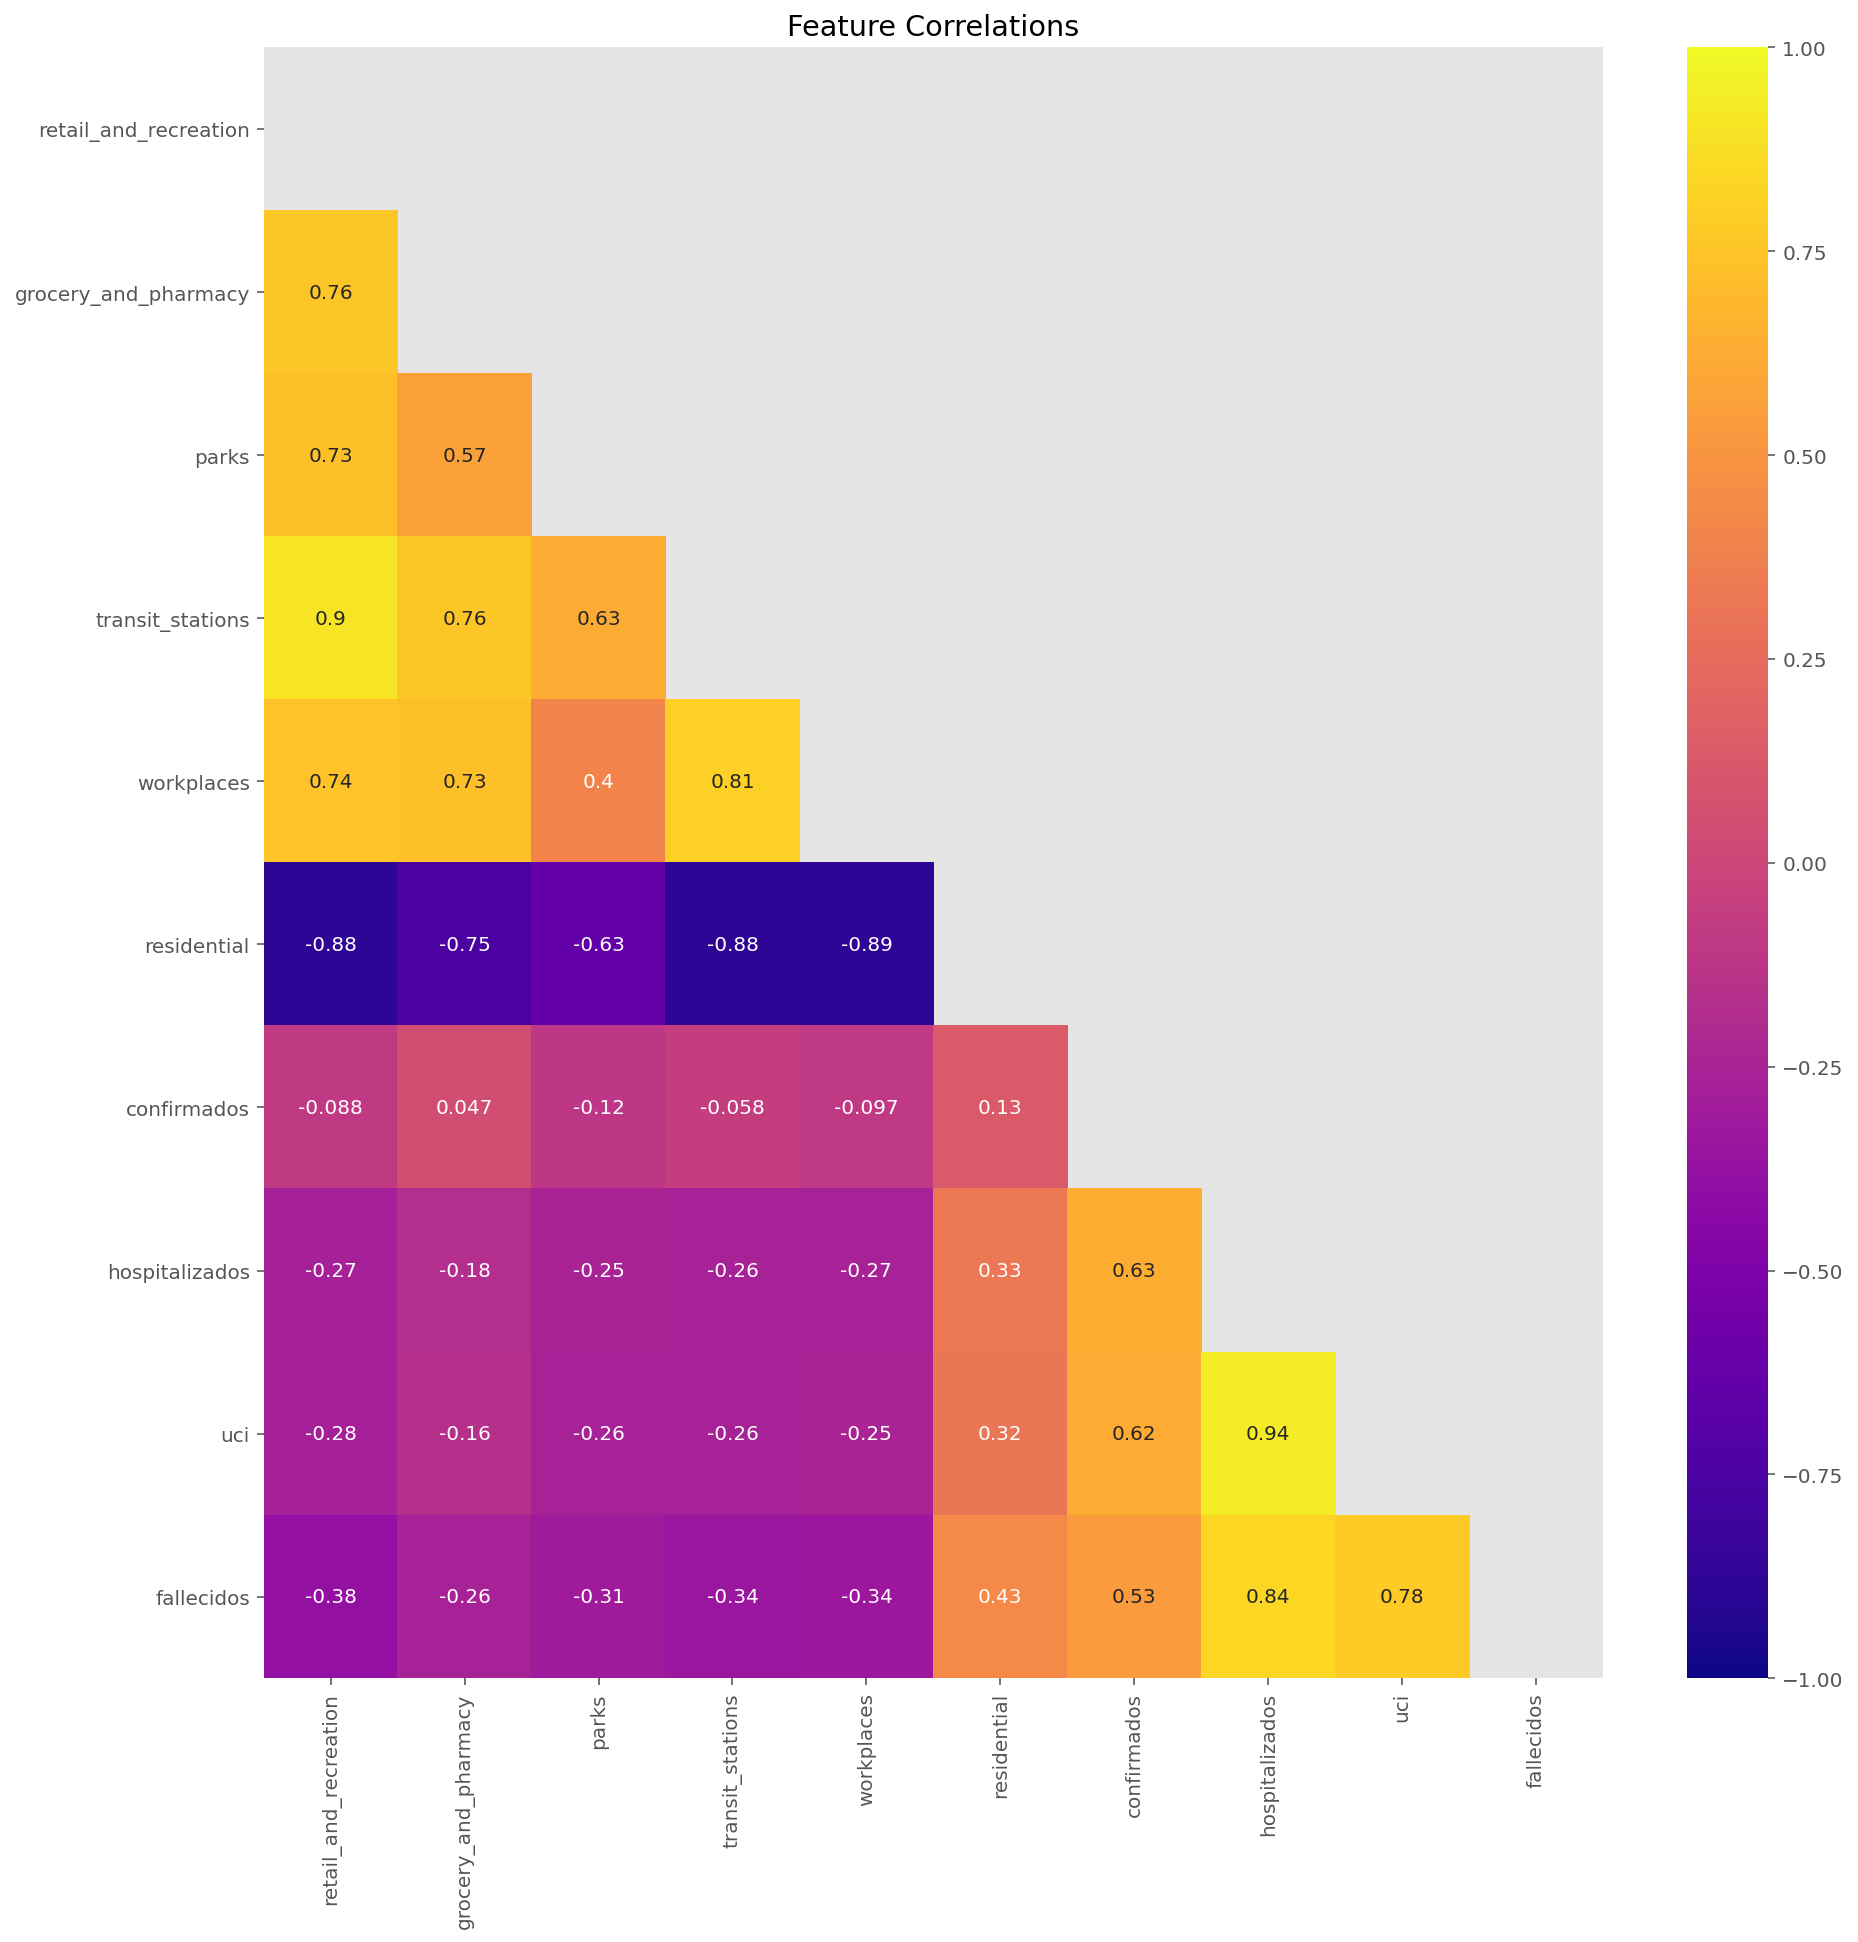

In [262]:
# Validación correlaciones con la variable dependiente
colormap = plt.cm.plasma
matrix1 = np.triu(df_cm3.corr())
plt.figure(figsize=(15, 15))
sns.heatmap(df_cm3.corr(), annot=True, vmax=1, vmin=-1, mask=matrix1, cmap=colormap)
plt.title("Feature Correlations")
plt.show()

In [263]:
df_cm3.columns

Index(['date', 'iso', 'ccaa', 'retail_and_recreation', 'grocery_and_pharmacy',
       'parks', 'transit_stations', 'workplaces', 'residential', 'confirmados',
       'hospitalizados', 'uci', 'fallecidos'],
      dtype='object')

In [264]:

columnas = ['date', 'ccaa', 'retail_and_recreation', 'grocery_and_pharmacy',
       'transit_stations', 'workplaces', 'residential', 'confirmados',
       'hospitalizados', 'uci', 'fallecidos']

data = df_cm3[columnas].copy()

In [265]:
# Check the significance of the correlation coefficient with a t-test
def corr_coef(x, y):
    '''It returns the correlation coefficient for two given series'''

    x_mean = np.mean(x)
    y_mean = np.mean(y)

    numerator = np.sum((x - x_mean) * (y - y_mean))
    denominator = np.sqrt(np.sum((x - x_mean) * (x - x_mean))) * np.sqrt(np.sum((y - y_mean) * (y - y_mean)))

    r = numerator / denominator

    return r


def t_value(n, r, k):
    '''It returns the critical t-value'''

    num = n -2 - k
    den = 1 - (r ** 2)

    t_value = r * np.sqrt(num / den)

    return t_value


var = ['retail_and_recreation', 'grocery_and_pharmacy',
       'transit_stations', 'workplaces', 'residential', 'confirmados',
       'hospitalizados', 'uci', 'fallecidos']

for i in var:
  for j in var:
    if i != j:
      corr = corr_coef(data[i], data[j])
      t = t_value(len(data), corr, 1)

      print('Correlation coefficient {} and {}: {}'.format(i, j, round(corr, 3)))
      print('T-value of {} and {}: {}'.format(i, j, round(t)))
      print(' ')
      print('--'*12)
      print(' ')

Correlation coefficient retail_and_recreation and grocery_and_pharmacy: 0.761
T-value of retail_and_recreation and grocery_and_pharmacy: 114
 
------------------------
 
Correlation coefficient retail_and_recreation and transit_stations: 0.899
T-value of retail_and_recreation and transit_stations: 199
 
------------------------
 
Correlation coefficient retail_and_recreation and workplaces: 0.745
T-value of retail_and_recreation and workplaces: 109
 
------------------------
 
Correlation coefficient retail_and_recreation and residential: -0.885
T-value of retail_and_recreation and residential: -185
 
------------------------
 
Correlation coefficient retail_and_recreation and confirmados: -0.088
T-value of retail_and_recreation and confirmados: -9
 
------------------------
 
Correlation coefficient retail_and_recreation and hospitalizados: -0.269
T-value of retail_and_recreation and hospitalizados: -27
 
------------------------
 
Correlation coefficient retail_and_recreation and uci

In [266]:
# Many of the features are correlated to each other. This is a common problem in data science and it is called “multicollinearity”.
# In an ideal case features should be independent of each other. We will do Principal Components Analysis (PCA) to eliminate redundant feature.
# Per the (PCA) result the least important features will be eliminated. This feature elimination step is important because using highly correlated feature 
# in multiple regression model can cause inaccurate results.  

# Source: https://towardsdatascience.com/a-one-stop-shop-for-principal-component-analysis-5582fb7e0a9c

features = ['retail_and_recreation', 'grocery_and_pharmacy',
       'transit_stations', 'workplaces', 'residential',
       'hospitalizados', 'uci', 'fallecidos']

# Separate data into Y and X 
y = data['confirmados']
X = data[features]

In [267]:
# Take the matrix of independent variables X and, for each column, subtract the mean of that column from each entry. 
# (This ensures that each column has a mean of zero.)
X.mean()

X = X - X.mean()

In [268]:
# Normalize X
Z = X / X.std()

In [269]:
# Check that the mean = 0 and the standard deviation = 1
print('MEAN:')
print(Z.mean())
print('---'*15)
print('STD:')
print(Z.std())

MEAN:
retail_and_recreation   -0.00
grocery_and_pharmacy     0.00
transit_stations         0.00
workplaces               0.00
residential              0.00
hospitalizados           0.00
uci                     -0.00
fallecidos               0.00
dtype: float64
---------------------------------------------
STD:
retail_and_recreation   1.00
grocery_and_pharmacy    1.00
transit_stations        1.00
workplaces              1.00
residential             1.00
hospitalizados          1.00
uci                     1.00
fallecidos              1.00
dtype: float64


In [270]:
# Take the matrix Z, transpose it, and multiply the transposed matrix by Z.
# This is the covariance matrix of Z
Z = np.dot(Z.T, Z)

In [271]:
# w is assigned an array of computed eigenvalues.
# v is assigned the matrix whose columns are the normalized eigenvectors corresponding to the eigenvalues in that order.
eigenvalues, eigenvectors = np.linalg.eig(Z)

In [272]:
D = np.diag(eigenvalues)
P = eigenvectors

In [273]:
eigenvalues

array([45818.54708682, 20195.88200198,   500.35230698,   535.21727124,
         989.67139809,  2216.88226081,  2896.57624686,  2582.87142723])

In [274]:
# Calculate Z* = ZP*. This new matrix, Z*, is a centered/standardized version of X 
# but now each observation is a combination of the original variables, where the weights are determined by the eigenvector.
Z_new = np.dot(Z, P)

In [275]:
# How many features to keep versus how many to drop? SCREE PLOT!
#1. Calculate the proportion of variance explained by each feature
sum_eigenvalues = np.sum(eigenvalues)

prop_var = [i/sum_eigenvalues for i in eigenvalues]

#2. Calculate the cumulative variance
cum_var = [np.sum(prop_var[:i+1]) for i in range(len(prop_var))]

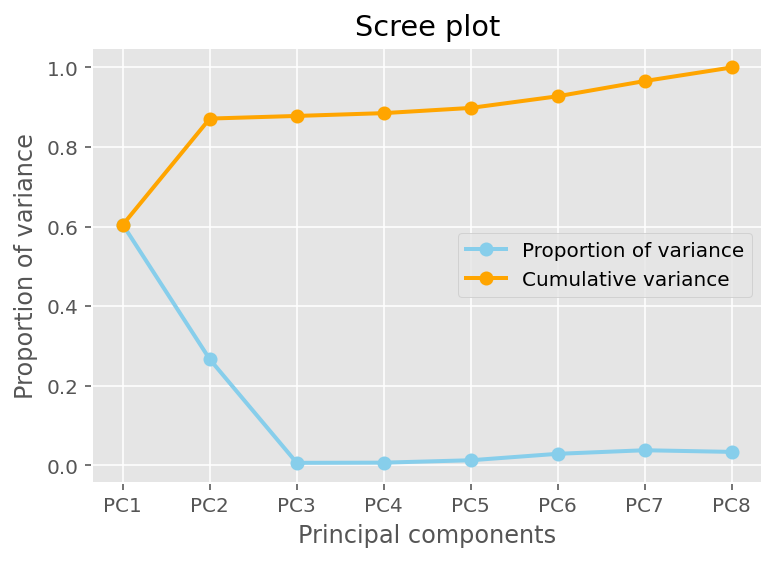

In [276]:
# Plot scree plot from PCA
x_labels = ['PC{}'.format(i+1) for i in range(len(prop_var))]

plt.plot(x_labels, prop_var, marker='o', markersize=6, color='skyblue', linewidth=2, label='Proportion of variance')
plt.plot(x_labels, cum_var, marker='o', color='orange', linewidth=2, label="Cumulative variance")
plt.legend()
plt.title('Scree plot')
plt.xlabel('Principal components')
plt.ylabel('Proportion of variance')
plt.show()

In [277]:
Zdata = pd.DataFrame(Z_new)

In [278]:
Zdata.insert(0,'Features',features)

In [279]:
Zdata.columns = ['Features', 'PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8']

In [280]:
pd.options.display.float_format = "{:,.2f}".format

Zdata

,Features,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8
0,retail_and_recreation,"18,487.91","3,948.18",-184.11,-199.78,-400.29,94.90,66.00,"-1,546.07"
1,grocery_and_pharmacy,"16,405.57","5,118.71",29.43,29.46,-15.92,-51.22,"2,446.26",761.99
2,transit_stations,"18,563.40","4,355.47",78.59,57.08,764.24,396.98,-343.12,-860.08
3,workplaces,"17,823.57","4,086.79",-100.50,-219.32,55.99,-13.27,"-1,193.79","1,686.54"
4,residential,"-19,309.50","-3,414.46",-163.10,-334.31,434.19,171.71,907.28,-73.35
5,hospitalizados,"-11,925.78","10,940.86",318.62,-218.40,-83.97,-488.07,-128.10,-246.92
6,uci,"-11,618.78","10,754.46",-257.92,169.93,148.25,"-1,132.77",-121.96,-45.24
7,fallecidos,"-13,267.91","9,131.98",-68.37,77.33,-119.22,"1,787.26",-65.49,218.44


# Análisis Clustering

In [281]:
df_cm2 = df_cm.copy()
df_cm2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9468 entries, 0 to 9467
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   date                   9468 non-null   object 
 1   iso                    9468 non-null   object 
 2   ccaa                   9468 non-null   object 
 3   retail_and_recreation  9468 non-null   float64
 4   grocery_and_pharmacy   9468 non-null   float64
 5   parks                  9468 non-null   float64
 6   transit_stations       9468 non-null   float64
 7   workplaces             9468 non-null   float64
 8   residential            9468 non-null   float64
 9   confirmados            9468 non-null   float64
 10  hospitalizados         9468 non-null   float64
 11  uci                    9468 non-null   float64
 12  fallecidos             9468 non-null   float64
dtypes: float64(10), object(3)
memory usage: 961.7+ KB


In [282]:
df_cm2.columns

Index(['date', 'iso', 'ccaa', 'retail_and_recreation', 'grocery_and_pharmacy',
       'parks', 'transit_stations', 'workplaces', 'residential', 'confirmados',
       'hospitalizados', 'uci', 'fallecidos'],
      dtype='object')

In [283]:
#Normalización de valores
#Fuente: https://www.kaggle.com/parasjindal96/how-to-normalize-dataframe-pandas

df_cm2_ = df_cm2[['date', 'iso', 'ccaa', 'retail_and_recreation', 'grocery_and_pharmacy',
       'parks', 'transit_stations', 'workplaces', 'residential', 'confirmados',
       'hospitalizados', 'uci', 'fallecidos']].copy()

# Normalización de cada columna con valores 0 a 20
#for i in df_cm2_.iloc[:,4:]:
#  df_cm2_[i]=((df_cm2_[i]-df_cm2_[i].min()) / 
#              (df_cm2_[i].max()-df_cm2_[i].min()))*20 #Modificar 20 si se requiere más o menos

df_cm2_.describe()

,retail_and_recreation,grocery_and_pharmacy,parks,transit_stations,workplaces,residential,confirmados,hospitalizados,uci,fallecidos
count,"9,468.00","9,468.00","9,468.00","9,468.00","9,468.00","9,468.00","9,468.00","9,468.00","9,468.00","9,468.00"
mean,-31.38,-6.37,3.96,-27.22,-23.18,7.77,"1,559.86",152.66,14.43,33.77
std,26.20,21.59,48.56,24.34,20.18,8.22,"3,359.67",374.58,31.36,80.40
min,-97.00,-94.00,-93.00,-93.00,-92.00,-7.00,0.00,0.00,0.00,0.00
25%,-42.00,-12.00,-22.00,-39.00,-32.00,2.00,56.00,8.00,0.00,0.00
50%,-27.00,0.00,3.00,-25.00,-19.00,6.00,404.00,40.00,4.00,8.00
75%,-14.00,5.00,26.33,-11.58,-10.00,10.33,"1,432.00",136.00,16.00,32.00
max,56.00,121.00,543.00,52.00,23.00,46.00,"38,336.00","7,720.00",540.00,"1,336.00"


In [284]:
#Creamos un dataframe para cada variable epidemiológica con la información de climatología 
df_confirmados = df_cm2_[['date', 'iso', 'ccaa', 'retail_and_recreation', 'grocery_and_pharmacy',
       'parks', 'transit_stations', 'workplaces', 'residential', 'confirmados']].copy()

df_hospitalizados = df_cm2_[['date', 'iso', 'ccaa', 'retail_and_recreation', 'grocery_and_pharmacy',
       'parks', 'transit_stations', 'workplaces', 'residential', 'hospitalizados']].copy()

df_uci = df_cm2_[['date', 'iso', 'ccaa', 'retail_and_recreation', 'grocery_and_pharmacy',
       'parks', 'transit_stations', 'workplaces', 'residential', 'uci']].copy()

df_fallecidos = df_cm2_[['date', 'iso', 'ccaa', 'retail_and_recreation', 'grocery_and_pharmacy',
       'parks', 'transit_stations', 'workplaces', 'residential', 'fallecidos']].copy()

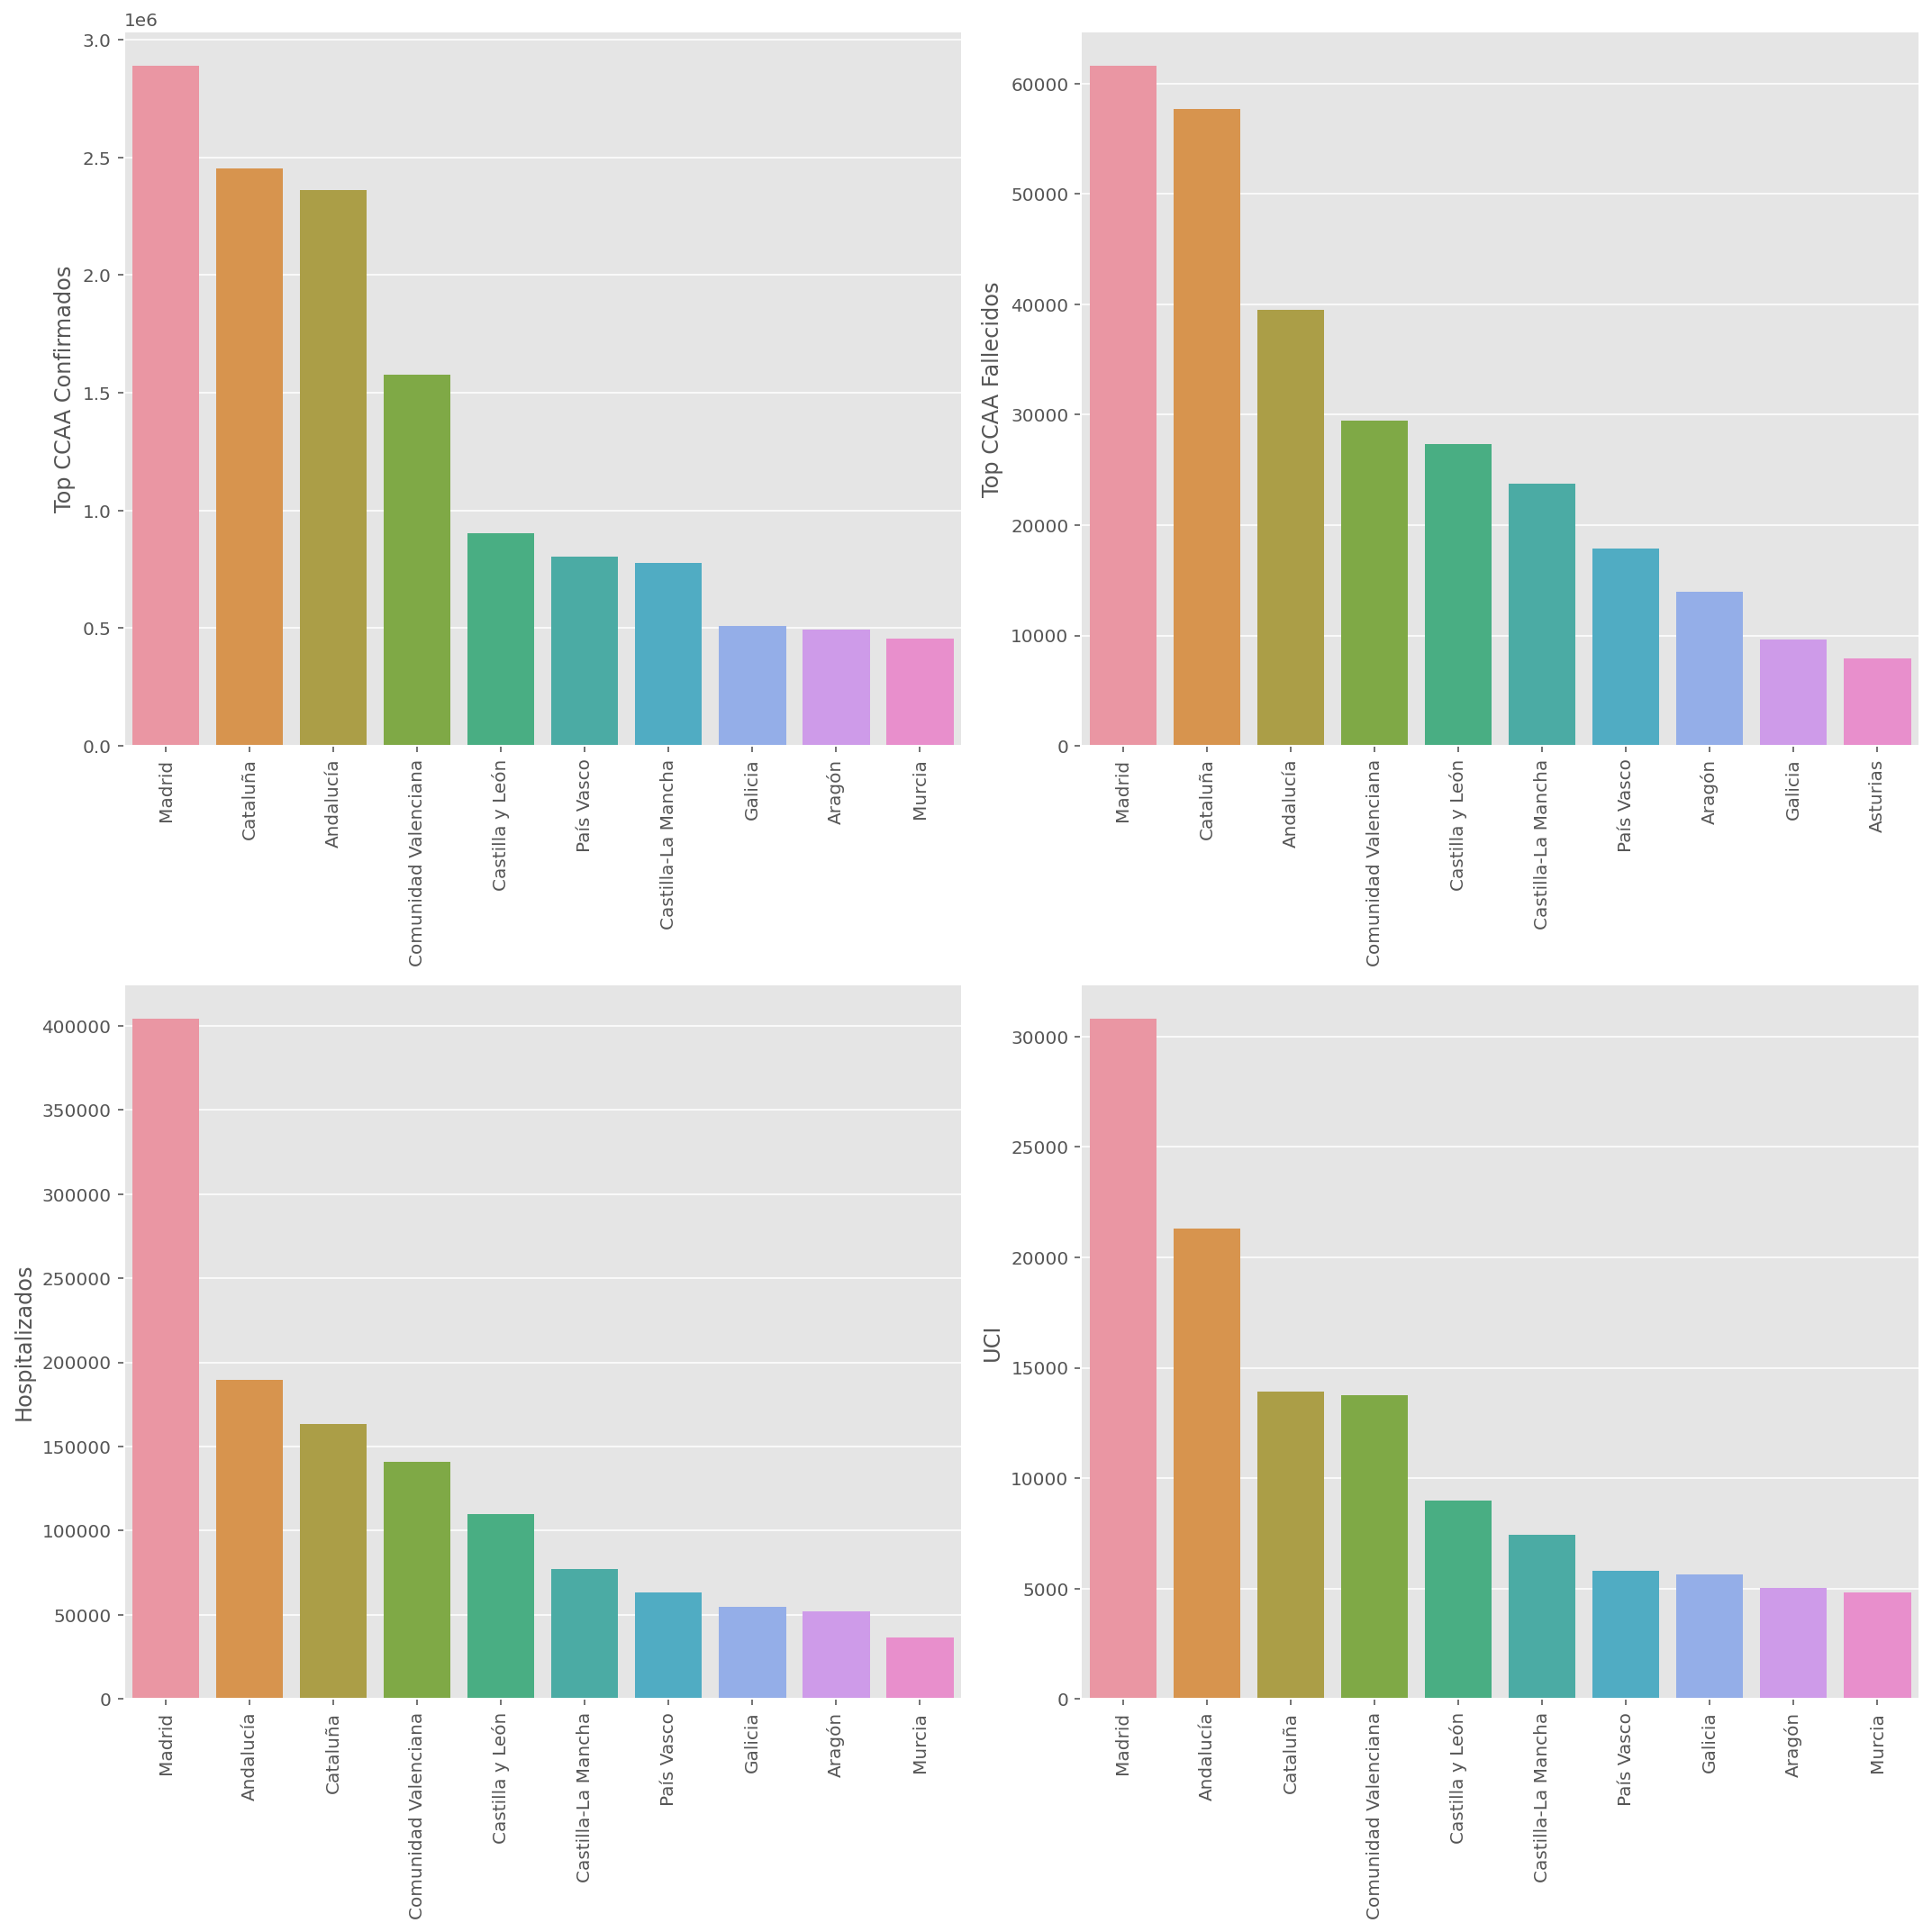

In [285]:
fig, axs = plt.subplots(2,2,figsize = (15,15))

# densidad poblacional  -top 10 de paises

top10_confirmados = df_cm.groupby('ccaa').sum().sort_values('confirmados', ascending=False).head(10)
plt1 = sns.barplot(x=top10_confirmados.index, y='confirmados', data= top10_confirmados, ax = axs[0,0])
plt1.set(xlabel = '', ylabel= 'Top CCAA Confirmados')

# Pobrza extrema -top 10 de paises
top10_fallecidos = df_cm.groupby('ccaa').sum().sort_values('fallecidos', ascending=False).head(10)
plt1 = sns.barplot(x=top10_fallecidos.index, y='fallecidos', data= top10_fallecidos, ax = axs[0,1])
plt1.set(xlabel = '', ylabel= 'Top CCAA Fallecidos')

# Esperanza de vida: paises con la esperanza mas baja
bottom10_hospitalizados = df_cm.groupby('ccaa').sum().sort_values('hospitalizados', ascending=False).head(10)
plt1 = sns.barplot(x=bottom10_hospitalizados.index, y='hospitalizados', data= bottom10_hospitalizados, ax = axs[1,0])
plt1.set(xlabel = '', ylabel= 'Hospitalizados')

# Producto Interno Bruto PIB -últimos 10 paises

bottom10_uci = df_cm.groupby('ccaa').sum().sort_values('uci', ascending=False).head(10)
plt1 = sns.barplot(x=bottom10_hospitalizados.index, y='uci', data= bottom10_uci, ax = axs[1,1])
plt1.set(xlabel = '', ylabel= 'UCI')

for ax in fig.axes:
    plt.sca(ax)
    plt.xticks(rotation = 90)
    
plt.tight_layout()
plt.savefig('eda')
plt.show()

## Análisis Confirmados

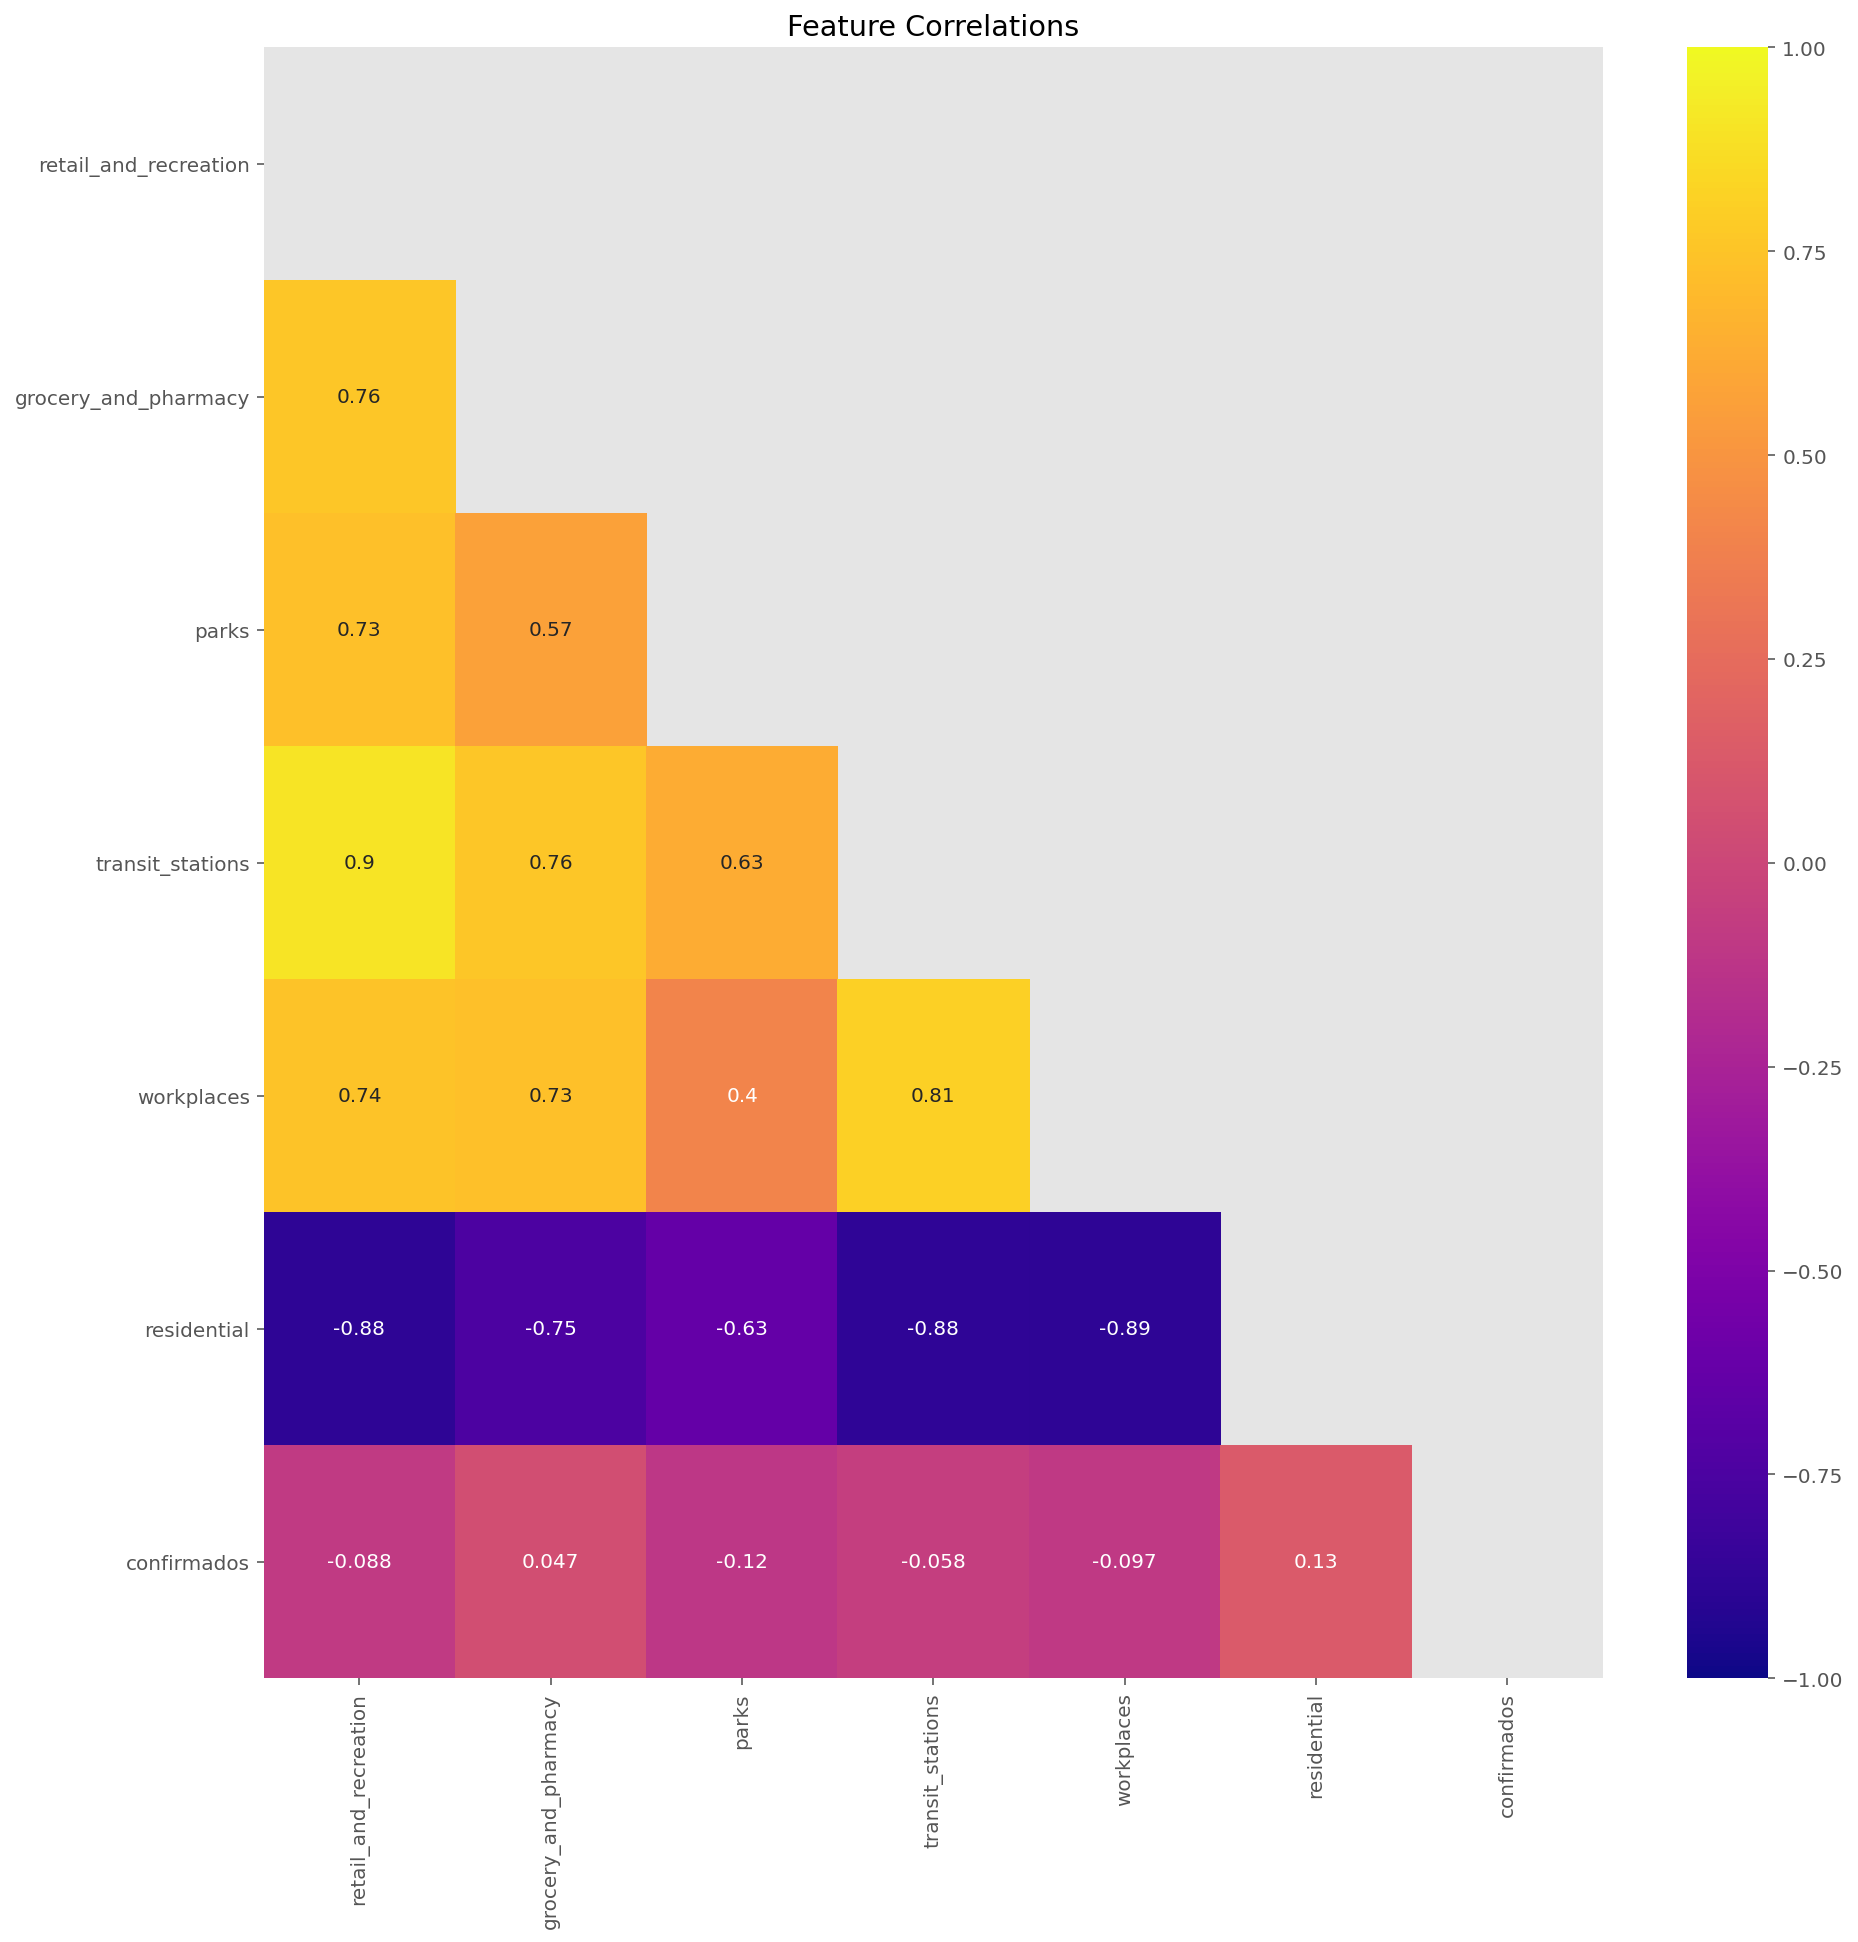

In [286]:
# Validación correlaciones con la variable dependiente
colormap = plt.cm.plasma
matrix1 = np.triu(df_confirmados.corr())
plt.figure(figsize=(15, 15))
sns.heatmap(df_confirmados.corr(), annot=True, vmax=1, vmin=-1, mask=matrix1, cmap=colormap)
plt.title("Feature Correlations")
plt.show()

In [358]:
#Selección de variables

df_confirmados_ = df_confirmados[['ccaa', 'retail_and_recreation', 'grocery_and_pharmacy',
       'transit_stations', 'workplaces', 'residential', 'confirmados']].copy()

# Normalización de cada columna con valores 0 a 20
for i in df_confirmados_.iloc[:,4:]:
  df_confirmados_[i]=((df_confirmados_[i]-df_confirmados_[i].min()) / 
              (df_confirmados_[i].max()-df_confirmados_[i].min()))*20 #Modificar 20 si se requiere más o menos

df_confirmados_.describe()

,retail_and_recreation,grocery_and_pharmacy,transit_stations,workplaces,residential,confirmados
count,"9,468.00","9,468.00","9,468.00","9,468.00","9,468.00","9,468.00"
mean,-31.38,-6.37,-27.22,11.97,5.57,0.81
std,26.20,21.59,24.34,3.51,3.10,1.75
min,-97.00,-94.00,-93.00,0.00,0.00,0.00
25%,-42.00,-12.00,-39.00,10.43,3.40,0.03
50%,-27.00,0.00,-25.00,12.70,4.91,0.21
75%,-14.00,5.00,-11.58,14.26,6.54,0.75
max,56.00,121.00,52.00,20.00,20.00,20.00


In [359]:
# Matriz de correlación

corr_var = df_confirmados_.corr(method="spearman",)
print("Matriz de correlación de Spearman:")
print("="*60)
corr_var.style.background_gradient(cmap='coolwarm')

Matriz de correlación de Spearman:


,retail_and_recreation,grocery_and_pharmacy,transit_stations,workplaces,residential,confirmados
retail_and_recreation,1.000000,0.624654,0.828732,0.615056,-0.843610,-0.340997
grocery_and_pharmacy,0.624654,1.000000,0.673971,0.545541,-0.589986,0.086204
transit_stations,0.828732,0.673971,1.000000,0.734471,-0.831846,-0.231548
workplaces,0.615056,0.545541,0.734471,1.000000,-0.828672,-0.262807
residential,-0.843610,-0.589986,-0.831846,-0.828672,1.000000,0.372709
confirmados,-0.340997,0.086204,-0.231548,-0.262807,0.372709,1.000000


In [360]:
cols_needed1=['retail_and_recreation', 'grocery_and_pharmacy',
       'transit_stations', 'workplaces', 'residential', 'confirmados']

In [361]:
#data2=data2[~data2.ccaa.isin(excluded_cntry)]
if len(cols_needed1)==0:
    data2_sub1=df_confirmados_.select_dtypes(include='float')
else:
    data2_sub1=df_confirmados_[cols_needed1]
data2_sub1=pd.concat([data2_sub1,df_confirmados_[['ccaa']]],axis=1)
data2_sub1=data2_sub1.groupby('ccaa').mean().reset_index()
data2_sub1.fillna(0,inplace=True)

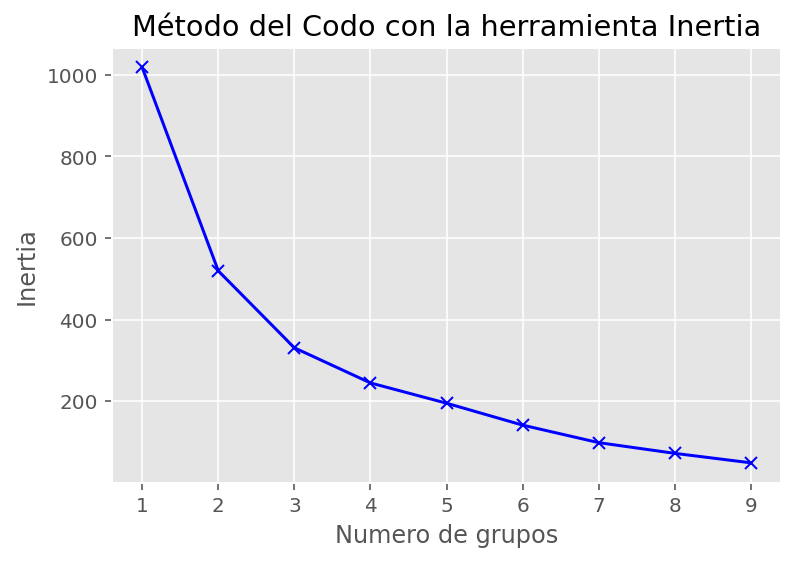

In [362]:
inertias = [] 
K = range(1,10) 
  
for k in K: 
    #Building and fitting the model 
    kmeanModel = KMeans(n_clusters=k).fit(data2_sub1.drop(['ccaa'],axis=1)) 
    kmeanModel.fit(data2_sub1.drop(['ccaa'],axis=1))     
    inertias.append(kmeanModel.inertia_) 
    
plt.plot(K, inertias, 'bx-') 
plt.xlabel('Numero de grupos') 
plt.ylabel('Inertia') 
plt.title('Método del Codo con la herramienta Inertia') 
plt.show()

In [363]:
# ajustado el algoritmo Kmeans ak conjunto de datos
from sklearn.cluster import KMeans

## Numero de clústers a utilizar. En este caso 4 clústers
kmeans = KMeans(n_clusters = 4, init = 'k-means++', random_state = 42)
y_kmeans = kmeans.fit_predict(data2_sub1.drop(['ccaa'],axis=1))
y_kmeans1=y_kmeans+1
cluster = pd.DataFrame(y_kmeans1)
today_sub1=data2_sub1.drop(['ccaa'],axis=1)
# Adding cluster to the Dataset
today_sub1['cluster'] = cluster
#Mean of clusters
kmeans_mean_cluster = pd.DataFrame(round(today_sub1.groupby('cluster').mean(),1))

## Identificación de los valores promedio ( centroides) 
kmeans_mean_cluster

,retail_and_recreation,grocery_and_pharmacy,transit_stations,workplaces,residential,confirmados
cluster,,,,,,
1,-31.50,-4.40,-29.70,12.10,5.50,0.60
2,-28.00,-3.40,-17.20,12.50,5.10,0.20
3,-31.00,-5.30,-24.70,12.00,5.50,1.10
4,-34.40,-14.80,-34.80,11.30,6.20,1.00


In [364]:
today_Sub_2a=pd.concat([data2_sub1[['ccaa']],today_sub1],axis=1)
today_Sub_2a.head(5)

,ccaa,retail_and_recreation,grocery_and_pharmacy,transit_stations,workplaces,residential,confirmados,cluster
0,Andalucía,-29.19,-6.51,-24.43,12.23,5.35,2.34,3
1,Aragón,-30.28,-3.92,-31.91,12.28,5.24,0.49,1
2,Asturias,-31.70,-4.76,-23.73,11.84,5.37,0.21,3
3,Canarias,-36.47,-17.00,-34.79,11.20,6.37,0.22,4
4,Cantabria,-24.55,-0.74,-19.76,12.39,5.42,0.12,2


In [365]:
for i in range(1,5):
    print('****Comunidades autónomas en el grupo {}*****'.format(str(i)))
    print(list(today_Sub_2a[today_Sub_2a.cluster==i]['ccaa'].values))

****Comunidades autónomas en el grupo 1*****
['Aragón', 'Castilla-La Mancha', 'Comunidad Valenciana', 'Galicia', 'La Rioja', 'Navarra']
****Comunidades autónomas en el grupo 2*****
['Cantabria', 'Extremadura']
****Comunidades autónomas en el grupo 3*****
['Andalucía', 'Asturias', 'Castilla y León', 'Cataluña', 'Islas Baleares', 'Murcia', 'País Vasco']
****Comunidades autónomas en el grupo 4*****
['Canarias', 'Ceuta y Melilla', 'Madrid']


In [366]:
#import plotly.express as px
fig = px.treemap(today_Sub_2a, path=['cluster','ccaa'], values='confirmados')
fig.update_layout(autosize=False,width=800,height=700)

fig.show()


In [367]:
# creando los grupos
hc = AgglomerativeClustering(n_clusters=4, affinity = 'euclidean', linkage = 'ward')# save clusters for chart
y_hc = hc.fit_predict(data2_sub1.drop(['ccaa'],axis=1))

In [368]:
heirarchy1=data2_sub1.copy()
heirarchy1['cluster'] = y_hc

In [369]:
# Aca se anota el número de clústers si se desea poner de forma manual 
for i in range(4):
    print('****Nombre de las comunidades autónomas en cluster {}*****'.format(str(i)))
    print(list(heirarchy1[heirarchy1.cluster==i]['ccaa'].values))

****Nombre de las comunidades autónomas en cluster 0*****
['Canarias', 'Ceuta y Melilla', 'Madrid']
****Nombre de las comunidades autónomas en cluster 1*****
['Andalucía', 'Asturias', 'Castilla y León', 'Castilla-La Mancha', 'Cataluña', 'Comunidad Valenciana', 'Islas Baleares', 'Murcia', 'País Vasco']
****Nombre de las comunidades autónomas en cluster 2*****
['Cantabria', 'Extremadura']
****Nombre de las comunidades autónomas en cluster 3*****
['Aragón', 'Galicia', 'La Rioja', 'Navarra']


In [370]:
# grafico de los grupos de países
fig = px.treemap(heirarchy1, path=['cluster','ccaa'], values='confirmados')
fig.update_layout(autosize=False,width=800,height=700)
fig.show()

## Análisis Hospitalizados

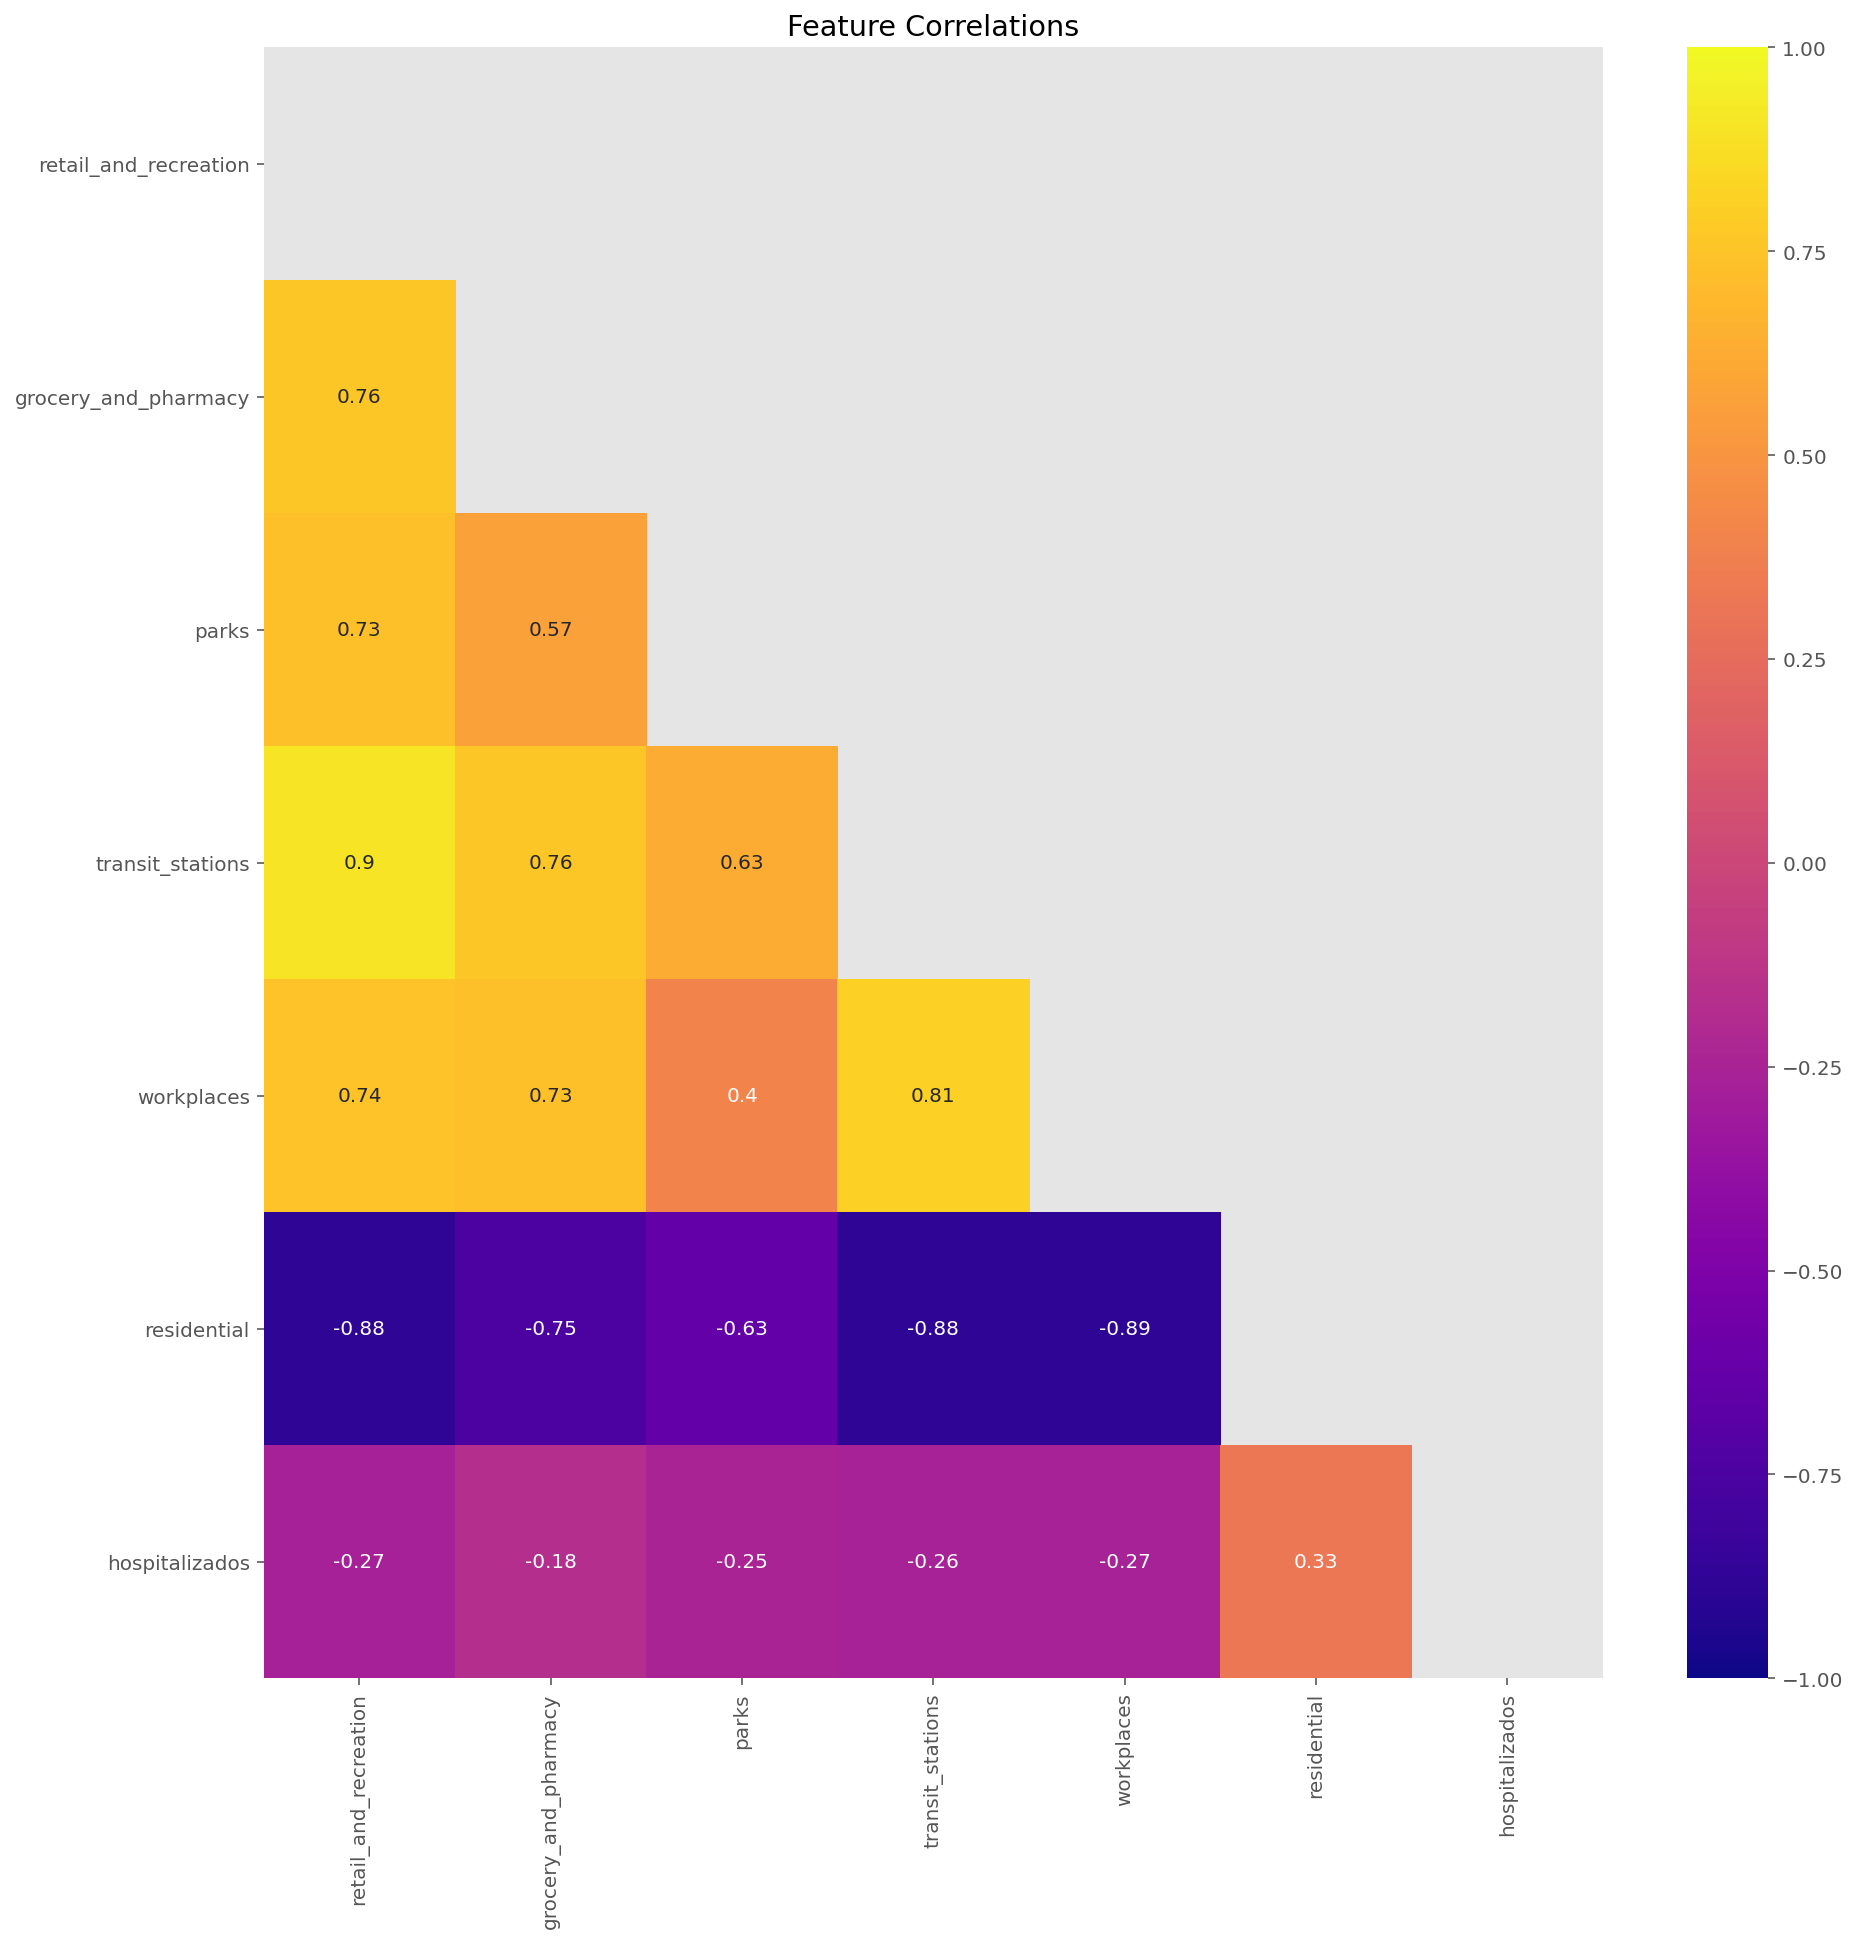

In [371]:
# Validación correlaciones con la variable dependiente
colormap = plt.cm.plasma
matrix1 = np.triu(df_hospitalizados.corr())
plt.figure(figsize=(15, 15))
sns.heatmap(df_hospitalizados.corr(), annot=True, vmax=1, vmin=-1, mask=matrix1, cmap=colormap)
plt.title("Feature Correlations")
plt.show()

In [372]:
#Selección de variables

df_hospitalizados_ = df_hospitalizados[['ccaa', 'retail_and_recreation', 'grocery_and_pharmacy',
       'transit_stations', 'workplaces', 'residential', 'hospitalizados']].copy()

# Normalización de cada columna con valores 0 a 20
for i in df_hospitalizados_.iloc[:,4:]:
  df_hospitalizados_[i]=((df_hospitalizados_[i]-df_hospitalizados_[i].min()) / 
              (df_hospitalizados_[i].max()-df_hospitalizados_[i].min()))*20 #Modificar 20 si se requiere más o menos

df_hospitalizados_.describe()

,retail_and_recreation,grocery_and_pharmacy,transit_stations,workplaces,residential,hospitalizados
count,"9,468.00","9,468.00","9,468.00","9,468.00","9,468.00","9,468.00"
mean,-31.38,-6.37,-27.22,11.97,5.57,0.40
std,26.20,21.59,24.34,3.51,3.10,0.97
min,-97.00,-94.00,-93.00,0.00,0.00,0.00
25%,-42.00,-12.00,-39.00,10.43,3.40,0.02
50%,-27.00,0.00,-25.00,12.70,4.91,0.10
75%,-14.00,5.00,-11.58,14.26,6.54,0.35
max,56.00,121.00,52.00,20.00,20.00,20.00


In [373]:
# Matriz de correlación

corr_var = df_hospitalizados_.corr(method="spearman",)
print("Matriz de correlación de Spearman:")
print("="*60)
corr_var.style.background_gradient(cmap='coolwarm')

Matriz de correlación de Spearman:


,retail_and_recreation,grocery_and_pharmacy,transit_stations,workplaces,residential,hospitalizados
retail_and_recreation,1.000000,0.624654,0.828732,0.615056,-0.843610,-0.438590
grocery_and_pharmacy,0.624654,1.000000,0.673971,0.545541,-0.589986,-0.035233
transit_stations,0.828732,0.673971,1.000000,0.734471,-0.831846,-0.318998
workplaces,0.615056,0.545541,0.734471,1.000000,-0.828672,-0.306054
residential,-0.843610,-0.589986,-0.831846,-0.828672,1.000000,0.446918
hospitalizados,-0.438590,-0.035233,-0.318998,-0.306054,0.446918,1.000000


In [374]:

cols_needed2=['retail_and_recreation', 'grocery_and_pharmacy',
       'transit_stations', 'workplaces', 'residential', 'hospitalizados']

In [376]:

#data2=data2[~data2.ccaa.isin(excluded_cntry)]
if len(cols_needed2)==0:
    data2_sub2=df_hospitalizados_.select_dtypes(include='float')
else:
    data2_sub2=df_hospitalizados_[cols_needed2]
data2_sub2=pd.concat([data2_sub2,df_hospitalizados_[['ccaa']]],axis=1)
data2_sub2=data2_sub2.groupby('ccaa').mean().reset_index()
data2_sub2.fillna(0,inplace=True)

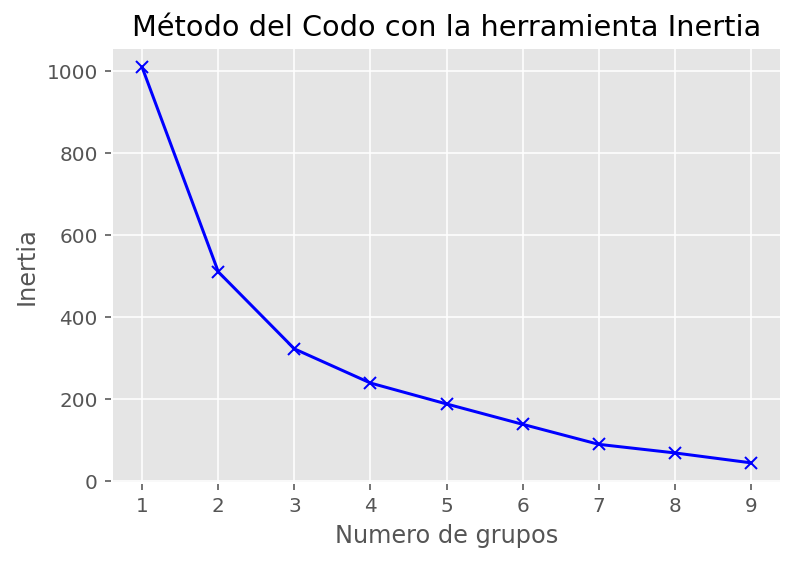

In [377]:
inertias = [] 
K = range(1,10) 
  
for k in K: 
    #Building and fitting the model 
    kmeanModel = KMeans(n_clusters=k).fit(data2_sub2.drop(['ccaa'],axis=1)) 
    kmeanModel.fit(data2_sub2.drop(['ccaa'],axis=1))     
    inertias.append(kmeanModel.inertia_) 
    
plt.plot(K, inertias, 'bx-') 
plt.xlabel('Numero de grupos') 
plt.ylabel('Inertia') 
plt.title('Método del Codo con la herramienta Inertia') 
plt.show()

In [378]:
# ajustado el algoritmo Kmeans ak conjunto de datos
from sklearn.cluster import KMeans

## Numero de clústers a utilizar. En este caso 4 clústers
kmeans = KMeans(n_clusters = 4, init = 'k-means++', random_state = 42)
y_kmeans = kmeans.fit_predict(data2_sub2.drop(['ccaa'],axis=1))
y_kmeans1=y_kmeans+1
cluster = pd.DataFrame(y_kmeans1)
today_sub2=data2_sub2.drop(['ccaa'],axis=1)
# Adding cluster to the Dataset
today_sub2['cluster'] = cluster
#Mean of clusters
kmeans_mean_cluster = pd.DataFrame(round(today_sub2.groupby('cluster').mean(),1))

## Identificación de los valores promedio ( centroides) 
kmeans_mean_cluster

,retail_and_recreation,grocery_and_pharmacy,transit_stations,workplaces,residential,hospitalizados
cluster,,,,,,
1,-31.50,-4.40,-29.70,12.10,5.50,0.30
2,-28.00,-3.40,-17.20,12.50,5.10,0.10
3,-31.00,-5.30,-24.70,12.00,5.50,0.40
4,-34.40,-14.80,-34.80,11.30,6.20,0.70


In [379]:
today_Sub_2b=pd.concat([data2_sub2[['ccaa']],today_sub2],axis=1)
today_Sub_2b.head(5)

,ccaa,retail_and_recreation,grocery_and_pharmacy,transit_stations,workplaces,residential,hospitalizados,cluster
0,Andalucía,-29.19,-6.51,-24.43,12.23,5.35,0.93,3
1,Aragón,-30.28,-3.92,-31.91,12.28,5.24,0.26,1
2,Asturias,-31.70,-4.76,-23.73,11.84,5.37,0.17,3
3,Canarias,-36.47,-17.00,-34.79,11.20,6.37,0.11,4
4,Cantabria,-24.55,-0.74,-19.76,12.39,5.42,0.07,2


In [380]:
for i in range(1,5):
    print('****Comunidades autónomas en el grupo {}*****'.format(str(i)))
    print(list(today_Sub_2b[today_Sub_2b.cluster==i]['ccaa'].values))

****Comunidades autónomas en el grupo 1*****
['Aragón', 'Castilla-La Mancha', 'Comunidad Valenciana', 'Galicia', 'La Rioja', 'Navarra']
****Comunidades autónomas en el grupo 2*****
['Cantabria', 'Extremadura']
****Comunidades autónomas en el grupo 3*****
['Andalucía', 'Asturias', 'Castilla y León', 'Cataluña', 'Islas Baleares', 'Murcia', 'País Vasco']
****Comunidades autónomas en el grupo 4*****
['Canarias', 'Ceuta y Melilla', 'Madrid']


In [381]:
#import plotly.express as px
fig = px.treemap(today_Sub_2b, path=['cluster','ccaa'], values='hospitalizados')
fig.update_layout(autosize=False,width=800,height=700)

fig.show()

In [382]:
# creando los grupos
hc = AgglomerativeClustering(n_clusters=4, affinity = 'euclidean', linkage = 'ward')# save clusters for chart
y_hc = hc.fit_predict(data2_sub2.drop(['ccaa'],axis=1))

In [383]:
heirarchy2=data2_sub2.copy()
heirarchy2['cluster'] = y_hc

In [384]:
# Aca se anota el número de clústers si se desea poner de forma manual 
for i in range(4):
    print('****Nombre de las comunidades autónomas en cluster {}*****'.format(str(i)))
    print(list(heirarchy2[heirarchy2.cluster==i]['ccaa'].values))

****Nombre de las comunidades autónomas en cluster 0*****
['Cantabria', 'Extremadura']
****Nombre de las comunidades autónomas en cluster 1*****
['Canarias', 'Ceuta y Melilla', 'Madrid']
****Nombre de las comunidades autónomas en cluster 2*****
['Andalucía', 'Asturias', 'Castilla y León', 'Castilla-La Mancha', 'Cataluña', 'Comunidad Valenciana', 'Islas Baleares', 'Murcia', 'País Vasco']
****Nombre de las comunidades autónomas en cluster 3*****
['Aragón', 'Galicia', 'La Rioja', 'Navarra']


In [385]:
# grafico de los grupos de países
fig = px.treemap(heirarchy2, path=['cluster','ccaa'], values='hospitalizados')
fig.update_layout(autosize=False,width=800,height=700)
fig.show()

## Análisis UCI

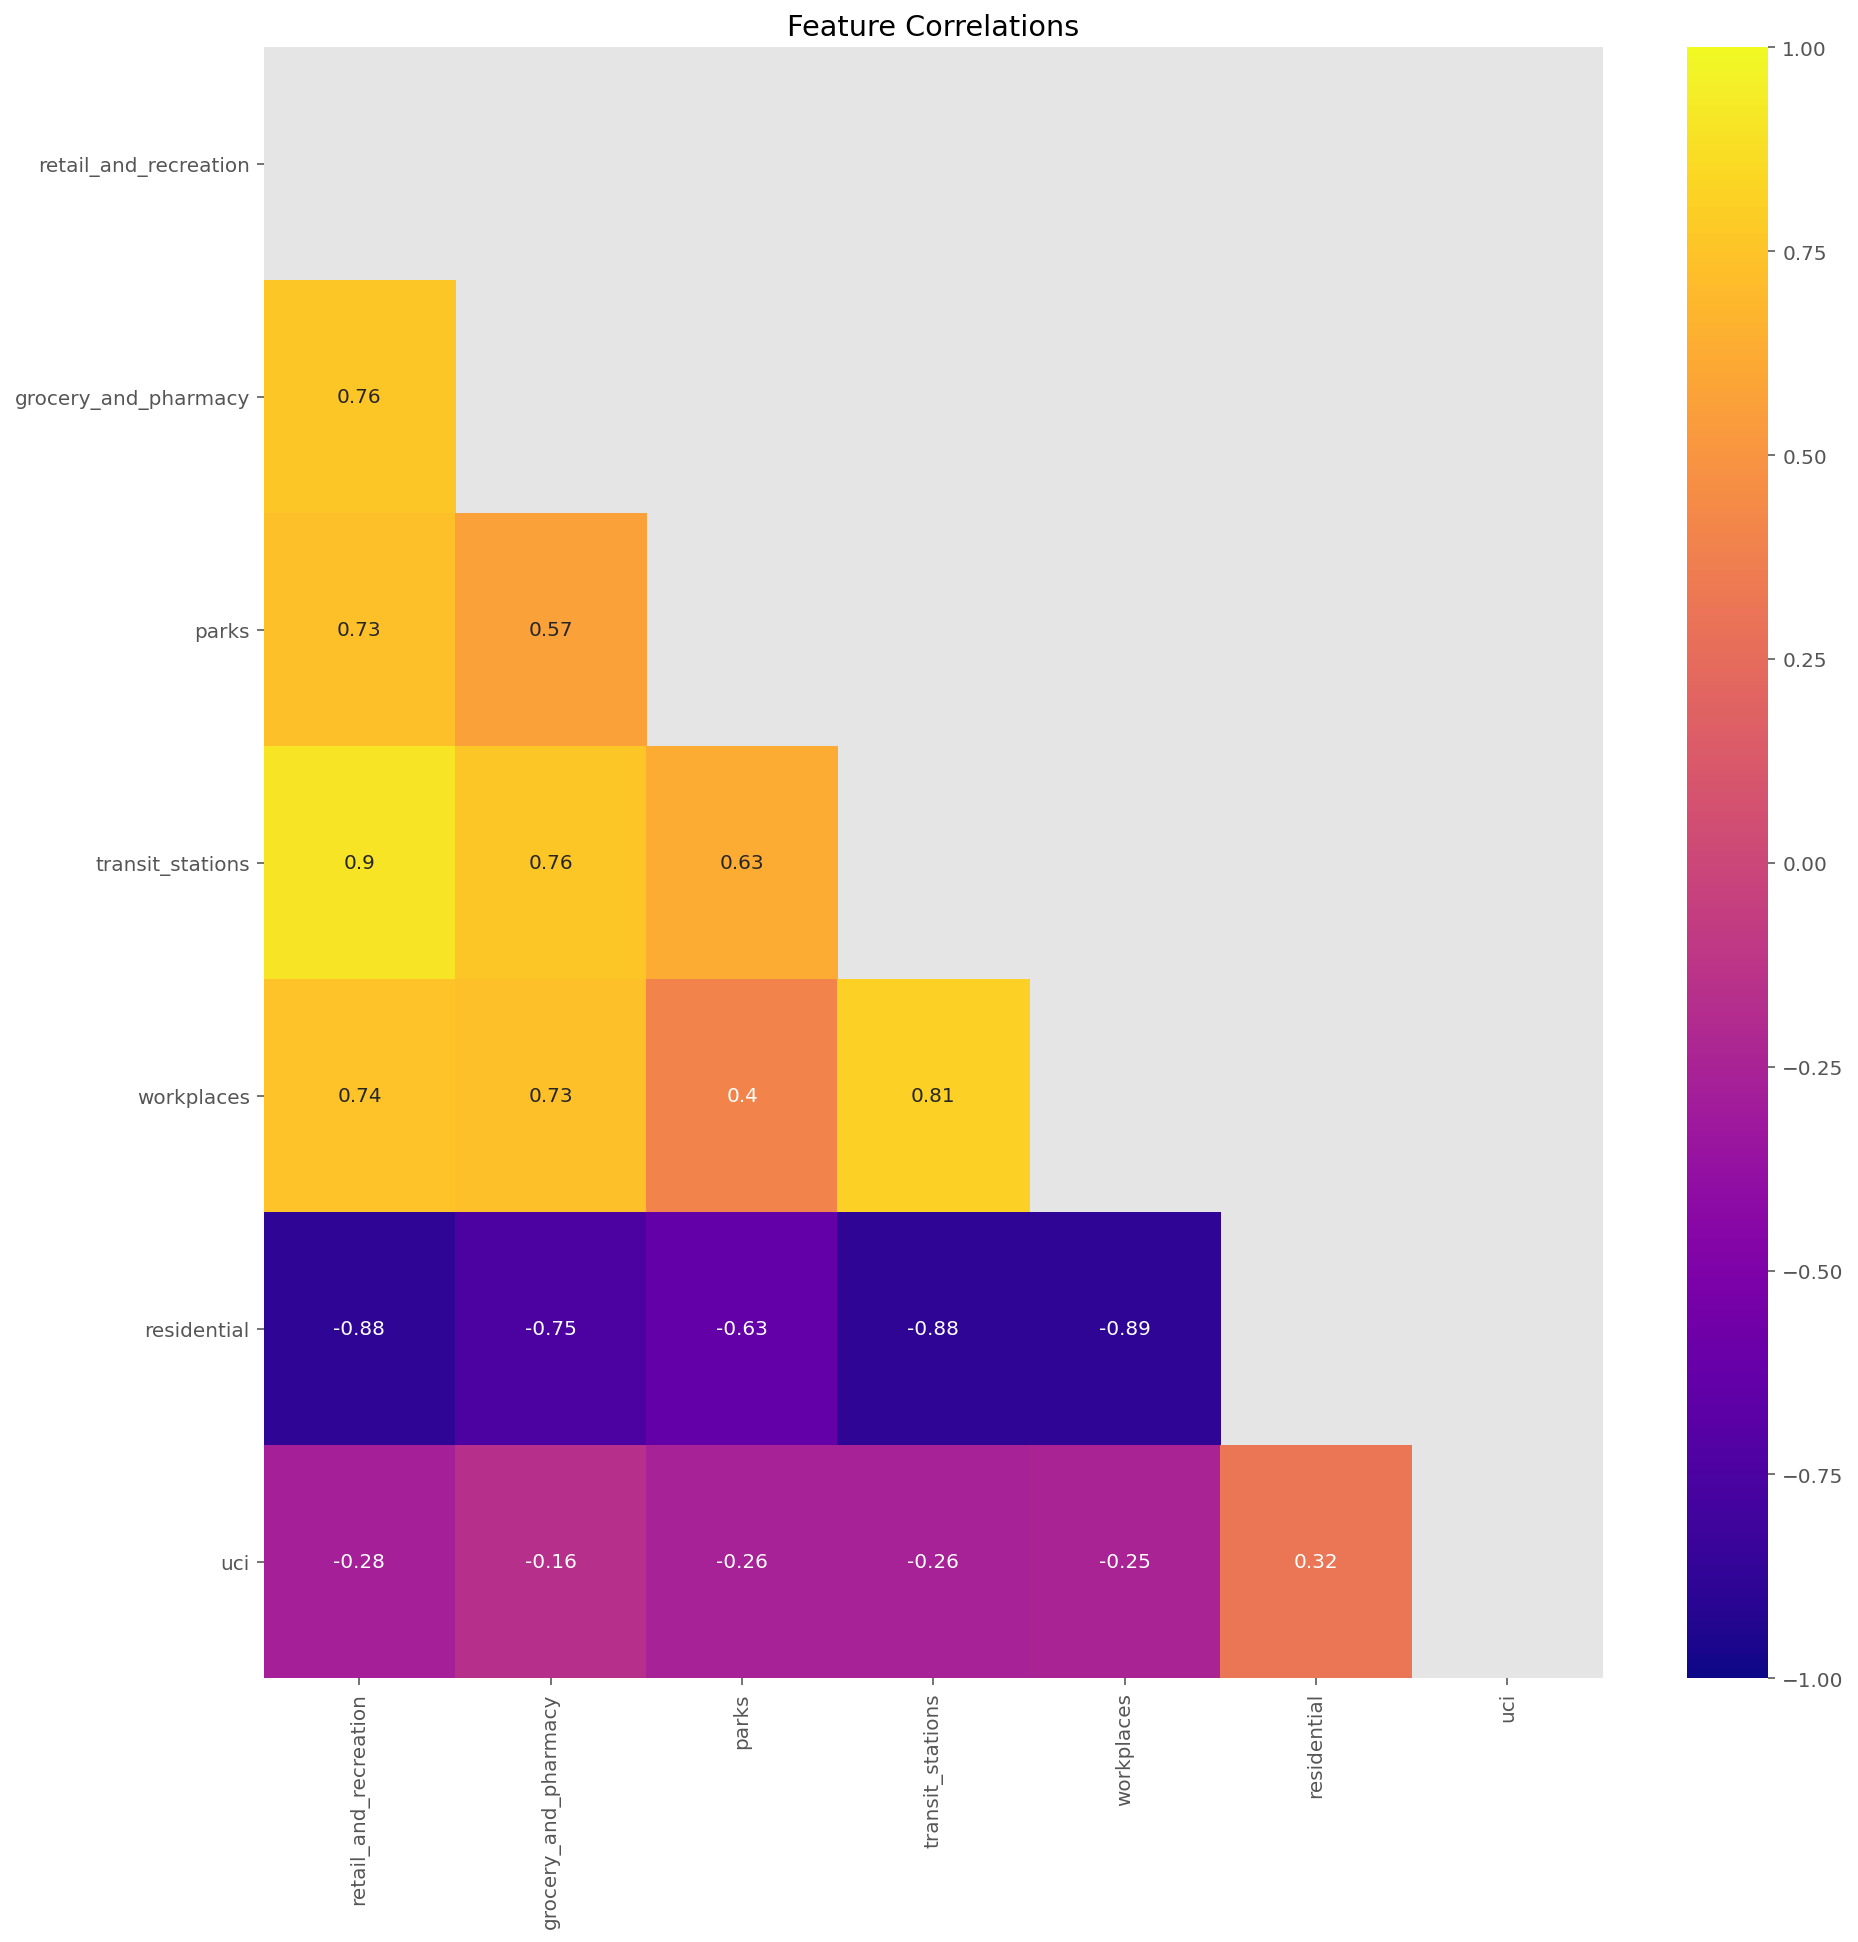

In [314]:
# Validación correlaciones con la variable dependiente
colormap = plt.cm.plasma
matrix1 = np.triu(df_uci.corr())
plt.figure(figsize=(15, 15))
sns.heatmap(df_uci.corr(), annot=True, vmax=1, vmin=-1, mask=matrix1, cmap=colormap)
plt.title("Feature Correlations")
plt.show()

In [386]:
#Selección de variables

df_uci_ = df_uci[['ccaa', 'retail_and_recreation', 'grocery_and_pharmacy',
        'transit_stations', 'workplaces', 'residential', 'uci']].copy()

# Normalización de cada columna con valores 0 a 20
for i in df_uci_.iloc[:,4:]:
  df_uci_[i]=((df_uci_[i]-df_uci_[i].min()) / 
              (df_uci_[i].max()-df_uci_[i].min()))*20 #Modificar 20 si se requiere más o menos

df_uci_.describe()

,retail_and_recreation,grocery_and_pharmacy,transit_stations,workplaces,residential,uci
count,"9,468.00","9,468.00","9,468.00","9,468.00","9,468.00","9,468.00"
mean,-31.38,-6.37,-27.22,11.97,5.57,0.53
std,26.20,21.59,24.34,3.51,3.10,1.16
min,-97.00,-94.00,-93.00,0.00,0.00,0.00
25%,-42.00,-12.00,-39.00,10.43,3.40,0.00
50%,-27.00,0.00,-25.00,12.70,4.91,0.15
75%,-14.00,5.00,-11.58,14.26,6.54,0.59
max,56.00,121.00,52.00,20.00,20.00,20.00


In [387]:
# Matriz de correlación

corr_var = df_uci_.corr(method="spearman",)
print("Matriz de correlación de Spearman:")
print("="*60)
corr_var.style.background_gradient(cmap='coolwarm')

Matriz de correlación de Spearman:


,retail_and_recreation,grocery_and_pharmacy,transit_stations,workplaces,residential,uci
retail_and_recreation,1.000000,0.624654,0.828732,0.615056,-0.843610,-0.382753
grocery_and_pharmacy,0.624654,1.000000,0.673971,0.545541,-0.589986,-0.030439
transit_stations,0.828732,0.673971,1.000000,0.734471,-0.831846,-0.271321
workplaces,0.615056,0.545541,0.734471,1.000000,-0.828672,-0.245750
residential,-0.843610,-0.589986,-0.831846,-0.828672,1.000000,0.386478
uci,-0.382753,-0.030439,-0.271321,-0.245750,0.386478,1.000000


In [390]:
cols_needed3=['retail_and_recreation', 'grocery_and_pharmacy',
       'transit_stations', 'workplaces', 'residential', 'uci']

In [391]:
#data2=data2[~data2.ccaa.isin(excluded_cntry)]
if len(cols_needed3)==0:
    data2_sub3=df_uci_.select_dtypes(include='float')
else:
    data2_sub3=df_uci_[cols_needed3]
data2_sub3=pd.concat([data2_sub3,df_uci_[['ccaa']]],axis=1)
data2_sub3=data2_sub3.groupby('ccaa').mean().reset_index()
data2_sub3.fillna(0,inplace=True)

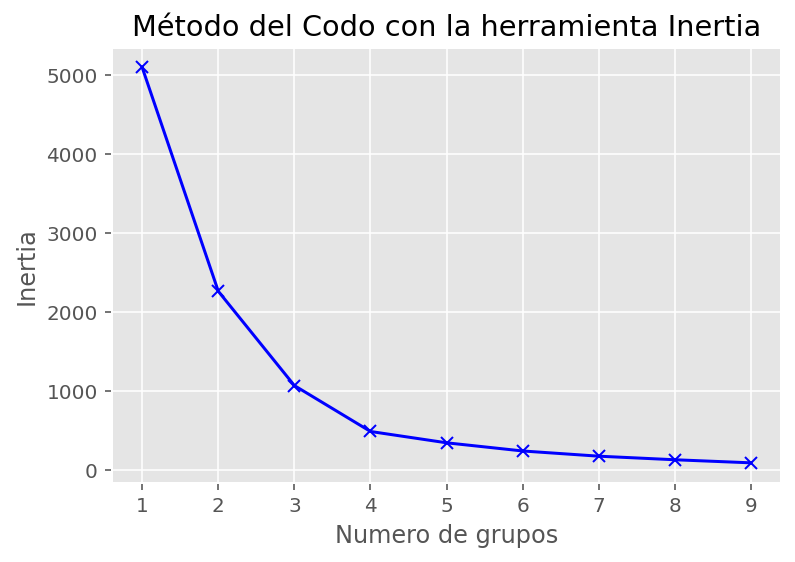

In [319]:
inertias = [] 
K = range(1,10) 
  
for k in K: 
    #Building and fitting the model 
    kmeanModel = KMeans(n_clusters=k).fit(data2_sub3.drop(['ccaa'],axis=1)) 
    kmeanModel.fit(data2_sub3.drop(['ccaa'],axis=1))     
    inertias.append(kmeanModel.inertia_) 
    
plt.plot(K, inertias, 'bx-') 
plt.xlabel('Numero de grupos') 
plt.ylabel('Inertia') 
plt.title('Método del Codo con la herramienta Inertia') 
plt.show()

In [392]:
# ajustado el algoritmo Kmeans ak conjunto de datos
from sklearn.cluster import KMeans

## Numero de clústers a utilizar. En este caso 4 clústers
kmeans = KMeans(n_clusters = 4, init = 'k-means++', random_state = 42)
y_kmeans = kmeans.fit_predict(data2_sub3.drop(['ccaa'],axis=1))
y_kmeans1=y_kmeans+1
cluster = pd.DataFrame(y_kmeans1)
today_sub3=data2_sub3.drop(['ccaa'],axis=1)
# Adding cluster to the Dataset
today_sub3['cluster'] = cluster
#Mean of clusters
kmeans_mean_cluster = pd.DataFrame(round(today_sub3.groupby('cluster').mean(),1))

## Identificación de los valores promedio ( centroides) 
kmeans_mean_cluster

,retail_and_recreation,grocery_and_pharmacy,transit_stations,workplaces,residential,uci
cluster,,,,,,
1,-31.50,-4.40,-29.70,12.10,5.50,0.40
2,-28.00,-3.40,-17.20,12.50,5.10,0.10
3,-31.00,-5.30,-24.70,12.00,5.50,0.60
4,-34.40,-14.80,-34.80,11.30,6.20,0.80


In [393]:
today_Sub_2c=pd.concat([data2_sub3[['ccaa']],today_sub3],axis=1)
today_Sub_2c.head(5)

,ccaa,retail_and_recreation,grocery_and_pharmacy,transit_stations,workplaces,residential,uci,cluster
0,Andalucía,-29.19,-6.51,-24.43,12.23,5.35,1.50,3
1,Aragón,-30.28,-3.92,-31.91,12.28,5.24,0.35,1
2,Asturias,-31.70,-4.76,-23.73,11.84,5.37,0.22,3
3,Canarias,-36.47,-17.00,-34.79,11.20,6.37,0.31,4
4,Cantabria,-24.55,-0.74,-19.76,12.39,5.42,0.14,2


In [394]:
for i in range(1,5):
    print('****Comunidades autónomas en el grupo {}*****'.format(str(i)))
    print(list(today_Sub_2c[today_Sub_2c.cluster==i]['ccaa'].values))

****Comunidades autónomas en el grupo 1*****
['Aragón', 'Castilla-La Mancha', 'Comunidad Valenciana', 'Galicia', 'La Rioja', 'Navarra']
****Comunidades autónomas en el grupo 2*****
['Cantabria', 'Extremadura']
****Comunidades autónomas en el grupo 3*****
['Andalucía', 'Asturias', 'Castilla y León', 'Cataluña', 'Islas Baleares', 'Murcia', 'País Vasco']
****Comunidades autónomas en el grupo 4*****
['Canarias', 'Ceuta y Melilla', 'Madrid']


In [395]:
#import plotly.express as px
fig = px.treemap(today_Sub_2c, path=['cluster','ccaa'], values='uci')
fig.update_layout(autosize=False,width=800,height=700)

fig.show()

In [396]:
# creando los grupos
hc = AgglomerativeClustering(n_clusters=4, affinity = 'euclidean', linkage = 'ward')# save clusters for chart
y_hc = hc.fit_predict(data2_sub3.drop(['ccaa'],axis=1))

In [397]:
heirarchy3=data2_sub3.copy()
heirarchy3['cluster'] = y_hc

In [399]:
# Aca se anota el número de clústers si se desea poner de forma manual 
for i in range(4):
    print('****Nombre de las comunidades autónomas en cluster {}*****'.format(str(i)))
    print(list(heirarchy3[heirarchy3.cluster==i]['ccaa'].values))

****Nombre de las comunidades autónomas en cluster 0*****
['Canarias', 'Ceuta y Melilla', 'Madrid']
****Nombre de las comunidades autónomas en cluster 1*****
['Andalucía', 'Asturias', 'Castilla y León', 'Castilla-La Mancha', 'Cataluña', 'Comunidad Valenciana', 'Islas Baleares', 'Murcia', 'País Vasco']
****Nombre de las comunidades autónomas en cluster 2*****
['Cantabria', 'Extremadura']
****Nombre de las comunidades autónomas en cluster 3*****
['Aragón', 'Galicia', 'La Rioja', 'Navarra']


In [400]:
# grafico de los grupos de países
fig = px.treemap(heirarchy3, path=['cluster','ccaa'], values='uci')
fig.update_layout(autosize=False,width=800,height=700)
fig.show()

## Análisis Fallecidos

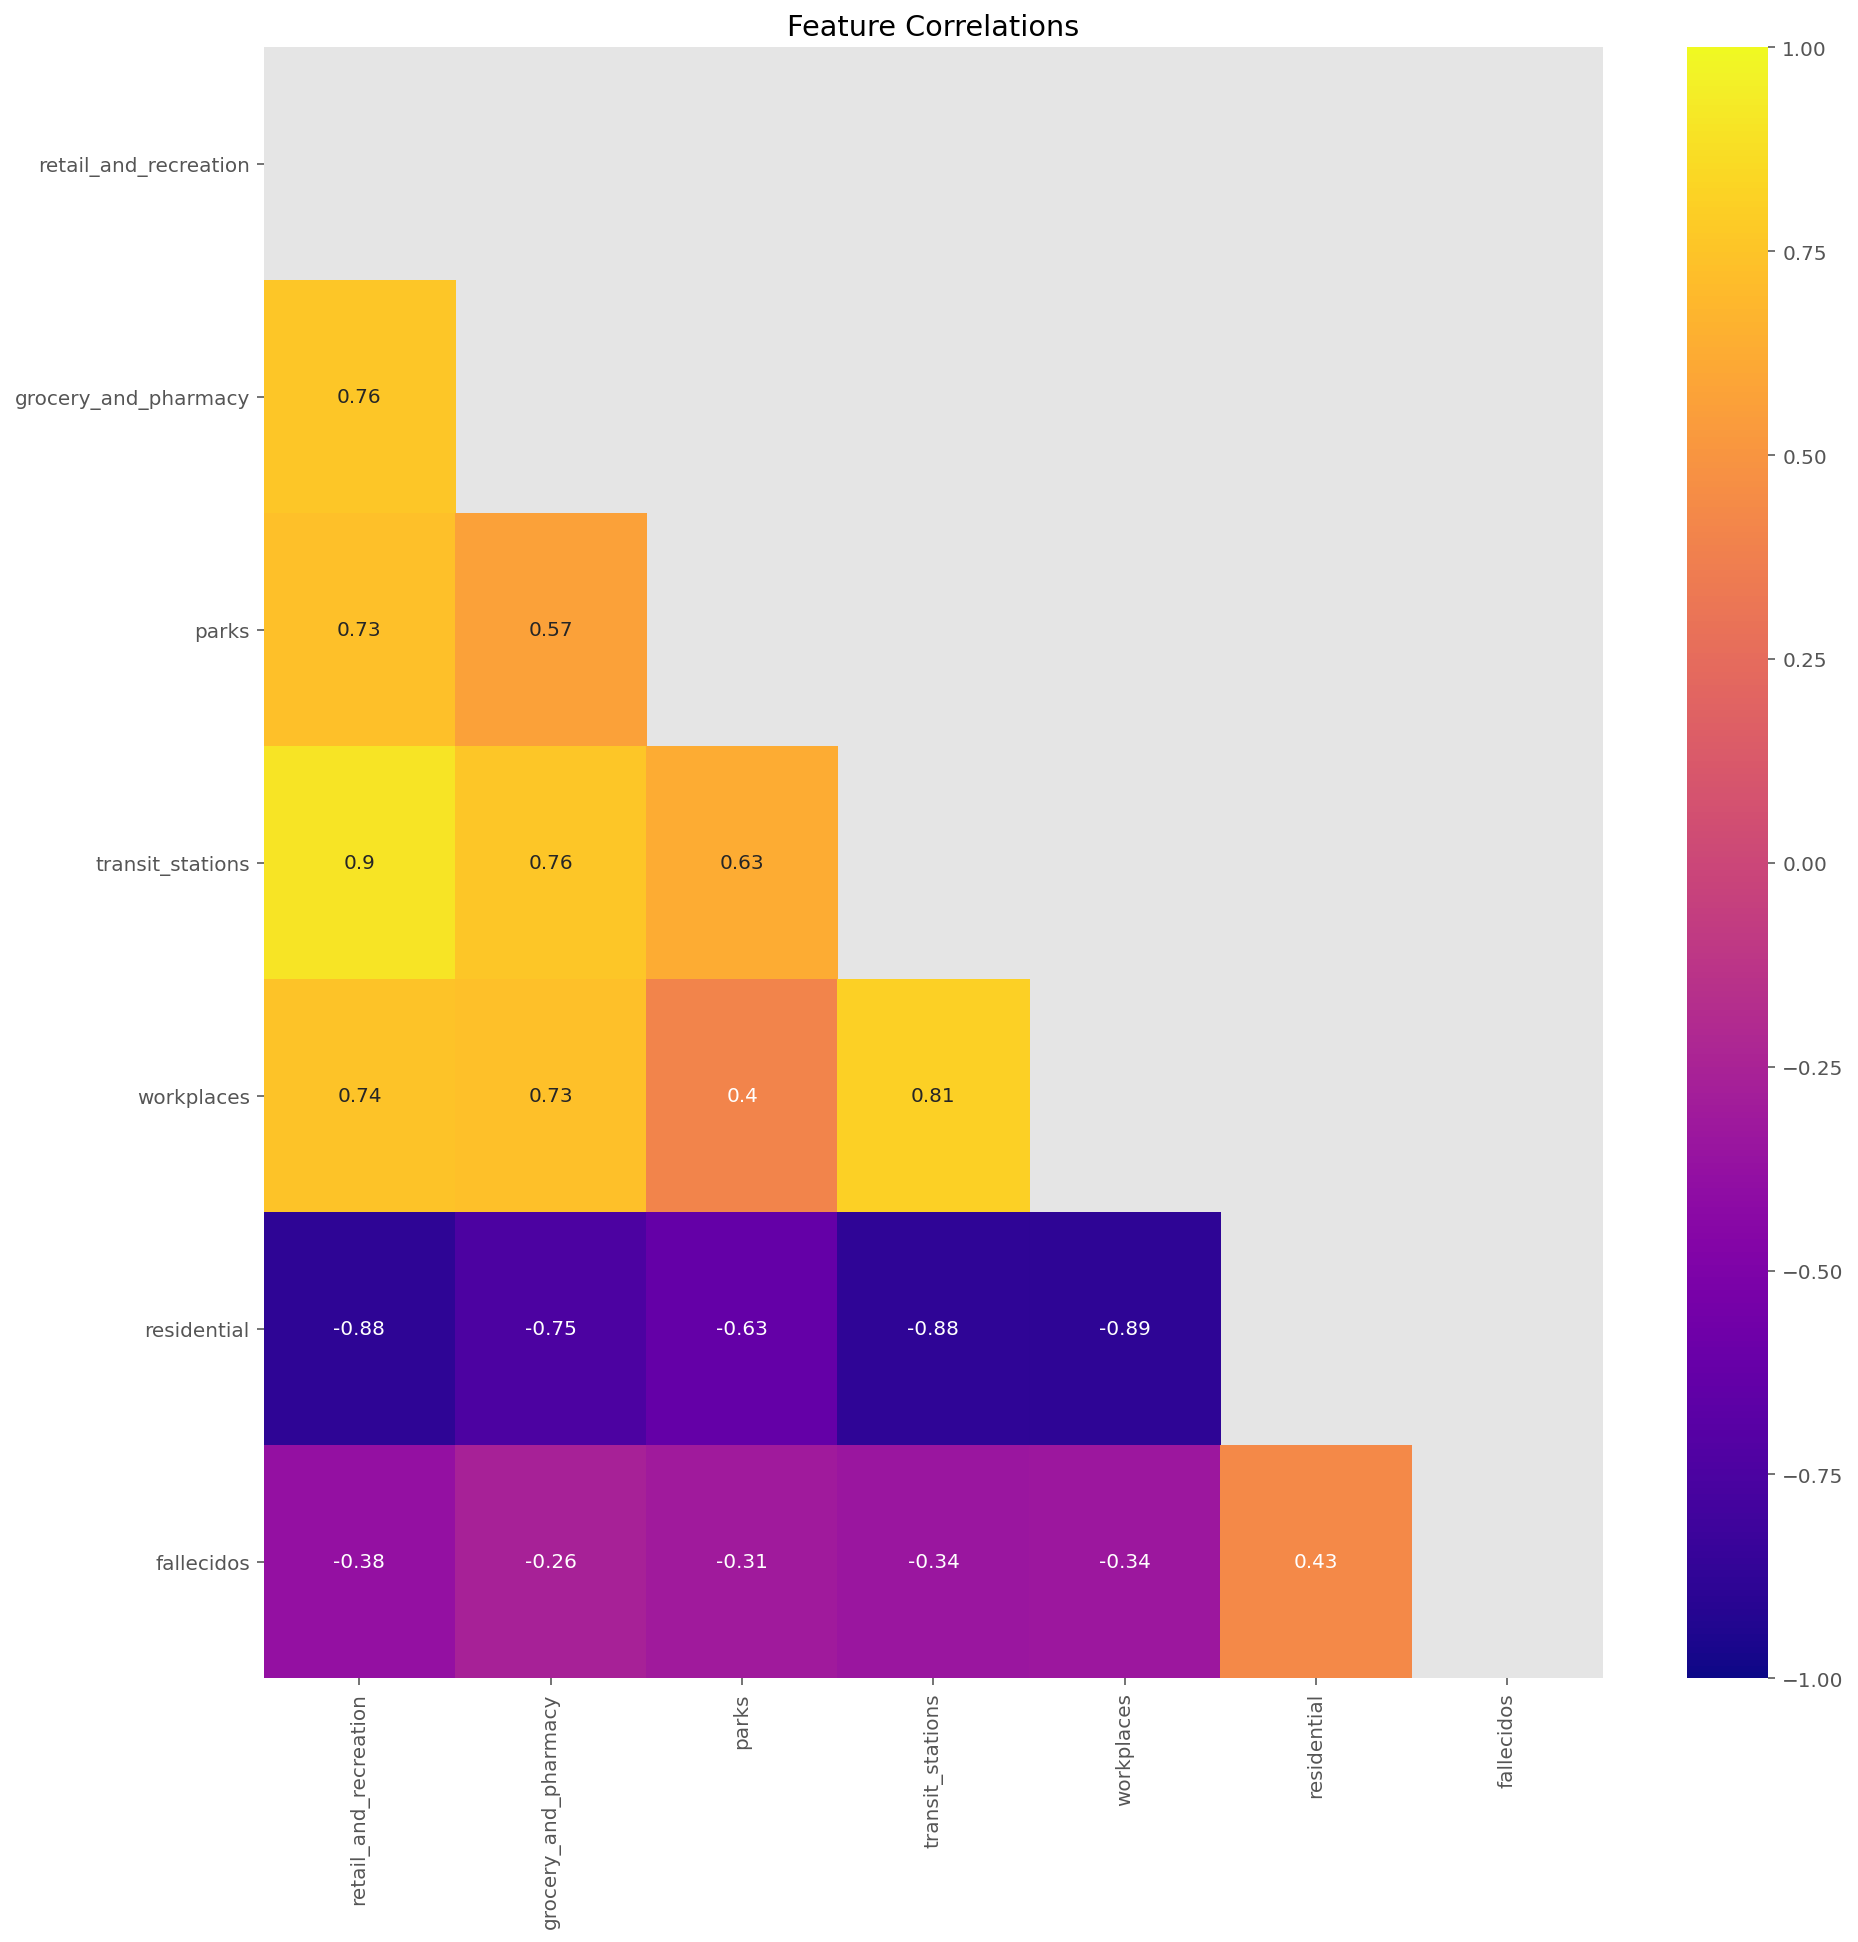

In [328]:
# Validación correlaciones con la variable dependiente
colormap = plt.cm.plasma
matrix1 = np.triu(df_fallecidos.corr())
plt.figure(figsize=(15, 15))
sns.heatmap(df_fallecidos.corr(), annot=True, vmax=1, vmin=-1, mask=matrix1, cmap=colormap)
plt.title("Feature Correlations")
plt.show()

In [345]:
#Selección de variables

df_fallecidos_ = df_fallecidos[['ccaa', 'retail_and_recreation', 'grocery_and_pharmacy',
        'transit_stations', 'workplaces', 'residential', 'fallecidos']].copy()

# Normalización de cada columna con valores 0 a 20
for i in df_fallecidos_.iloc[:,4:]:
  df_fallecidos_[i]=((df_fallecidos_[i]-df_fallecidos_[i].min()) / 
              (df_fallecidos_[i].max()-df_fallecidos_[i].min()))*20 #Modificar 20 si se requiere más o menos

df_fallecidos_.describe()

,retail_and_recreation,grocery_and_pharmacy,transit_stations,workplaces,residential,fallecidos
count,"9,468.00","9,468.00","9,468.00","9,468.00","9,468.00","9,468.00"
mean,-31.38,-6.37,-27.22,11.97,5.57,0.51
std,26.20,21.59,24.34,3.51,3.10,1.20
min,-97.00,-94.00,-93.00,0.00,0.00,0.00
25%,-42.00,-12.00,-39.00,10.43,3.40,0.00
50%,-27.00,0.00,-25.00,12.70,4.91,0.12
75%,-14.00,5.00,-11.58,14.26,6.54,0.48
max,56.00,121.00,52.00,20.00,20.00,20.00


In [346]:
# Matriz de correlación

corr_var = df_fallecidos_.corr(method="spearman",)
print("Matriz de correlación de Spearman:")
print("="*60)
corr_var.style.background_gradient(cmap='coolwarm')

Matriz de correlación de Spearman:


,retail_and_recreation,grocery_and_pharmacy,transit_stations,workplaces,residential,fallecidos
retail_and_recreation,1.000000,0.624654,0.828732,0.615056,-0.843610,-0.551903
grocery_and_pharmacy,0.624654,1.000000,0.673971,0.545541,-0.589986,-0.154715
transit_stations,0.828732,0.673971,1.000000,0.734471,-0.831846,-0.408811
workplaces,0.615056,0.545541,0.734471,1.000000,-0.828672,-0.385679
residential,-0.843610,-0.589986,-0.831846,-0.828672,1.000000,0.562200
fallecidos,-0.551903,-0.154715,-0.408811,-0.385679,0.562200,1.000000


In [347]:
cols_needed4=['retail_and_recreation', 'grocery_and_pharmacy',
       'transit_stations', 'workplaces', 'residential', 'fallecidos']

In [348]:
#data2=data2[~data2.ccaa.isin(excluded_cntry)]
if len(cols_needed4)==0:
    data2_sub4=df_fallecidos_.select_dtypes(include='float')
else:
    data2_sub4=df_fallecidos_[cols_needed4]
data2_sub4=pd.concat([data2_sub4,df_fallecidos_[['ccaa']]],axis=1)
data2_sub4=data2_sub4.groupby('ccaa').mean().reset_index()
data2_sub4.fillna(0,inplace=True)

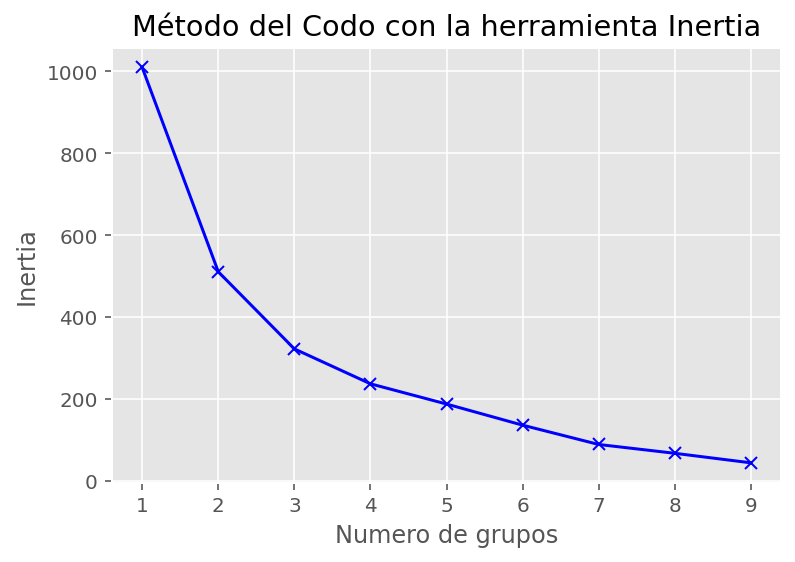

In [349]:
inertias = [] 
K = range(1,10) 
  
for k in K: 
    #Building and fitting the model 
    kmeanModel = KMeans(n_clusters=k).fit(data2_sub4.drop(['ccaa'],axis=1)) 
    kmeanModel.fit(data2_sub4.drop(['ccaa'],axis=1))     
    inertias.append(kmeanModel.inertia_) 
    
plt.plot(K, inertias, 'bx-') 
plt.xlabel('Numero de grupos') 
plt.ylabel('Inertia') 
plt.title('Método del Codo con la herramienta Inertia') 
plt.show()

In [350]:
# ajustado el algoritmo Kmeans ak conjunto de datos
from sklearn.cluster import KMeans

## Numero de clústers a utilizar. En este caso 4 clústers
kmeans = KMeans(n_clusters = 4, init = 'k-means++', random_state = 42)
y_kmeans = kmeans.fit_predict(data2_sub4.drop(['ccaa'],axis=1))
y_kmeans1=y_kmeans+1
cluster = pd.DataFrame(y_kmeans1)
today_sub4=data2_sub4.drop(['ccaa'],axis=1)
# Adding cluster to the Dataset
today_sub4['cluster'] = cluster
#Mean of clusters
kmeans_mean_cluster = pd.DataFrame(round(today_sub4.groupby('cluster').mean(),1))

## Identificación de los valores promedio ( centroides) 
kmeans_mean_cluster

,retail_and_recreation,grocery_and_pharmacy,transit_stations,workplaces,residential,fallecidos
cluster,,,,,,
1,-31.50,-4.40,-29.70,12.10,5.50,0.40
2,-28.00,-3.40,-17.20,12.50,5.10,0.10
3,-31.00,-5.30,-24.70,12.00,5.50,0.70
4,-34.40,-14.80,-34.80,11.30,6.20,0.60


In [351]:
today_Sub_2d=pd.concat([data2_sub4[['ccaa']],today_sub4],axis=1)
today_Sub_2d.head(5)

,ccaa,retail_and_recreation,grocery_and_pharmacy,transit_stations,workplaces,residential,fallecidos,cluster
0,Andalucía,-29.19,-6.51,-24.43,12.23,5.35,1.12,3
1,Aragón,-30.28,-3.92,-31.91,12.28,5.24,0.40,1
2,Asturias,-31.70,-4.76,-23.73,11.84,5.37,0.22,3
3,Canarias,-36.47,-17.00,-34.79,11.20,6.37,0.09,4
4,Cantabria,-24.55,-0.74,-19.76,12.39,5.42,0.06,2


In [352]:
for i in range(1,5):
    print('****Comunidades autónomas en el grupo {}*****'.format(str(i)))
    print(list(today_Sub_2d[today_Sub_2d.cluster==i]['ccaa'].values))

****Comunidades autónomas en el grupo 1*****
['Aragón', 'Castilla-La Mancha', 'Comunidad Valenciana', 'Galicia', 'La Rioja', 'Navarra']
****Comunidades autónomas en el grupo 2*****
['Cantabria', 'Extremadura']
****Comunidades autónomas en el grupo 3*****
['Andalucía', 'Asturias', 'Castilla y León', 'Cataluña', 'Islas Baleares', 'Murcia', 'País Vasco']
****Comunidades autónomas en el grupo 4*****
['Canarias', 'Ceuta y Melilla', 'Madrid']


In [353]:
#import plotly.express as px
fig = px.treemap(today_Sub_2d, path=['cluster','ccaa'], values='fallecidos')
fig.update_layout(autosize=False,width=800,height=700)

fig.show()

In [354]:
# creando los grupos
hc = AgglomerativeClustering(n_clusters=4, affinity = 'euclidean', linkage = 'ward')# save clusters for chart
y_hc = hc.fit_predict(data2_sub4.drop(['ccaa'],axis=1))

In [355]:
heirarchy4=data2_sub4.copy()
heirarchy4['cluster'] = y_hc

In [356]:
# Aca se anota el número de clústers si se desea poner de forma manual 
for i in range(4):
    print('****Nombre de las comunidades autónomas en cluster {}*****'.format(str(i)))
    print(list(heirarchy4[heirarchy4.cluster==i]['ccaa'].values))

****Nombre de las comunidades autónomas en cluster 0*****
['Cantabria', 'Extremadura']
****Nombre de las comunidades autónomas en cluster 1*****
['Canarias', 'Ceuta y Melilla', 'Madrid']
****Nombre de las comunidades autónomas en cluster 2*****
['Andalucía', 'Asturias', 'Castilla y León', 'Castilla-La Mancha', 'Cataluña', 'Comunidad Valenciana', 'Islas Baleares', 'Murcia', 'País Vasco']
****Nombre de las comunidades autónomas en cluster 3*****
['Aragón', 'Galicia', 'La Rioja', 'Navarra']


In [357]:
# grafico de los grupos de países
fig = px.treemap(heirarchy4, path=['cluster','ccaa'], values='fallecidos')
fig.update_layout(autosize=False,width=800,height=700)
fig.show()

# Modelo Lineal

## Modelo lineal Confirmados

In [342]:
# Preprocesado y modelado
# ==============================================================================
from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.anova import anova_lm
from scipy import stats

# Configuración matplotlib
# ==============================================================================
plt.rcParams['image.cmap'] = "bwr"
#plt.rcParams['figure.dpi'] = "100"
plt.rcParams['savefig.bbox'] = "tight"
style.use('ggplot') or plt.style.use('ggplot')

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

In [401]:
X = df_confirmados_.iloc[:,1:(len(df_confirmados_.columns)-1)]
#X = X.drop(['parks'], axis=1)
y = df_confirmados_['confirmados'] # confirmados totales

X_train, X_test, y_train, y_test = train_test_split(
                                        X,
                                        y.values.reshape(-1,1),
                                        train_size   = 0.8,
                                        random_state = 1234,
                                        shuffle      = True
                                    )
X.head(5)

,retail_and_recreation,grocery_and_pharmacy,transit_stations,workplaces,residential
0,0.00,-2.67,4.67,15.71,2.77
1,0.67,0.33,4.00,15.83,2.26
2,0.67,0.33,4.00,15.83,2.26
3,0.67,0.33,4.00,15.83,2.26
4,0.67,0.33,4.00,15.83,2.26


#=====================================================================
PRUEBA MODELO GLM
======================================================================

In [402]:
from sklearn.linear_model import LinearRegression

modelo = LinearRegression()
modelo.fit(X = X_train, y = y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [403]:
# Información del modelo
# ==============================================================================
print("Intercept:", modelo.intercept_)
print("Coeficiente:", list(zip(X.columns, modelo.coef_.flatten(), )))
print("Coeficiente de determinación R^2:", modelo.score(X, y))

Intercept: [0.45586301]
Coeficiente: [('retail_and_recreation', -0.009413435044790551), ('grocery_and_pharmacy', 0.025848643350760623), ('transit_stations', 0.012257169850364935), ('workplaces', -0.038917269616496095), ('residential', 0.18499159704715273)]
Coeficiente de determinación R^2: 0.06657860469849175


In [404]:
# Error de test del modelo 
# ==============================================================================
predicciones = modelo.predict(X = X_test)
print(predicciones[0:3,])

rmse = mean_squared_error(
        y_true  = y_test,
        y_pred  = predicciones,
        squared = False
       )
print("")
print(f"El error (rmse) de test es: {rmse}")

[[0.94207867]
 [0.95768834]
 [0.93901933]]

El error (rmse) de test es: 1.615255300997018


In [405]:
data = df_confirmados
formula = 'confirmados ~ retail_and_recreation + grocery_and_pharmacy + transit_stations + workplaces + residential'

scotland = sm.datasets.scotland.load_pandas().data

pd.options.mode.chained_assignment = None

mod1 = smf.glm(formula=formula, data=data, family=sm.families.Binomial(sm.families.links.logit)).fit()

i = mod1.summary()
print(i)

                 Generalized Linear Model Regression Results                  
Dep. Variable:            confirmados   No. Observations:                 9468
Model:                            GLM   Df Residuals:                     9462
Model Family:                Binomial   Df Model:                            5
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                    nan
Date:                Mon, 14 Jun 2021   Deviance:                          nan
Time:                        18:18:58   Pearson chi2:                 5.85e+26
No. Iterations:                   100                                         
Covariance Type:            nonrobust                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept              2.707e+

#==================================================================

In [ ]:
# Creación del modelo utilizando matrices como en scikitlearn
# ==============================================================================
X_train = sm.add_constant(X_train, prepend=True)
model = sm.OLS(endog=y_train, exog=X_train,)
model = model.fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.065
Model:                            OLS   Adj. R-squared:                  0.065
Method:                 Least Squares   F-statistic:                     105.5
Date:                Mon, 14 Jun 2021   Prob (F-statistic):          5.40e-108
Time:                        13:00:30   Log-Likelihood:                -14820.
No. Observations:                7574   AIC:                         2.965e+04
Df Residuals:                    7568   BIC:                         2.969e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -0.68

In [ ]:
# Intervalos de confianza para los coeficientes del modelo
# ==============================================================================
print(model.conf_int(alpha=0.05))

                          0     1
const                 -1.22 -0.15
retail_and_recreation -0.01 -0.01
grocery_and_pharmacy   0.02  0.03
transit_stations       0.06  0.12
workplaces            -0.07 -0.01
residential            0.14  0.23


In [ ]:
# Predicciones con intervalo de confianza del 95%
# ==============================================================================
predicciones = model.get_prediction(exog = X_train).summary_frame(alpha=0.05)
predicciones.head(4)

,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
5867,1.90,0.06,1.77,2.02,-1.46,5.26
5845,1.09,0.04,1.01,1.16,-2.27,4.45
8024,0.52,0.04,0.43,0.60,-2.84,3.88
9273,0.50,0.03,0.44,0.56,-2.86,3.86


In [ ]:
# Creación del modelo utilizando matrices como en scikitlearn
# ==============================================================================
X_train = sm.add_constant(X_train, prepend=True)
modelo = sm.OLS(endog=y_train, exog=X_train,)
modelo = modelo.fit()
print(modelo.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.065
Model:                            OLS   Adj. R-squared:                  0.065
Method:                 Least Squares   F-statistic:                     105.5
Date:                Mon, 14 Jun 2021   Prob (F-statistic):          5.40e-108
Time:                        03:13:06   Log-Likelihood:                -14820.
No. Observations:                7574   AIC:                         2.965e+04
Df Residuals:                    7568   BIC:                         2.969e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -0.68

## Modelo lineal Hospitalizados

In [ ]:
reg = linear_model.LinearRegression(fit_intercept=True, normalize=False, copy_X=True,
                                    n_jobs=None).fit(df_confirmados.iloc[:,3:(len(df_confirmados.columns)-1)], df_confirmados['confirmados'])


In [ ]:
print(reg.coef_)


[ -7.65777354  55.80051845 -12.25095428  25.79576556 -34.12582148
  86.60446559]


In [ ]:
modelo2 = sm.GLM(endog=y_train, exog=X_train, family=sm.families.Gaussian(sm.families.links.log))
res = modelo2.fit()
print(res.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                 7574
Model:                            GLM   Df Residuals:                     7568
Model Family:                Gaussian   Df Model:                            5
Link Function:                    log   Scale:                          2.9711
Method:                          IRLS   Log-Likelihood:                -14868.
Date:                Mon, 14 Jun 2021   Deviance:                       22486.
Time:                        03:13:40   Pearson chi2:                 2.25e+04
No. Iterations:                    24                                         
Covariance Type:            nonrobust                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -2.52

In [ ]:
exog = X.copy()
endog = y.copy() # confirmados totales
exog.head(5)

,retail_and_recreation,grocery_and_pharmacy,transit_stations,workplaces,residential
0,0.00,-2.67,13.47,15.71,2.77
1,0.67,0.33,13.38,15.83,2.26
2,0.67,0.33,13.38,15.83,2.26
3,0.67,0.33,13.38,15.83,2.26
4,0.67,0.33,13.38,15.83,2.26


In [ ]:
modelo2 = sm.GLM(endog, exog, family=sm.families.Gamma())
resul_model2 = modelo2.fit()
print(resul_model2.summary)

<bound method GLMResults.summary of <statsmodels.genmod.generalized_linear_model.GLMResults object at 0x7fd185580c10>>


In [ ]:
modelo3 = sm.GLM(endog, exog, family=sm.families.Binomial())
resul_model3 = modelo3.fit()
print(resul_model3.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:            confirmados   No. Observations:                 9468
Model:                            GLM   Df Residuals:                     9463
Model Family:                Binomial   Df Model:                            4
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                    nan
Date:                Mon, 14 Jun 2021   Deviance:                          nan
Time:                        03:22:50   Pearson chi2:                 1.25e+20
No. Iterations:                   100                                         
Covariance Type:            nonrobust                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
retail_and_recreation -7.997e+

In [ ]:
print('Numero de pruebas:',  endog[0].sum())
print('Parametros: ', resul_model3.params)
print('valores-T: ', resul_model3.tvalues)

Numero de pruebas: 0.0
Parametros:  retail_and_recreation      -799,662,110,846,241.75
grocery_and_pharmacy      3,261,070,414,752,910.00
transit_stations          7,770,291,192,693,685.00
workplaces              -10,325,670,874,812,436.00
residential              14,594,433,033,875,028.00
dtype: float64
valores-T:  retail_and_recreation   -10,876,576,120.03
grocery_and_pharmacy     62,371,251,701.83
transit_stations         16,979,543,214.27
workplaces              -28,982,969,585.21
residential              30,201,250,490.42
dtype: float64


In [ ]:
means = exog.mean(axis=0)
means25 = means.copy()
means25[0] = stats.scoreatpercentile(exog[:,0], 25)
means75 = means.copy()
means75[0] = lowinc_75per = stats.scoreatpercentile(exog[:,0], 75)
resp_25 = res.predict(means25)
resp_75 = res.predict(means75)
diff = resp_75 - resp_25

TypeError: ignored

In [ ]:
#fuente: 
!pip install git+https://github.com/scikit-learn-contrib/py-earth@v0.2dev --q

In [ ]:
#OTRO MODELO MAS

from pyearth import Earth
#from sklearn.model_selection import Earth

#Fit an Earth model
model = Earth()
model.fit(X,y)

#Print the model
print(model.trace())
print(model.summary())


#Plot the model
y_hat = model.predict(X)
pyplot.figure()
#pyplot.plot(X[:,6],y,'r.')
#pyplot.plot(X[:,6],y_hat,'b.')
pyplot.xlabel('x_6')
pyplot.ylabel('y')
pyplot.title('Simple Earth Example')
pyplot.show()

Forward Pass
---------------------------------------------------------------
iter  parent  var  knot  mse       terms  gcv    rsq    grsq   
---------------------------------------------------------------
0     -       -    -     3.071811  1      3.072  0.000  0.000  
1     0       3    -1    3.022831  2      3.025  0.016  0.015  
2     0       1    -1    2.984771  3      2.989  0.028  0.027  
3     0       0    -1    2.969184  4      2.975  0.033  0.032  
4     0       0    3946  2.968953  6      2.977  0.033  0.031  
---------------------------------------------------------------
Stopping Condition 2: Improvement below threshold

Pruning Pass
----------------------------------------------
iter  bf  terms  mse   gcv    rsq     grsq    
----------------------------------------------
0     -   6      2.97  2.978  0.033   0.031   
1     5   5      2.97  2.976  0.033   0.031   
2     4   4      2.97  2.975  0.033   0.032   
3     3   3      2.98  2.989  0.028   0.027   
4     2   2      3

NameError: ignored

PRUEBA MODELO LINEAL

In [ ]:
data = df_confirmados
formula = 'confirmados ~ retail_and_recreation + grocery_and_pharmacy + transit_stations + workplaces + residential'

scotland = sm.datasets.scotland.load_pandas().data

pd.options.mode.chained_assignment = None

mod1 = smf.glm(formula=formula, data=data, family=sm.families.Binomial(sm.families.links.logit)).fit()

i = mod1.summary()
print(i)

                 Generalized Linear Model Regression Results                  
Dep. Variable:            confirmados   No. Observations:                 9468
Model:                            GLM   Df Residuals:                     9462
Model Family:                Binomial   Df Model:                            5
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                    nan
Date:                Mon, 14 Jun 2021   Deviance:                          nan
Time:                        03:42:15   Pearson chi2:                 5.85e+26
No. Iterations:                   100                                         
Covariance Type:            nonrobust                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept              2.707e+

In [ ]:
i

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:            confirmados   No. Observations:                 9468
Model:                            GLM   Df Residuals:                     9462
Model Family:                Binomial   Df Model:                            5
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                    nan
Date:                Mon, 14 Jun 2021   Deviance:                          nan
Time:                        03:42:15   Pearson chi2:                 5.85e+26
No. Iterations:                   100                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept              2.707e+20    1.5e+06   1.81e+14      0.000    2.71e+20    2.71e+20
retail_and_recreation -8.948e+18   7.36e+04  -1.21e+14      0.000   -8.95e+18   -8.95e+18
grocery_and_pharmacy   2.261e+19   5.34e+04   4.23e+14      0.000    2.26e+19    2.26e+19
transit_stations       1.109e+19   7.47e+04   1.48e+14      0.000    1.11e+19    1.11e+19
workplaces             -6.04e+18   8.29e+04  -7.28e+13      0.000   -6.04e+18   -6.04e+18
residential            5.783e+19   2.72e+05   2.13e+14      0.000    5.78e+19    5.78e+19
=========================================================================================
"""

In [ ]:
import statsmodels.api as sm
data = sm.datasets.scotland.load()
data.exog = sm.add_constant(data.exog)
gamma_model = sm.GLM(data.endog, data.exog, family=sm.families.Gamma())
gamma_results = gamma_model.fit()
print(gamma_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                   32
Model:                            GLM   Df Residuals:                       24
Model Family:                   Gamma   Df Model:                            7
Link Function:          inverse_power   Scale:                       0.0035843
Method:                          IRLS   Log-Likelihood:                -83.017
Date:                Mon, 14 Jun 2021   Deviance:                     0.087389
Time:                        03:26:04   Pearson chi2:                   0.0860
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0178      0.011     -1.548      0.1

In [ ]:
%matplotlib inline

from __future__ import print_function
import numpy as np
import statsmodels.api as sm
from scipy import stats
from matplotlib import pyplot as plt

data = sm.datasets.star98.load()
data.exog = sm.add_constant(data.exog, prepend=False)

# La variable dependiente es N por 2 (Exito: NABOVE, Fallo: NBELOW):

print(data.endog[:5,:])

[[452. 355.]
 [144.  40.]
 [337. 234.]
 [395. 178.]
 [  8.  57.]]


In [ ]:
glm_binom = sm.GLM(data.endog, data.exog, family=sm.families.Binomial())
res = glm_binom.fit()
print(res.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:           ['y1', 'y2']   No. Observations:                  303
Model:                            GLM   Df Residuals:                      282
Model Family:                Binomial   Df Model:                           20
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2998.6
Date:                Mon, 14 Jun 2021   Deviance:                       4078.8
Time:                        03:26:49   Pearson chi2:                 4.05e+03
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0168      0.000    -38.749      0.0

In [ ]:
print('Numero de pruebas:',  data.endog[0].sum())
print('Parametros: ', res.params)
print('valores-T: ', res.tvalues)

Numero de pruebas: 807.0
Parametros:  [-1.68150366e-02  9.92547661e-03 -1.87242148e-02 -1.42385609e-02
  2.54487173e-01  2.40693664e-01  8.04086739e-02 -1.95216050e+00
 -3.34086475e-01 -1.69022168e-01  4.91670212e-03 -3.57996435e-03
 -1.40765648e-02 -4.00499176e-03 -3.90639579e-03  9.17143006e-02
  4.89898381e-02  8.04073890e-03  2.22009503e-04 -2.24924861e-03
  2.95887793e+00]
valores-T:  [-38.74908321  16.50473627 -25.1821894  -32.81791308   8.49827113
   4.21247925   5.7749976   -6.16191078  -5.45321673  -5.16865445
   3.92119964 -15.87825999  -7.39093058  -8.44963886  -4.05916246
   6.3210987    6.57434662   5.36229044   7.42806363  -6.44513698
   1.91301155]


In [ ]:
means = data.exog.mean(axis=0)
means25 = means.copy()
means25[0] = stats.scoreatpercentile(data.exog[:,0], 25)
means75 = means.copy()
means75[0] = lowinc_75per = stats.scoreatpercentile(data.exog[:,0], 75)
resp_25 = res.predict(means25)
resp_75 = res.predict(means75)
diff = resp_75 - resp_25

In [ ]:
print("%2.4f%%" % (diff*100))

-11.8753%
